In [1]:
import os, datetime, time, re, warnings, gc, json

from abc import ABCMeta, abstractmethod
from pathlib import Path
from contextlib import contextmanager
import multiprocessing
from multiprocessing import Pool

import yaml

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.core.common import SettingWithCopyWarning

from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn import datasets, manifold, mixture, model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

from scipy.sparse import vstack, csr_matrix, save_npz, load_npz, hstack

from gensim import corpora, models, similarities
from gensim.models import Word2Vec

import lightgbm as lgb
import optuna.integration.lightgbm as tuna

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option("display.width", 1000)
pd.set_option('display.max_columns', None)

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    print(f'[{title}] start')
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
class FeatureEngineering(metaclass=ABCMeta):
    BASE_DIR = "."
    
    def __init__(self):
        self.name = self.__class__.__name__
        self.train = pd.DataFrame()
        self.test = pd.DataFrame()
        self.train_file_path = f"{Path(self.BASE_DIR)}/{self.name.lower()}_train"
        self.test_file_path = f"{Path(self.BASE_DIR)}/{self.name.lower()}_test"
    
    @abstractmethod
    def load_data(self):
        raise NotImplementedError

    @abstractmethod
    def create_features(self):
        raise NotImplementedError
        
    def run(self, use_columns=[], skip_columns=[]):
        with timer(self.name):
            self.load_data()
            self.replace_na(use_columns=use_columns, skip_columns=skip_columns)
            self.onehot_encode(use_columns=use_columns, skip_columns=skip_columns)
            self.create_features()
        
        return self
    
    def onehot_encode(self, use_columns=[], skip_columns=[], sparse=False):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        self.label_encode(use_columns, skip_columns)
        if sparse:
            encoder = OneHotEncoder(categories='auto', sparse=sparse, dtype='uint8').fit(pd.concat([self.train.loc[:, use_columns], self.test.loc[:, use_columns]]))
            m = 100000
            train = vstack([encoder.transform(self.train[i*m:(i+1)*m].loc[:, use_columns]) for i in range(self.train.shape[0] // m + 1)])
            test  = vstack([encoder.transform(self.test[i*m:(i+1)*m].loc[:, use_columns])  for i in range(self.test.shape[0] // m +  1)])
            save_npz(f"{self.train_file_path}.npz", train, compressed=True)
            save_npz(f"{self.test_file_path}.npz",  test,  compressed=True)
        else:
            self.train["is_train_date"] = 1
            self.test["is_train_date"]  = 0
            df = pd.concat([self.train, self.test])
            del self.train, self.test
            gc.collect()
            for col in use_columns:
                df = df.join(pd.get_dummies(df[col], prefix=col))
            
            self.train = df[df["is_train_date"]==1]
            self.test = df[df["is_train_date"]==0]
            self.train.drop(columns="is_train_date", inplace=True)
            self.test.drop(columns="is_train_date", inplace=True)
            
        return self
    
    def label_encode(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            self.train[col] = self.train[col].astype('str')
            self.test[col] = self.test[col].astype('str')
            
            le = LabelEncoder().fit(np.unique(self.train[col].unique().tolist()+self.test[col].unique().tolist()))
            self.train[col] = le.transform(self.train[col])+1
            self.test[col]  = le.transform(self.test[col])+1
    
        return self
    
    def target_encode(self, col_name, target_name, min_samples_leaf=1, smoothing=1, noise_level=0):
        trn_series = self.train[col_name]
        tst_series = self.test[col_name]
        target = self.train[target_name]
        
        assert len(trn_series) == len(target)

        temp = pd.concat([trn_series, target], axis=1)
        averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
        smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
        prior = target.mean()
        averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
        averages.drop(["mean", "count"], axis=1, inplace=True)
        ft_trn_series = pd.merge(
            trn_series.to_frame(trn_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=trn_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        ft_trn_series.index = trn_series.index 
        ft_tst_series = pd.merge(
            tst_series.to_frame(tst_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=tst_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        ft_tst_series.index = tst_series.index

        self.train[f"te_smoothing_{col_name}"], self.test[f"te_smoothing_{col_name}"] = self.__add_noise(ft_trn_series, noise_level), self.__add_noise(ft_tst_series, noise_level)
        
        return self
    
    def agg_transform(self, group, agg, prefix=""):
        if prefix:
            prefix += "_"
        else:
            prefix = f"{'_'.join(group)}_" if type(group) is list else f"{group}_"

        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
            
        for k, v in agg.items():
            if type(v) is str:
                df[f"{prefix}{k}_{v}"] = df.groupby(group)[k].transform(v)
            else:
                for vv in v:
                    df[f"{prefix}{k}_{vv}"] = df.groupby(group)[k].transform(vv)
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def agg_transform_ratio(self, group, agg, prefix=""):
        if prefix:
            prefix += "_"
        else:
            prefix = f"{'_'.join(group)}_" if type(group) is list else f"{group}_"
        prefix = f"ratio_{prefix}"
        
        for k, v in agg.items():
            if type(v) is str:
                self.train[f"{prefix}{k}_{v}"] = self.train[k] / self.train.groupby(group)[k].transform(v)
                self.test[f"{prefix}{k}_{v}"] = self.test[k] / self.test.groupby(group)[k].transform(v)
            else:
                for vv in v:
                    self.train[f"{prefix}{k}_{vv}"] = self.train[k] / self.train.groupby(group)[k].transform(vv)
                    self.test[f"{prefix}{k}_{vv}"] = self.test[k] / self.test.groupby(group)[k].transform(vv)
        
        return self
    
    def replace_na(self, use_columns=[], skip_columns=[], fill_value=-1):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(fill_value))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(fill_value))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(fill_value)
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(fill_value)

        return self
    
    def replace_na_mode(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].mode().values[0])
            self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].mode().values[0])

        return self
    
    def replace_na_mean(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].mean())
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].mean())

        return self

    def replace_na_median(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].median())
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].median())

        return self
    
    def calc_topic_score(self, topic_text_columns, num_topics=5):
        df = pd.concat([self.train.loc[:, topic_text_columns], self.test.loc[:, topic_text_columns]])
        
        for col in topic_text_columns:
            texts = [[word for word in document.lower().split()] for document in df[col].values]
            dictionary = corpora.Dictionary(texts)
            bow_corpus = [dictionary.doc2bow(t) for t in texts]
            lda = models.LdaModel(bow_corpus, id2word=dictionary, num_topics=num_topics)
                        
            size = df.shape[0]
            topics = {i:[-1]*size for i in range(num_topics)}
            for i, row in enumerate(lda[bow_corpus]):
                for (topic_num, prop_topic) in row:
                    topics[topic_num][i] = prop_topic
            
            for i in range(num_topics):
                self.train[f"{col}_topic_{i}"] = topics[i][:self.train.shape[0]]
                self.test[f"{col}_topic_{i}"] = topics[i][self.train.shape[0]:]

        return self
    
    def calc_scdv_word2vec_score(self, text_col_name):
        features_num = 20
        min_word_count = 10
        context = 5
        downsampling = 1e-3
        epoch_num = 10
        clusters_num = 6
        
        df = pd.concat([self.train.loc[:, [text_col_name]], self.test.loc[:, [text_col_name]]])
        df[text_col_name] = df[text_col_name].fillna("")
        
        corpus = [self.__analyzer_cat(text) for text in df[text_col_name]]
        word2vecs = Word2Vec(sentences=corpus, iter=epoch_num, size=features_num, min_count=min_word_count, window=context, sample=downsampling)
        word_vectors = word2vecs.wv.vectors
        
        gmm = mixture.GaussianMixture(n_components=clusters_num, covariance_type='tied', max_iter=50)
        gmm.fit(word_vectors)
        
        tfidf_vectorizer = TfidfVectorizer(analyzer=self.__analyzer_cat, min_df=min_word_count)
        tfidfs = tfidf_vectorizer.fit_transform(df[text_col_name])
        
        idf_dic = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer._tfidf.idf_))
        assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict(word_vectors)))
        soft_assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict_proba(word_vectors)))
        
        word_topic_vecs = {}
        for word in assign_dic:
            word_topic_vecs[word] = np.zeros(features_num*clusters_num, dtype=np.float32)
            for i in range(0, clusters_num):
                try:
                    word_topic_vecs[word][i*features_num:(i+1)*features_num] = word2vecs.wv[word]*soft_assign_dic[word][i]*idf_dic[word]
                except:
                    continue
        
        scdvs = np.zeros((len(df[text_col_name]), clusters_num*features_num), dtype=np.float32)

        a_min = 0
        a_max = 0

        for i, text in enumerate(df[text_col_name]):
            tmp = np.zeros(clusters_num*features_num, dtype=np.float32)
            words = self.__analyzer_cat(text)
            for word in words:
                if word in word_topic_vecs:
                    tmp += word_topic_vecs[word]
            norm = np.sqrt(np.sum(tmp**2))
            if norm > 0:
                tmp /= norm
            a_min += min(tmp)
            a_max += max(tmp)
            scdvs[i] = tmp

        p = 0.04
        a_min = a_min*1.0 / len(df[text_col_name])
        a_max = a_max*1.0 / len(df[text_col_name])
        thres = (abs(a_min)+abs(a_max)) / 2
        thres *= p
        scdvs[abs(scdvs) < thres] = 0
        
        tsne_scdv = manifold.TSNE(n_components=2).fit_transform(scdvs)
        
        self.train[f"scdv_{text_col_name}_x"] = tsne_scdv[:self.train.shape[0], 0]
        self.train[f"scdv_{text_col_name}_y"] = tsne_scdv[:self.train.shape[0], 1]        
        self.test[f"scdv_{text_col_name}_x"] = tsne_scdv[self.train.shape[0]:, 0]
        self.test[f"scdv_{text_col_name}_y"] = tsne_scdv[self.train.shape[0]:, 1]
        
        return self
    
    def columns_1d(self):
        self.train.columns = pd.Index([(e[0] + "_" + e[1].lower()) if (len(e[1]) > 0) else e[0] for e in self.train.columns.tolist()])
        self.test.columns = pd.Index([(e[0] + "_" + e[1].lower()) if (len(e[1]) > 0) else e[0] for e in self.test.columns.tolist()])

        return self
    
    def head(self, title="", columns=[], limit=5):
        train_cols, test_cols = (columns, columns) if columns else (self.train.columns, self.test.columns)
        
        print(f"train head: {title}")
        print(self.train.loc[:, train_cols].head(limit))
        print("----------------------------")
        print(f"test head: {title}")
        print(self.test.loc[:, test_cols].head(limit))
        print("----------------------------")
        
        return self
    
    def tail(self, title="", columns=[], limit=5):
        train_cols, test_cols = (columns, columns) if columns else (self.train.columns, self.test.columns)
        
        print(f"train tail: {title}")
        print(self.train.loc[:, train_cols].tail(limit))
        print("----------------------------")
        print(f"test tail: {title}")
        print(self.test.loc[:, test_cols].tail(limit))
        print("----------------------------")
        
        return self
    
    def save(self, format="feather", index=False):
        if format == "feather":
            self.train.to_feather(f"{self.train_file_path}.ftr")
            self.test.to_feather(f"{self.test_file_path}.ftr")
        elif format == "csv":
            self.train.to_csv(f"{self.train_file_path}.csv", index=index)
            self.test.to_csv(f"{self.test_file_path}.csv", index=index)
        
        return self
    
    def __add_noise(self, series, noise_level):
        return series * (1 + noise_level * np.random.randn(len(series)))

    def __analyzer_nlp(self, text):
        stop_words = ['i', 'a', 'an', 'the', 'to', 'and', 'or', 'if', 'is', 'are', 'am', 'it', 'this', 'that', 'of', 'from', 'in', 'on']
        text = text.lower()
        text = text.replace('\n', '')
        text = text.replace('\t', '')
        text = re.sub(re.compile(r'[!-\/:-@[-`{-~]'), ' ', text)
        text = text.split(' ')

        words = []
        for word in text:
            if (re.compile(r'^.*[0-9]+.*$').fullmatch(word) is not None):
                continue
            if word in stop_words:
                continue
            if len(word) < 2:
                continue
            words.append(word)

        return words

    def __analyzer_cat(self, text):
        return text.split(' ')

In [4]:
class Sample(FeatureEngineering):
    def load_data(self):
        self.train = pd.read_csv("../input/train.csv")
        self.test = pd.read_csv("../input/test.csv")
        
        return self
    
    def create_features(self):
        return self
    
    def create_topic_text(self):
        self.train["count_1"] = self.train["first_active_month"].astype("str") + self.train.groupby("first_active_month")["first_active_month"].transform("count").astype("int").astype("str")
        self.train["count_2"] = self.train["feature_1"].astype("int").astype("str") + self.train.groupby("feature_1")["feature_1"].transform("count").astype("int").astype("str")
        self.train["topic_text"] = "A"+self.train["count_1"].astype(str) \
                            +" B"+self.train["count_2"].astype(str)
        
        self.test["count_1"] = self.test["first_active_month"].astype("str") + self.test.groupby("first_active_month")["first_active_month"].transform("count").astype("int").astype("str")
        self.test["count_2"] = self.test["feature_1"].astype("int").astype("str") + self.test.groupby("feature_1")["feature_1"].transform("count").astype("int").astype("str")
        self.test["topic_text"] = "A"+self.test["count_1"].astype(str) \
                            +" B"+self.test["count_2"].astype(str)
        
        return self

In [25]:
class AutoML():
    SEED = 42
    EVAL_COLUMN = "_preds"
    NUMERICS = ["int16", "int32", "int64", "float16", "float32", "float64"]
    
    def __init__(self, engine):
        if not isinstance(engine, FeatureEngineering): raise TypeError
        self.engine = engine
    
    def run(self, scenario):
        self.target = scenario["target"]
        self.engine.load_data()
        self.engine.label_encode(skip_columns=[self.target])
        
        if "drop_features" in scenario:
            self.__drop_features(scenario["drop_features"])
        
        self.__fill_numeric_na()
        self.__binning()
        
        for command in scenario["feature_engineering"]:
            self.__do(command)
            
        if "drop_features" in scenario:
            self.__drop_features(scenario["drop_features"])
        
        adv_score, importance = self.__adversarial_validation()
        if adv_score > 0.7:
            v = importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:5].index.values
            self.__drop_features(v)
        
        params = {
            'objective': scenario["objective"],
            'boosting_type': scenario["boosting_type"], 
            'metric': scenario["metric"],
            'n_jobs': -1,
            'seed': AutoML.SEED
        }
        tuned = self.__hyper_parameter_tuning(params)
        params = dict(params, **tuned)
        
        self.predicts, importance = self.__train(params)
        param_with_score = self.__evaluate(params, pd.read_csv(scenario["eval_file_path"]))
        with open(f"./param_{param_with_score['score']}.json", "w") as fw:
            json.dump(param_with_score, fw)    
                  
    def __do(self, command):
        if command == "transformation":
            self.__transformation()
        if command == "train":
            self.__train()
    
    def __evaluate(self, params, actuals):
        actuals[AutoML.EVAL_COLUMN] = self.predicts
        if params["objective"] == "binary":
            actuals.loc[actuals[AutoML.EVAL_COLUMN]>=0.5, AutoML.EVAL_COLUMN] = 1
            actuals.loc[actuals[AutoML.EVAL_COLUMN]<0.5, AutoML.EVAL_COLUMN] = 0
            actuals[AutoML.EVAL_COLUMN] = actuals[AutoML.EVAL_COLUMN].astype("int")
    
        score = actuals[actuals[self.target]==actuals[AutoML.EVAL_COLUMN]].shape[0] / actuals.shape[0]
        params["score"] = score
        print(f"Score: {score}")
        return params
    
    def __transformation(self):
        col_types = self.__col_types()
        aggs = ["min", "max", "mean", "std"]
        num_columns = [k for k, v in col_types.items() if v == "numeric"]
        for k, v in col_types.items():
            if v in ["categorical", "num_categorical"]:
                self.engine.agg_transform(group=[k], agg={f"{k}": ["count"]})
            for c in num_columns:
                self.engine.agg_transform(group=[k], agg={f"{c}": aggs})
                for agg in aggs:
                    if self.engine.train[self.engine.train[f"{k}_{c}_{agg}"].isnull()].shape[0] > 0:
                        self.engine.train.drop(columns=[f"{k}_{c}_{agg}"], inplace=True)
                        self.engine.test.drop(columns=[f"{k}_{c}_{agg}"], inplace=True)

    def __fill_numeric_na(self):
        col_types = self.__col_types()
        num_columns = [k for k, v in col_types.items() if v == "numeric"]
        cat_columns = [k for k, v in col_types.items() if v in ["categorical", "num_categorical"]]
        groups = []
        for c in cat_columns:
            if self.engine.train[self.engine.train[c].isnull()].shape[0] == 0:
                if self.engine.train.groupby(c).size().shape[0] / self.engine.train.shape[0] < 0.1:
                    groups.append(c)
        for n in num_columns:
            if len(groups) > 0:
                self.engine.agg_transform(group=groups, agg={f"{n}": ["mean"]}, prefix="_tmp")
                self.engine.train.loc[self.engine.train[n].isnull(), n] = self.engine.train.loc[self.engine.train[n].isnull(), f"_tmp_{n}_mean"]
                self.engine.test.loc[self.engine.test[n].isnull(), n] = self.engine.test.loc[self.engine.test[n].isnull(), f"_tmp_{n}_mean"]
                self.engine.train.drop(columns=[f"_tmp_{n}_mean"], inplace=True)
                self.engine.test.drop(columns=[f"_tmp_{n}_mean"], inplace=True)

    def __binning(self):
        border = self.engine.train.shape[0]
        df = pd.concat([self.engine.train, self.engine.test], ignore_index=True)
        col_types = self.__col_types()
        num_columns = [k for k, v in col_types.items() if v == "numeric"]
        for c in num_columns:
            df[f"{c}_bin"] = pd.cut(df[c], 10, labels=False)
        self.engine.train = df.iloc[:border]
        self.engine.test = df.iloc[border:]
        
    def __col_types(self):
        col_types = {}
        feats = [f for f in self.engine.train.columns if f not in self.target]
        for col in feats:
            col_type = self.engine.train[col].dtypes
            if col_type in AutoML.NUMERICS:
                if self.engine.train[col].unique().shape[0] < 20:
                    col_types[col] = "num_categorical"
                else:
                    col_types[col] = "numeric"
            else:
                col_types[col] = "categorical"
        return col_types

    def __drop_features(self, cols):
        feats = [f for f in self.engine.train.columns if f in cols]
        self.engine.train.drop(columns=feats, inplace=True)
        self.engine.test.drop(columns=feats, inplace=True)
    
    def __hyper_parameter_tuning(self, params):
        train, valid = model_selection.train_test_split(self.engine.train, test_size=0.33, random_state=AutoML.SEED, shuffle=True)
        feats = [f for f in train.columns if f not in self.target]
        
        lgb_train = tuna.Dataset(train[feats], label=train[self.target].values)
        lgb_valid = tuna.Dataset(valid[feats], label=valid[self.target].values)
        best_params, tuning_history = dict(), list()

        model = tuna.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_valid],
                        valid_names=['train', 'valid'],
                        num_boost_round=1000, 
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        best_params=best_params,
                        tuning_history=tuning_history
                        )

        return best_params
    
    def __adversarial_validation(self, num_folds=5):
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)
        feats = [f for f in self.engine.train.columns if f not in self.target]
        train = self.engine.train[feats]
        test = self.engine.test[feats]
        train[self.target] = 0
        test[self.target] = 1
        
        df = pd.concat([train, test], ignore_index=True)
        del train, test
        gc.collect()
        
        oof_preds = np.zeros(df.shape[0])
        feature_importance_df = pd.DataFrame()

        scores = []
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[feats], df[self.target])):
            train_x, train_y = df[feats].iloc[train_idx], df[self.target].iloc[train_idx]
            valid_x, valid_y = df[feats].iloc[valid_idx], df[self.target].iloc[valid_idx]

            lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    free_raw_data=False)
            lgb_valid = lgb.Dataset(valid_x,
                                   label=valid_y,
                                   free_raw_data=False)
            params = {'num_leaves': 50,
                     'min_data_in_leaf': 30, 
                     'objective':'binary',
                     'max_depth': 5,
                     'learning_rate': 0.1,
                     "min_child_samples": 20,
                     "boosting": "gbdt",
                     "feature_fraction": 0.9,
                     "bagging_freq": 1,
                     "bagging_fraction": 0.9 ,
                     "bagging_seed": 44,
                     "metric": 'auc',
                     "verbosity": -1}

            model = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_valid],
                        valid_names=['train', 'valid'],
                        num_boost_round=1000, 
                        early_stopping_rounds=100,
                        verbose_eval=100
                        )

            oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            scores.append(self.__calc_score(params, valid_y, oof_preds[valid_idx]))

        self.__display_importances(feature_importance_df)
        
        return sum(scores)/len(scores), feature_importance_df
        
    def __train(self, params, num_folds=5, stratified=False):
        if stratified:
            folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)
        else:
            folds = KFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)

        feats = [f for f in self.engine.train.columns if f not in self.target]
        oof_preds = np.zeros(self.engine.train.shape[0])
        sub_preds = np.zeros(self.engine.test.shape[0])
        feature_importance_df = pd.DataFrame()

        scores = []
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(self.engine.train[feats], self.engine.train[self.target])):
            train_x, train_y = self.engine.train[feats].iloc[train_idx], self.engine.train[self.target].iloc[train_idx]
            valid_x, valid_y = self.engine.train[feats].iloc[valid_idx], self.engine.train[self.target].iloc[valid_idx]

            lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    free_raw_data=False)
            lgb_valid = lgb.Dataset(valid_x,
                                   label=valid_y,
                                   free_raw_data=False)
            model = lgb.train(
                            params,
                            lgb_train,
                            valid_sets=[lgb_train, lgb_valid],
                            valid_names=['train', 'valid'],
                            num_boost_round=1000, 
                            early_stopping_rounds=100,
                            verbose_eval=100
                            )

            oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)
            sub_preds += model.predict(self.engine.test[feats], num_iteration=model.best_iteration) / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            scores.append(self.__calc_score(params, valid_y, oof_preds[valid_idx]))

        print('CV : %.6f' % (sum(scores)/len(scores)))
        self.__display_importances(feature_importance_df)

        return sub_preds, feature_importance_df
    
    def __display_importances(self, feature_importance_df_):
        all_cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
        feature_importance_df_.loc[feature_importance_df_.feature.isin(all_cols)].to_csv("feature_importance.csv", index=False)

        cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
        best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

        plt.figure(figsize=(8, 10))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.savefig('lgbm_importances.png')
    
    def __calc_score(self, params, actuals, preds):
        if params["metric"] == "rmse":
            return np.sqrt(mean_squared_error(actuals, preds))
        if params["metric"] in ["cross_entropy", "binary_logloss"]:
            return log_loss(actuals, preds)
        if params["metric"] == "auc":
            return roc_auc_score(actuals, preds)

In [26]:
with open("../input/scenario.yml", "r") as yml:
    scenario = yaml.load(yml)

In [27]:
ml = AutoML(engine=Sample())

Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.909667	valid's auc: 0.514664
Early stopping, best iteration is:
[80]	train's auc: 0.891187	valid's auc: 0.51686
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.904707	valid's auc: 0.500963
Early stopping, best iteration is:
[1]	train's auc: 0.648858	valid's auc: 0.529661
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.905615	valid's auc: 0.526806
Early stopping, best iteration is:
[84]	train's auc: 0.893008	valid's auc: 0.529671
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.894257	valid's auc: 0.553726
[200]	train's auc: 0.942898	valid's auc: 0.555217
Early stopping, best iteration is:
[170]	train's auc: 0.932605	valid's auc: 0.563753
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.906758	valid's auc: 0.520078
[200]	train's auc: 0.95397	valid's auc: 0.516374
Early 

tune_feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.106105	valid's cross_entropy: 0.535183
Early stopping, best iteration is:
[22]	train's cross_entropy: 0.314421	valid's cross_entropy: 0.443881


tune_feature_fraction, val_score: 0.443881:  14%|########5                                                   | 1/7 [00:00<00:01,  5.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.101378	valid's cross_entropy: 0.545949
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.299009	valid's cross_entropy: 0.44517


tune_feature_fraction, val_score: 0.443881:  29%|#################1                                          | 2/7 [00:00<00:01,  4.87it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.09853	valid's cross_entropy: 0.537166
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.277632	valid's cross_entropy: 0.444534


tune_feature_fraction, val_score: 0.443881:  43%|#########################7                                  | 3/7 [00:00<00:00,  4.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_feature_fraction, val_score: 0.439773:  57%|##################################2                         | 4/7 [00:01<00:00,  4.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.096759	valid's cross_entropy: 0.531916
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.318762	valid's cross_entropy: 0.446165


tune_feature_fraction, val_score: 0.439773:  71%|##########################################8                 | 5/7 [00:01<00:00,  4.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0929799	valid's cross_entropy: 0.554571
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.296682	valid's cross_entropy: 0.450549


tune_feature_fraction, val_score: 0.439773:  86%|###################################################4        | 6/7 [00:01<00:00,  3.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0927807	valid's cross_entropy: 0.547231
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.295088	valid's cross_entropy: 0.455911


tune_feature_fraction, val_score: 0.439773: 100%|############################################################| 7/7 [00:01<00:00,  3.77it/s][I 2020-01-27 17:26:44,260] Finished trial#6 resulted in value: 0.45591088828846005. Current best value is 0.43977344073941194 with parameters: {'feature_fraction': 0.7}.

tune_num_leaves, val_score: 0.439773:   0%|                                                                         | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:   5%|###2                                                             | 1/20 [00:00<00:03,  5.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  10%|######5                                                          | 2/20 [00:00<00:03,  4.87it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  15%|#########7                                                       | 3/20 [00:00<00:03,  4.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  20%|#############                                                    | 4/20 [00:01<00:03,  4.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.156156	valid's cross_entropy: 0.491331
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.306152	valid's cross_entropy: 0.442677


tune_num_leaves, val_score: 0.439773:  25%|################2                                                | 5/20 [00:01<00:03,  4.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  30%|###################5                                             | 6/20 [00:01<00:03,  3.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  35%|######################7                                          | 7/20 [00:01<00:03,  3.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  40%|##########################                                       | 8/20 [00:02<00:03,  3.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  45%|#############################2                                   | 9/20 [00:02<00:03,  3.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  50%|################################                                | 10/20 [00:02<00:02,  3.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  55%|###################################2                            | 11/20 [00:03<00:02,  3.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  60%|######################################4                         | 12/20 [00:03<00:02,  3.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  65%|#########################################6                      | 13/20 [00:03<00:01,  3.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  70%|############################################8                   | 14/20 [00:03<00:01,  3.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  75%|################################################                | 15/20 [00:04<00:01,  3.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  80%|###################################################2            | 16/20 [00:04<00:01,  3.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  85%|######################################################4         | 17/20 [00:04<00:00,  3.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.101376	valid's cross_entropy: 0.538856
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.30085	valid's cross_entropy: 0.444145


tune_num_leaves, val_score: 0.439773:  90%|#########################################################6      | 18/20 [00:04<00:00,  3.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  95%|############################################################8   | 19/20 [00:05<00:00,  3.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773: 100%|################################################################| 20/20 [00:05<00:00,  3.70it/s][I 2020-01-27 17:26:49,761] Finished trial#19 resulted in value: 0.43977344073941194. Current best value is 0.43977344073941194 with parameters: {'num_leaves': 186}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:   0%|                                                  | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.109672	valid's cross_entropy: 0.494564
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.253444	valid's cross_entropy: 0.43175


tune_bagging_fraction_and_bagging_freq, val_score: 0.431750:  10%|####2                                     | 1/10 [00:00<00:01,  5.66it/s][I 2020-01-27 17:26:50,047] Finished trial#0 resulted in value: 0.431750414340924. Current best value is 0.431750414340924 with parameters: {'bagging_fraction': 0.8822455295670004, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.431750:  10%|####2                                     | 1/10 [00:00<00:01,  5.66it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.17097	valid's cross_entropy: 0.498362
Early stopping, best iteration is:
[26]	train's cross_entropy: 0.331816	valid's cross_entropy: 0.439809


tune_bagging_fraction_and_bagging_freq, val_score: 0.431750:  20%|########4                                 | 2/10 [00:00<00:01,  5.09it/s][I 2020-01-27 17:26:50,296] Finished trial#1 resulted in value: 0.4398088188968528. Current best value is 0.431750414340924 with parameters: {'bagging_fraction': 0.8822455295670004, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.431750:  20%|########4                                 | 2/10 [00:00<00:01,  5.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.236056	valid's cross_entropy: 0.490078
Early stopping, best iteration is:
[23]	train's cross_entropy: 0.386206	valid's cross_entropy: 0.442035


tune_bagging_fraction_and_bagging_freq, val_score: 0.431750:  30%|############6                             | 3/10 [00:00<00:01,  5.02it/s][I 2020-01-27 17:26:50,494] Finished trial#2 resulted in value: 0.44203538165725537. Current best value is 0.431750414340924 with parameters: {'bagging_fraction': 0.8822455295670004, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.431750:  30%|############6                             | 3/10 [00:00<00:01,  5.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.152267	valid's cross_entropy: 0.471823
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.28969	valid's cross_entropy: 0.420582


tune_bagging_fraction_and_bagging_freq, val_score: 0.420582:  40%|################8                         | 4/10 [00:00<00:01,  4.65it/s][I 2020-01-27 17:26:50,761] Finished trial#3 resulted in value: 0.4205824190792196. Current best value is 0.4205824190792196 with parameters: {'bagging_fraction': 0.6910934400770615, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.420582:  40%|################8                         | 4/10 [00:00<00:01,  4.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.11753	valid's cross_entropy: 0.526689
Early stopping, best iteration is:
[17]	train's cross_entropy: 0.360245	valid's cross_entropy: 0.450625


tune_bagging_fraction_and_bagging_freq, val_score: 0.420582:  50%|#####################                     | 5/10 [00:01<00:01,  4.45it/s][I 2020-01-27 17:26:50,993] Finished trial#4 resulted in value: 0.45062540084508235. Current best value is 0.4205824190792196 with parameters: {'bagging_fraction': 0.6910934400770615, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.420582:  50%|#####################                     | 5/10 [00:01<00:01,  4.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0975945	valid's cross_entropy: 0.542086
Early stopping, best iteration is:
[23]	train's cross_entropy: 0.303274	valid's cross_entropy: 0.446017


tune_bagging_fraction_and_bagging_freq, val_score: 0.420582:  60%|#########################2                | 6/10 [00:01<00:00,  4.18it/s][I 2020-01-27 17:26:51,278] Finished trial#5 resulted in value: 0.44601723512907554. Current best value is 0.4205824190792196 with parameters: {'bagging_fraction': 0.6910934400770615, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.420582:  60%|#########################2                | 6/10 [00:01<00:00,  4.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.11443	valid's cross_entropy: 0.516017
Early stopping, best iteration is:
[19]	train's cross_entropy: 0.342125	valid's cross_entropy: 0.444732


tune_bagging_fraction_and_bagging_freq, val_score: 0.420582:  70%|#############################4            | 7/10 [00:01<00:00,  3.77it/s][I 2020-01-27 17:26:51,593] Finished trial#6 resulted in value: 0.4447317595237776. Current best value is 0.4205824190792196 with parameters: {'bagging_fraction': 0.6910934400770615, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.420582:  70%|#############################4            | 7/10 [00:01<00:00,  3.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.174156	valid's cross_entropy: 0.473892
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.335456	valid's cross_entropy: 0.433769


tune_bagging_fraction_and_bagging_freq, val_score: 0.420582:  80%|#################################6        | 8/10 [00:01<00:00,  3.92it/s][I 2020-01-27 17:26:51,827] Finished trial#7 resulted in value: 0.43376893719652043. Current best value is 0.4205824190792196 with parameters: {'bagging_fraction': 0.6910934400770615, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.420582:  80%|#################################6        | 8/10 [00:02<00:00,  3.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.162616	valid's cross_entropy: 0.486799
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.276002	valid's cross_entropy: 0.427174


tune_bagging_fraction_and_bagging_freq, val_score: 0.420582:  90%|#####################################8    | 9/10 [00:02<00:00,  3.97it/s][I 2020-01-27 17:26:52,078] Finished trial#8 resulted in value: 0.42717365075950675. Current best value is 0.4205824190792196 with parameters: {'bagging_fraction': 0.6910934400770615, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.420582:  90%|#####################################8    | 9/10 [00:02<00:00,  3.97it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.108898	valid's cross_entropy: 0.530514
Early stopping, best iteration is:
[16]	train's cross_entropy: 0.362129	valid's cross_entropy: 0.446997


tune_bagging_fraction_and_bagging_freq, val_score: 0.420582: 100%|#########################################| 10/10 [00:02<00:00,  3.94it/s][I 2020-01-27 17:26:52,327] Finished trial#9 resulted in value: 0.4469974699407835. Current best value is 0.4205824190792196 with parameters: {'bagging_fraction': 0.6910934400770615, 'bagging_freq': 6}.

tune_feature_fraction, val_score: 0.420582:   0%|                                                                    | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.159474	valid's cross_entropy: 0.491439
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.285447	valid's cross_entropy: 0.428964


tune_feature_fraction, val_score: 0.420582:  17%|##########                                                  | 1/6 [00:00<00:00,  6.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.156307	valid's cross_entropy: 0.476374
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.30026	valid's cross_entropy: 0.427297


tune_feature_fraction, val_score: 0.420582:  33%|####################                                        | 2/6 [00:00<00:00,  5.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.157135	valid's cross_entropy: 0.472874
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.285394	valid's cross_entropy: 0.418723


tune_feature_fraction, val_score: 0.418723:  50%|##############################                              | 3/6 [00:00<00:00,  4.97it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.154841	valid's cross_entropy: 0.472241
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.26739	valid's cross_entropy: 0.425383


tune_feature_fraction, val_score: 0.418723:  67%|########################################                    | 4/6 [00:01<00:00,  4.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.153659	valid's cross_entropy: 0.471137
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.294365	valid's cross_entropy: 0.428796


tune_feature_fraction, val_score: 0.418723:  83%|##################################################          | 5/6 [00:01<00:00,  4.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.152156	valid's cross_entropy: 0.493143
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.300883	valid's cross_entropy: 0.435931


tune_feature_fraction, val_score: 0.418723: 100%|############################################################| 6/6 [00:01<00:00,  4.29it/s][I 2020-01-27 17:26:53,846] Finished trial#5 resulted in value: 0.43593132081558833. Current best value is 0.41872348917164426 with parameters: {'feature_fraction': 0.6839999999999999}.

tune_lambda_l1_and_lambda_l2, val_score: 0.418723:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.157135	valid's cross_entropy: 0.472873
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.285394	valid's cross_entropy: 0.418723


tune_lambda_l1_and_lambda_l2, val_score: 0.418723:   5%|##6                                                 | 1/20 [00:00<00:02,  6.77it/s][I 2020-01-27 17:26:54,096] Finished trial#0 resulted in value: 0.4187234725900577. Current best value is 0.4187234725900577 with parameters: {'lambda_l1': 7.355454620072552e-07, 'lambda_l2': 2.581087464514621e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418723:   5%|##6                                                 | 1/20 [00:00<00:02,  6.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.394747	valid's cross_entropy: 0.446271
[200]	train's cross_entropy: 0.393482	valid's cross_entropy: 0.445303
Early stopping, best iteration is:
[107]	train's cross_entropy: 0.393482	valid's cross_entropy: 0.445303


tune_lambda_l1_and_lambda_l2, val_score: 0.418723:  10%|#####2                                              | 2/20 [00:00<00:03,  5.71it/s][I 2020-01-27 17:26:54,343] Finished trial#1 resulted in value: 0.44530282807965177. Current best value is 0.4187234725900577 with parameters: {'lambda_l1': 7.355454620072552e-07, 'lambda_l2': 2.581087464514621e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418723:  10%|#####2                                              | 2/20 [00:00<00:03,  5.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.157135	valid's cross_entropy: 0.472874
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.285394	valid's cross_entropy: 0.418723


tune_lambda_l1_and_lambda_l2, val_score: 0.418723:  15%|#######8                                            | 3/20 [00:00<00:03,  4.95it/s][I 2020-01-27 17:26:54,596] Finished trial#2 resulted in value: 0.4187234800270413. Current best value is 0.4187234725900577 with parameters: {'lambda_l1': 7.355454620072552e-07, 'lambda_l2': 2.581087464514621e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418723:  15%|#######8                                            | 3/20 [00:00<00:03,  4.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.157136	valid's cross_entropy: 0.47289
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.285394	valid's cross_entropy: 0.418756


tune_lambda_l1_and_lambda_l2, val_score: 0.418723:  20%|##########4                                         | 4/20 [00:00<00:03,  4.63it/s][I 2020-01-27 17:26:54,845] Finished trial#3 resulted in value: 0.41875574662991444. Current best value is 0.4187234725900577 with parameters: {'lambda_l1': 7.355454620072552e-07, 'lambda_l2': 2.581087464514621e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418723:  20%|##########4                                         | 4/20 [00:00<00:03,  4.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.156836	valid's cross_entropy: 0.475799
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.285399	valid's cross_entropy: 0.418723


tune_lambda_l1_and_lambda_l2, val_score: 0.418723:  25%|#############                                       | 5/20 [00:01<00:03,  4.39it/s][I 2020-01-27 17:26:55,095] Finished trial#4 resulted in value: 0.4187228488150931. Current best value is 0.4187228488150931 with parameters: {'lambda_l1': 0.0001694316859637731, 'lambda_l2': 3.5243356234449106e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418723:  25%|#############                                       | 5/20 [00:01<00:03,  4.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.268269	valid's cross_entropy: 0.444376
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.372442	valid's cross_entropy: 0.431707


tune_lambda_l1_and_lambda_l2, val_score: 0.418723:  30%|###############6                                    | 6/20 [00:01<00:03,  4.36it/s][I 2020-01-27 17:26:55,346] Finished trial#5 resulted in value: 0.4317069578804332. Current best value is 0.4187228488150931 with parameters: {'lambda_l1': 0.0001694316859637731, 'lambda_l2': 3.5243356234449106e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418723:  30%|###############6                                    | 6/20 [00:01<00:03,  4.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.156986	valid's cross_entropy: 0.475602
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.285501	valid's cross_entropy: 0.418687


tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  35%|##################2                                 | 7/20 [00:01<00:03,  4.24it/s][I 2020-01-27 17:26:55,579] Finished trial#6 resulted in value: 0.41868692341473823. Current best value is 0.41868692341473823 with parameters: {'lambda_l1': 2.3209395997811446e-06, 'lambda_l2': 0.0032075065803617727}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  35%|##################2                                 | 7/20 [00:01<00:03,  4.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.157136	valid's cross_entropy: 0.472872
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.285395	valid's cross_entropy: 0.418723


tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  40%|####################8                               | 8/20 [00:01<00:02,  4.14it/s][I 2020-01-27 17:26:55,844] Finished trial#7 resulted in value: 0.4187233159425144. Current best value is 0.41868692341473823 with parameters: {'lambda_l1': 2.3209395997811446e-06, 'lambda_l2': 0.0032075065803617727}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  40%|####################8                               | 8/20 [00:01<00:02,  4.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.206416	valid's cross_entropy: 0.45716
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.326825	valid's cross_entropy: 0.429328


tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  45%|#######################4                            | 9/20 [00:02<00:02,  3.87it/s][I 2020-01-27 17:26:56,146] Finished trial#8 resulted in value: 0.42932795143707536. Current best value is 0.41868692341473823 with parameters: {'lambda_l1': 2.3209395997811446e-06, 'lambda_l2': 0.0032075065803617727}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  45%|#######################4                            | 9/20 [00:02<00:02,  3.87it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.161326	valid's cross_entropy: 0.469272
Early stopping, best iteration is:
[40]	train's cross_entropy: 0.27836	valid's cross_entropy: 0.421213


tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  50%|#########################5                         | 10/20 [00:02<00:02,  3.88it/s][I 2020-01-27 17:26:56,405] Finished trial#9 resulted in value: 0.4212132969136002. Current best value is 0.41868692341473823 with parameters: {'lambda_l1': 2.3209395997811446e-06, 'lambda_l2': 0.0032075065803617727}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  50%|#########################5                         | 10/20 [00:02<00:02,  3.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.165756	valid's cross_entropy: 0.47177
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.304545	valid's cross_entropy: 0.428824


tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  55%|############################                       | 11/20 [00:02<00:02,  3.85it/s][I 2020-01-27 17:26:56,663] Finished trial#10 resulted in value: 0.42882438986279225. Current best value is 0.41868692341473823 with parameters: {'lambda_l1': 2.3209395997811446e-06, 'lambda_l2': 0.0032075065803617727}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  55%|############################                       | 11/20 [00:02<00:02,  3.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.153697	valid's cross_entropy: 0.47844
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.288507	valid's cross_entropy: 0.419335


tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  60%|##############################6                    | 12/20 [00:02<00:02,  3.91it/s][I 2020-01-27 17:26:56,911] Finished trial#11 resulted in value: 0.419335308784615. Current best value is 0.41868692341473823 with parameters: {'lambda_l1': 2.3209395997811446e-06, 'lambda_l2': 0.0032075065803617727}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  60%|##############################6                    | 12/20 [00:03<00:02,  3.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.159134	valid's cross_entropy: 0.472413
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.285475	valid's cross_entropy: 0.418687


tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  65%|#################################1                 | 13/20 [00:03<00:01,  3.92it/s][I 2020-01-27 17:26:57,162] Finished trial#12 resulted in value: 0.41868731761676314. Current best value is 0.41868692341473823 with parameters: {'lambda_l1': 2.3209395997811446e-06, 'lambda_l2': 0.0032075065803617727}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  65%|#################################1                 | 13/20 [00:03<00:01,  3.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.158915	valid's cross_entropy: 0.468173
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.285464	valid's cross_entropy: 0.418698


tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  70%|###################################6               | 14/20 [00:03<00:01,  3.95it/s][I 2020-01-27 17:26:57,413] Finished trial#13 resulted in value: 0.4186975456157113. Current best value is 0.41868692341473823 with parameters: {'lambda_l1': 2.3209395997811446e-06, 'lambda_l2': 0.0032075065803617727}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  70%|###################################6               | 14/20 [00:03<00:01,  3.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.155784	valid's cross_entropy: 0.479024
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.288522	valid's cross_entropy: 0.419324


tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  75%|######################################2            | 15/20 [00:03<00:01,  3.94it/s][I 2020-01-27 17:26:57,662] Finished trial#14 resulted in value: 0.4193242773329752. Current best value is 0.41868692341473823 with parameters: {'lambda_l1': 2.3209395997811446e-06, 'lambda_l2': 0.0032075065803617727}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  75%|######################################2            | 15/20 [00:03<00:01,  3.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.154802	valid's cross_entropy: 0.480301
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.300157	valid's cross_entropy: 0.419698


tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  80%|########################################8          | 16/20 [00:03<00:01,  3.92it/s][I 2020-01-27 17:26:57,914] Finished trial#15 resulted in value: 0.4196978450158939. Current best value is 0.41868692341473823 with parameters: {'lambda_l1': 2.3209395997811446e-06, 'lambda_l2': 0.0032075065803617727}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  80%|########################################8          | 16/20 [00:04<00:01,  3.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.196202	valid's cross_entropy: 0.448155
Early stopping, best iteration is:
[40]	train's cross_entropy: 0.306363	valid's cross_entropy: 0.419595


tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  85%|###########################################3       | 17/20 [00:04<00:00,  3.99it/s][I 2020-01-27 17:26:58,169] Finished trial#16 resulted in value: 0.41959506422095855. Current best value is 0.41868692341473823 with parameters: {'lambda_l1': 2.3209395997811446e-06, 'lambda_l2': 0.0032075065803617727}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  85%|###########################################3       | 17/20 [00:04<00:00,  3.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.158204	valid's cross_entropy: 0.470988
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.28543	valid's cross_entropy: 0.418723


tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  90%|#############################################9     | 18/20 [00:04<00:00,  3.97it/s][I 2020-01-27 17:26:58,422] Finished trial#17 resulted in value: 0.4187231497965846. Current best value is 0.41868692341473823 with parameters: {'lambda_l1': 2.3209395997811446e-06, 'lambda_l2': 0.0032075065803617727}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  90%|#############################################9     | 18/20 [00:04<00:00,  3.97it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.158993	valid's cross_entropy: 0.468902
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.294408	valid's cross_entropy: 0.422034


tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  95%|################################################4  | 19/20 [00:04<00:00,  3.96it/s][I 2020-01-27 17:26:58,674] Finished trial#18 resulted in value: 0.4220337113359726. Current best value is 0.41868692341473823 with parameters: {'lambda_l1': 2.3209395997811446e-06, 'lambda_l2': 0.0032075065803617727}.
tune_lambda_l1_and_lambda_l2, val_score: 0.418687:  95%|################################################4  | 19/20 [00:04<00:00,  3.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.15244	valid's cross_entropy: 0.471813
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.291387	valid's cross_entropy: 0.428795


tune_lambda_l1_and_lambda_l2, val_score: 0.418687: 100%|###################################################| 20/20 [00:04<00:00,  3.95it/s][I 2020-01-27 17:26:58,931] Finished trial#19 resulted in value: 0.42879541990507897. Current best value is 0.41868692341473823 with parameters: {'lambda_l1': 2.3209395997811446e-06, 'lambda_l2': 0.0032075065803617727}.

tune_min_child_samples, val_score: 0.418687:   0%|                                                                   | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0525096	valid's cross_entropy: 0.64281
Early stopping, best iteration is:
[16]	train's cross_entropy: 0.279371	valid's cross_entropy: 0.465824


tune_min_child_samples, val_score: 0.418687:  20%|###########8                                               | 1/5 [00:00<00:00,  4.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0756438	valid's cross_entropy: 0.561039
Early stopping, best iteration is:
[18]	train's cross_entropy: 0.314001	valid's cross_entropy: 0.436858


tune_min_child_samples, val_score: 0.418687:  40%|#######################6                                   | 2/5 [00:00<00:00,  4.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.193825	valid's cross_entropy: 0.458276
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.320485	valid's cross_entropy: 0.423238


tune_min_child_samples, val_score: 0.418687:  60%|###################################4                       | 3/5 [00:00<00:00,  4.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.301877	valid's cross_entropy: 0.45727
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.391948	valid's cross_entropy: 0.434022


tune_min_child_samples, val_score: 0.418687:  80%|###############################################2           | 4/5 [00:01<00:00,  4.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.405628	valid's cross_entropy: 0.452285
Early stopping, best iteration is:
[81]	train's cross_entropy: 0.415167	valid's cross_entropy: 0.447733


tune_min_child_samples, val_score: 0.418687: 100%|###########################################################| 5/5 [00:01<00:00,  4.32it/s][I 2020-01-27 17:27:00,211] Finished trial#4 resulted in value: 0.44773300774401353. Current best value is 0.4232378992220704 with parameters: {'min_child_samples': 25}.



Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.141846	valid's cross_entropy: 0.47394
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.245509	valid's cross_entropy: 0.428067
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.128503	valid's cross_entropy: 0.536919
Early stopping, best iteration is:
[20]	train's cross_entropy: 0.345974	valid's cross_entropy: 0.477192
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.143532	valid's cross_entropy: 0.399511
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.298962	valid's cross_entropy: 0.361844
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.13812	valid's cross_entropy: 0.492114
Early stopping, best iteration is:
[20]	train's cross_entropy: 0.346806	valid's cross_entropy: 0.481911
Training until validation scores don't improve for 100 rou

tune_feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.106105	valid's cross_entropy: 0.535183
Early stopping, best iteration is:
[22]	train's cross_entropy: 0.314421	valid's cross_entropy: 0.443881


tune_feature_fraction, val_score: 0.443881:  14%|########5                                                   | 1/7 [00:00<00:01,  5.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.101378	valid's cross_entropy: 0.545949
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.299009	valid's cross_entropy: 0.44517


tune_feature_fraction, val_score: 0.443881:  29%|#################1                                          | 2/7 [00:00<00:01,  4.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.09853	valid's cross_entropy: 0.537166
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.277632	valid's cross_entropy: 0.444534


tune_feature_fraction, val_score: 0.443881:  43%|#########################7                                  | 3/7 [00:00<00:00,  4.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_feature_fraction, val_score: 0.439773:  57%|##################################2                         | 4/7 [00:01<00:00,  4.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.096759	valid's cross_entropy: 0.531916
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.318762	valid's cross_entropy: 0.446165


tune_feature_fraction, val_score: 0.439773:  71%|##########################################8                 | 5/7 [00:01<00:00,  3.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0929799	valid's cross_entropy: 0.554571
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.296682	valid's cross_entropy: 0.450549


tune_feature_fraction, val_score: 0.439773:  86%|###################################################4        | 6/7 [00:01<00:00,  3.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0927807	valid's cross_entropy: 0.547231
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.295088	valid's cross_entropy: 0.455911


tune_feature_fraction, val_score: 0.439773: 100%|############################################################| 7/7 [00:01<00:00,  3.64it/s][I 2020-01-27 17:27:11,124] Finished trial#6 resulted in value: 0.45591088828846005. Current best value is 0.43977344073941194 with parameters: {'feature_fraction': 0.7}.

tune_num_leaves, val_score: 0.439773:   0%|                                                                         | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:   5%|###2                                                             | 1/20 [00:00<00:03,  5.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  10%|######5                                                          | 2/20 [00:00<00:04,  4.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  15%|#########7                                                       | 3/20 [00:00<00:04,  4.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  20%|#############                                                    | 4/20 [00:01<00:04,  3.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  25%|################2                                                | 5/20 [00:01<00:03,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  30%|###################5                                             | 6/20 [00:01<00:03,  3.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  35%|######################7                                          | 7/20 [00:02<00:03,  3.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  40%|##########################                                       | 8/20 [00:02<00:03,  3.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  45%|#############################2                                   | 9/20 [00:02<00:03,  3.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  50%|################################                                | 10/20 [00:02<00:02,  3.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.148561	valid's cross_entropy: 0.511709
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.301006	valid's cross_entropy: 0.448905


tune_num_leaves, val_score: 0.439773:  55%|###################################2                            | 11/20 [00:03<00:02,  3.66it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  60%|######################################4                         | 12/20 [00:03<00:02,  3.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  65%|#########################################6                      | 13/20 [00:03<00:02,  3.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  70%|############################################8                   | 14/20 [00:04<00:01,  3.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  75%|################################################                | 15/20 [00:04<00:01,  3.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.434422	valid's cross_entropy: 0.450424
Early stopping, best iteration is:
[92]	train's cross_entropy: 0.436963	valid's cross_entropy: 0.449284


tune_num_leaves, val_score: 0.439773:  80%|###################################################2            | 16/20 [00:04<00:01,  3.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  85%|######################################################4         | 17/20 [00:04<00:00,  3.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  90%|#########################################################6      | 18/20 [00:05<00:00,  3.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  95%|############################################################8   | 19/20 [00:05<00:00,  3.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0982233	valid's cross_entropy: 0.543971
Early stopping, best iteration is:
[23]	train's cross_entropy: 0.305605	valid's cross_entropy: 0.443884


tune_num_leaves, val_score: 0.439773: 100%|################################################################| 20/20 [00:05<00:00,  3.48it/s][I 2020-01-27 17:27:16,888] Finished trial#19 resulted in value: 0.44388366355024733. Current best value is 0.43977344073941194 with parameters: {'num_leaves': 88}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:   0%|                                                  | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.13942	valid's cross_entropy: 0.472672
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.28183	valid's cross_entropy: 0.441651


tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  10%|####2                                     | 1/10 [00:00<00:01,  5.99it/s][I 2020-01-27 17:27:17,173] Finished trial#0 resulted in value: 0.44165055136531545. Current best value is 0.44165055136531545 with parameters: {'bagging_fraction': 0.7212223403017148, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  10%|####2                                     | 1/10 [00:00<00:01,  5.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.158427	valid's cross_entropy: 0.465943
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.326562	valid's cross_entropy: 0.431069


tune_bagging_fraction_and_bagging_freq, val_score: 0.431069:  20%|########4                                 | 2/10 [00:00<00:01,  5.13it/s][I 2020-01-27 17:27:17,433] Finished trial#1 resulted in value: 0.4310691866556293. Current best value is 0.4310691866556293 with parameters: {'bagging_fraction': 0.6862184609866313, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.431069:  20%|########4                                 | 2/10 [00:00<00:01,  5.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182627	valid's cross_entropy: 0.470379
Early stopping, best iteration is:
[26]	train's cross_entropy: 0.344735	valid's cross_entropy: 0.42428


tune_bagging_fraction_and_bagging_freq, val_score: 0.424280:  30%|############6                             | 3/10 [00:00<00:01,  4.63it/s][I 2020-01-27 17:27:17,689] Finished trial#2 resulted in value: 0.42428016779322564. Current best value is 0.42428016779322564 with parameters: {'bagging_fraction': 0.5999727887454177, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.424280:  30%|############6                             | 3/10 [00:00<00:01,  4.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.109255	valid's cross_entropy: 0.521568
Early stopping, best iteration is:
[25]	train's cross_entropy: 0.299384	valid's cross_entropy: 0.437137


tune_bagging_fraction_and_bagging_freq, val_score: 0.424280:  40%|################8                         | 4/10 [00:00<00:01,  4.34it/s][I 2020-01-27 17:27:17,960] Finished trial#3 resulted in value: 0.43713703834260526. Current best value is 0.42428016779322564 with parameters: {'bagging_fraction': 0.5999727887454177, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.424280:  40%|################8                         | 4/10 [00:01<00:01,  4.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.138347	valid's cross_entropy: 0.505103
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.308264	valid's cross_entropy: 0.443669


tune_bagging_fraction_and_bagging_freq, val_score: 0.424280:  50%|#####################                     | 5/10 [00:01<00:01,  4.12it/s][I 2020-01-27 17:27:18,227] Finished trial#4 resulted in value: 0.44366855243330733. Current best value is 0.42428016779322564 with parameters: {'bagging_fraction': 0.5999727887454177, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.424280:  50%|#####################                     | 5/10 [00:01<00:01,  4.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.104005	valid's cross_entropy: 0.517531
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.23784	valid's cross_entropy: 0.448806


tune_bagging_fraction_and_bagging_freq, val_score: 0.424280:  60%|#########################2                | 6/10 [00:01<00:01,  3.94it/s][I 2020-01-27 17:27:18,512] Finished trial#5 resulted in value: 0.44880589738900123. Current best value is 0.42428016779322564 with parameters: {'bagging_fraction': 0.5999727887454177, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.424280:  60%|#########################2                | 6/10 [00:01<00:01,  3.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.159153	valid's cross_entropy: 0.492094
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.299851	valid's cross_entropy: 0.434522


tune_bagging_fraction_and_bagging_freq, val_score: 0.424280:  70%|#############################4            | 7/10 [00:01<00:00,  3.88it/s][I 2020-01-27 17:27:18,780] Finished trial#6 resulted in value: 0.4345222255062301. Current best value is 0.42428016779322564 with parameters: {'bagging_fraction': 0.5999727887454177, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.424280:  70%|#############################4            | 7/10 [00:01<00:00,  3.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.247995	valid's cross_entropy: 0.472545
Early stopping, best iteration is:
[22]	train's cross_entropy: 0.398468	valid's cross_entropy: 0.451441


tune_bagging_fraction_and_bagging_freq, val_score: 0.424280:  80%|#################################6        | 8/10 [00:01<00:00,  4.08it/s][I 2020-01-27 17:27:18,995] Finished trial#7 resulted in value: 0.45144079457382774. Current best value is 0.42428016779322564 with parameters: {'bagging_fraction': 0.5999727887454177, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.424280:  80%|#################################6        | 8/10 [00:02<00:00,  4.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.213121	valid's cross_entropy: 0.471106
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.344851	valid's cross_entropy: 0.442263


tune_bagging_fraction_and_bagging_freq, val_score: 0.424280:  90%|#####################################8    | 9/10 [00:02<00:00,  4.11it/s][I 2020-01-27 17:27:19,230] Finished trial#8 resulted in value: 0.44226338550182587. Current best value is 0.42428016779322564 with parameters: {'bagging_fraction': 0.5999727887454177, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.424280:  90%|#####################################8    | 9/10 [00:02<00:00,  4.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.104492	valid's cross_entropy: 0.52135
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.285587	valid's cross_entropy: 0.438627


tune_bagging_fraction_and_bagging_freq, val_score: 0.424280: 100%|#########################################| 10/10 [00:02<00:00,  3.94it/s][I 2020-01-27 17:27:19,509] Finished trial#9 resulted in value: 0.438627015202826. Current best value is 0.42428016779322564 with parameters: {'bagging_fraction': 0.5999727887454177, 'bagging_freq': 4}.

tune_feature_fraction, val_score: 0.424280:   0%|                                                                    | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.184688	valid's cross_entropy: 0.489748
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.333824	valid's cross_entropy: 0.43347


tune_feature_fraction, val_score: 0.424280:  17%|##########                                                  | 1/6 [00:00<00:00,  6.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.184229	valid's cross_entropy: 0.473186
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.333685	valid's cross_entropy: 0.432442


tune_feature_fraction, val_score: 0.424280:  33%|####################                                        | 2/6 [00:00<00:00,  5.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.190278	valid's cross_entropy: 0.466914
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.309325	valid's cross_entropy: 0.428204


tune_feature_fraction, val_score: 0.424280:  50%|##############################                              | 3/6 [00:00<00:00,  4.87it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.18289	valid's cross_entropy: 0.46303
Early stopping, best iteration is:
[44]	train's cross_entropy: 0.283569	valid's cross_entropy: 0.422144


tune_feature_fraction, val_score: 0.422144:  67%|########################################                    | 4/6 [00:01<00:00,  4.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.184699	valid's cross_entropy: 0.49174
Early stopping, best iteration is:
[25]	train's cross_entropy: 0.344629	valid's cross_entropy: 0.430975


tune_feature_fraction, val_score: 0.422144:  83%|##################################################          | 5/6 [00:01<00:00,  4.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.177423	valid's cross_entropy: 0.475971
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.305934	valid's cross_entropy: 0.428609


tune_feature_fraction, val_score: 0.422144: 100%|############################################################| 6/6 [00:01<00:00,  4.08it/s][I 2020-01-27 17:27:21,077] Finished trial#5 resulted in value: 0.42860882005883955. Current best value is 0.42214370394288325 with parameters: {'feature_fraction': 0.716}.

tune_lambda_l1_and_lambda_l2, val_score: 0.422144:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.296003	valid's cross_entropy: 0.431564
Early stopping, best iteration is:
[76]	train's cross_entropy: 0.31706	valid's cross_entropy: 0.424596


tune_lambda_l1_and_lambda_l2, val_score: 0.422144:   5%|##6                                                 | 1/20 [00:00<00:03,  6.21it/s][I 2020-01-27 17:27:21,347] Finished trial#0 resulted in value: 0.4245955225644724. Current best value is 0.4245955225644724 with parameters: {'lambda_l1': 2.498114229604641, 'lambda_l2': 0.07327881130830056}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422144:   5%|##6                                                 | 1/20 [00:00<00:03,  6.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.278637	valid's cross_entropy: 0.441544
Early stopping, best iteration is:
[44]	train's cross_entropy: 0.353688	valid's cross_entropy: 0.429437


tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  10%|#####2                                              | 2/20 [00:00<00:03,  5.31it/s][I 2020-01-27 17:27:21,595] Finished trial#1 resulted in value: 0.42943736649969805. Current best value is 0.4245955225644724 with parameters: {'lambda_l1': 2.498114229604641, 'lambda_l2': 0.07327881130830056}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  10%|#####2                                              | 2/20 [00:00<00:03,  5.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182927	valid's cross_entropy: 0.462934
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.310557	valid's cross_entropy: 0.425662


tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  15%|#######8                                            | 3/20 [00:00<00:03,  4.75it/s][I 2020-01-27 17:27:21,864] Finished trial#2 resulted in value: 0.42566177544039213. Current best value is 0.4245955225644724 with parameters: {'lambda_l1': 2.498114229604641, 'lambda_l2': 0.07327881130830056}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  15%|#######8                                            | 3/20 [00:00<00:03,  4.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.258757	valid's cross_entropy: 0.440814
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.364386	valid's cross_entropy: 0.434262


tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  20%|##########4                                         | 4/20 [00:00<00:03,  4.59it/s][I 2020-01-27 17:27:22,105] Finished trial#3 resulted in value: 0.4342621305039576. Current best value is 0.4245955225644724 with parameters: {'lambda_l1': 2.498114229604641, 'lambda_l2': 0.07327881130830056}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  20%|##########4                                         | 4/20 [00:01<00:03,  4.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.184367	valid's cross_entropy: 0.482341
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.310414	valid's cross_entropy: 0.425595


tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  25%|#############                                       | 5/20 [00:01<00:03,  4.32it/s][I 2020-01-27 17:27:22,367] Finished trial#4 resulted in value: 0.4255953714285617. Current best value is 0.4245955225644724 with parameters: {'lambda_l1': 2.498114229604641, 'lambda_l2': 0.07327881130830056}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  25%|#############                                       | 5/20 [00:01<00:03,  4.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.343041	valid's cross_entropy: 0.434274
Early stopping, best iteration is:
[63]	train's cross_entropy: 0.36759	valid's cross_entropy: 0.431168


tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  30%|###############6                                    | 6/20 [00:01<00:03,  4.28it/s][I 2020-01-27 17:27:22,605] Finished trial#5 resulted in value: 0.43116810798921007. Current best value is 0.4245955225644724 with parameters: {'lambda_l1': 2.498114229604641, 'lambda_l2': 0.07327881130830056}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  30%|###############6                                    | 6/20 [00:01<00:03,  4.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182232	valid's cross_entropy: 0.477569
Early stopping, best iteration is:
[26]	train's cross_entropy: 0.34441	valid's cross_entropy: 0.424598


tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  35%|##################2                                 | 7/20 [00:01<00:03,  4.14it/s][I 2020-01-27 17:27:22,864] Finished trial#6 resulted in value: 0.4245975979968724. Current best value is 0.4245955225644724 with parameters: {'lambda_l1': 2.498114229604641, 'lambda_l2': 0.07327881130830056}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  35%|##################2                                 | 7/20 [00:01<00:03,  4.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.189164	valid's cross_entropy: 0.466961
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.339641	valid's cross_entropy: 0.42665


tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  40%|####################8                               | 8/20 [00:01<00:02,  4.13it/s][I 2020-01-27 17:27:23,103] Finished trial#7 resulted in value: 0.4266496609835002. Current best value is 0.4245955225644724 with parameters: {'lambda_l1': 2.498114229604641, 'lambda_l2': 0.07327881130830056}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  40%|####################8                               | 8/20 [00:02<00:02,  4.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182562	valid's cross_entropy: 0.475523
Early stopping, best iteration is:
[26]	train's cross_entropy: 0.344394	valid's cross_entropy: 0.424573


tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  45%|#######################4                            | 9/20 [00:02<00:02,  4.12it/s][I 2020-01-27 17:27:23,354] Finished trial#8 resulted in value: 0.42457282762136245. Current best value is 0.42457282762136245 with parameters: {'lambda_l1': 0.000147710306004881, 'lambda_l2': 9.792694822020289e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  45%|#######################4                            | 9/20 [00:02<00:02,  4.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182563	valid's cross_entropy: 0.475528
Early stopping, best iteration is:
[26]	train's cross_entropy: 0.344396	valid's cross_entropy: 0.424581


tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  50%|#########################5                         | 10/20 [00:02<00:02,  4.08it/s][I 2020-01-27 17:27:23,607] Finished trial#9 resulted in value: 0.42458111063685655. Current best value is 0.42457282762136245 with parameters: {'lambda_l1': 0.000147710306004881, 'lambda_l2': 9.792694822020289e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422144:  50%|#########################5                         | 10/20 [00:02<00:02,  4.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182887	valid's cross_entropy: 0.463024
Early stopping, best iteration is:
[44]	train's cross_entropy: 0.283566	valid's cross_entropy: 0.422134


tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  55%|############################                       | 11/20 [00:02<00:02,  3.86it/s][I 2020-01-27 17:27:23,898] Finished trial#10 resulted in value: 0.42213437541662713. Current best value is 0.42213437541662713 with parameters: {'lambda_l1': 1.3486481592795821e-08, 'lambda_l2': 1.1189842272560049e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  55%|############################                       | 11/20 [00:02<00:02,  3.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182557	valid's cross_entropy: 0.475527
Early stopping, best iteration is:
[26]	train's cross_entropy: 0.344391	valid's cross_entropy: 0.424568


tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  60%|##############################6                    | 12/20 [00:02<00:02,  3.91it/s][I 2020-01-27 17:27:24,129] Finished trial#11 resulted in value: 0.4245677231017977. Current best value is 0.42213437541662713 with parameters: {'lambda_l1': 1.3486481592795821e-08, 'lambda_l2': 1.1189842272560049e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  60%|##############################6                    | 12/20 [00:03<00:02,  3.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182887	valid's cross_entropy: 0.463024
Early stopping, best iteration is:
[44]	train's cross_entropy: 0.283566	valid's cross_entropy: 0.422134


tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  65%|#################################1                 | 13/20 [00:03<00:01,  3.85it/s][I 2020-01-27 17:27:24,429] Finished trial#12 resulted in value: 0.42213437149212935. Current best value is 0.42213437149212935 with parameters: {'lambda_l1': 2.3310420348278855e-08, 'lambda_l2': 5.635380001822227e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  65%|#################################1                 | 13/20 [00:03<00:01,  3.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.18289	valid's cross_entropy: 0.463019
Early stopping, best iteration is:
[44]	train's cross_entropy: 0.283569	valid's cross_entropy: 0.422144


tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  70%|###################################6               | 14/20 [00:03<00:01,  3.61it/s][I 2020-01-27 17:27:24,731] Finished trial#13 resulted in value: 0.42214369160525944. Current best value is 0.42213437149212935 with parameters: {'lambda_l1': 2.3310420348278855e-08, 'lambda_l2': 5.635380001822227e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  70%|###################################6               | 14/20 [00:03<00:01,  3.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182557	valid's cross_entropy: 0.475527
Early stopping, best iteration is:
[26]	train's cross_entropy: 0.344391	valid's cross_entropy: 0.424568


tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  75%|######################################2            | 15/20 [00:03<00:01,  3.71it/s][I 2020-01-27 17:27:24,963] Finished trial#14 resulted in value: 0.4245677328877757. Current best value is 0.42213437149212935 with parameters: {'lambda_l1': 2.3310420348278855e-08, 'lambda_l2': 5.635380001822227e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  75%|######################################2            | 15/20 [00:03<00:01,  3.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182557	valid's cross_entropy: 0.475527
Early stopping, best iteration is:
[26]	train's cross_entropy: 0.344391	valid's cross_entropy: 0.424568


tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  80%|########################################8          | 16/20 [00:04<00:01,  3.78it/s][I 2020-01-27 17:27:25,232] Finished trial#15 resulted in value: 0.4245677285794579. Current best value is 0.42213437149212935 with parameters: {'lambda_l1': 2.3310420348278855e-08, 'lambda_l2': 5.635380001822227e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  80%|########################################8          | 16/20 [00:04<00:01,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182557	valid's cross_entropy: 0.475527
Early stopping, best iteration is:
[26]	train's cross_entropy: 0.344391	valid's cross_entropy: 0.424568


tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  85%|###########################################3       | 17/20 [00:04<00:00,  3.85it/s][I 2020-01-27 17:27:25,478] Finished trial#16 resulted in value: 0.42456777009774227. Current best value is 0.42213437149212935 with parameters: {'lambda_l1': 2.3310420348278855e-08, 'lambda_l2': 5.635380001822227e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  85%|###########################################3       | 17/20 [00:04<00:00,  3.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.18256	valid's cross_entropy: 0.475541
Early stopping, best iteration is:
[26]	train's cross_entropy: 0.344395	valid's cross_entropy: 0.424584


tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  90%|#############################################9     | 18/20 [00:04<00:00,  3.89it/s][I 2020-01-27 17:27:25,730] Finished trial#17 resulted in value: 0.42458365582508284. Current best value is 0.42213437149212935 with parameters: {'lambda_l1': 2.3310420348278855e-08, 'lambda_l2': 5.635380001822227e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  90%|#############################################9     | 18/20 [00:04<00:00,  3.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182685	valid's cross_entropy: 0.486794
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.34987	valid's cross_entropy: 0.431594


tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  95%|################################################4  | 19/20 [00:04<00:00,  3.93it/s][I 2020-01-27 17:27:25,981] Finished trial#18 resulted in value: 0.4315944257243919. Current best value is 0.42213437149212935 with parameters: {'lambda_l1': 2.3310420348278855e-08, 'lambda_l2': 5.635380001822227e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.422134:  95%|################################################4  | 19/20 [00:04<00:00,  3.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182887	valid's cross_entropy: 0.463024
Early stopping, best iteration is:
[44]	train's cross_entropy: 0.283566	valid's cross_entropy: 0.422134


tune_lambda_l1_and_lambda_l2, val_score: 0.422134: 100%|###################################################| 20/20 [00:05<00:00,  3.85it/s][I 2020-01-27 17:27:26,247] Finished trial#19 resulted in value: 0.42213437410545596. Current best value is 0.42213437149212935 with parameters: {'lambda_l1': 2.3310420348278855e-08, 'lambda_l2': 5.635380001822227e-07}.

tune_min_child_samples, val_score: 0.422134:   0%|                                                                   | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0679151	valid's cross_entropy: 0.627764
Early stopping, best iteration is:
[18]	train's cross_entropy: 0.262903	valid's cross_entropy: 0.443693


tune_min_child_samples, val_score: 0.422134:  20%|###########8                                               | 1/5 [00:00<00:00,  4.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0944243	valid's cross_entropy: 0.536494
Early stopping, best iteration is:
[20]	train's cross_entropy: 0.307362	valid's cross_entropy: 0.434184


tune_min_child_samples, val_score: 0.422134:  40%|#######################6                                   | 2/5 [00:00<00:00,  3.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.216764	valid's cross_entropy: 0.473164
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.348776	valid's cross_entropy: 0.428795


tune_min_child_samples, val_score: 0.422134:  60%|###################################4                       | 3/5 [00:00<00:00,  3.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.317137	valid's cross_entropy: 0.449309
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.393908	valid's cross_entropy: 0.430321


tune_min_child_samples, val_score: 0.422134:  80%|###############################################2           | 4/5 [00:01<00:00,  4.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.415445	valid's cross_entropy: 0.45771
Early stopping, best iteration is:
[64]	train's cross_entropy: 0.432945	valid's cross_entropy: 0.453231


tune_min_child_samples, val_score: 0.422134: 100%|###########################################################| 5/5 [00:01<00:00,  4.22it/s][I 2020-01-27 17:27:27,589] Finished trial#4 resulted in value: 0.45323057648035553. Current best value is 0.42879536191273876 with parameters: {'min_child_samples': 25}.



Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.167776	valid's cross_entropy: 0.494604
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.252701	valid's cross_entropy: 0.435611
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.156173	valid's cross_entropy: 0.532326
Early stopping, best iteration is:
[47]	train's cross_entropy: 0.256441	valid's cross_entropy: 0.478285
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.170687	valid's cross_entropy: 0.424402
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.33856	valid's cross_entropy: 0.370393
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.156748	valid's cross_entropy: 0.49096
Early stopping, best iteration is:
[77]	train's cross_entropy: 0.190297	valid's cross_entropy: 0.468848
Training until validation scores don't improve for 100 rou

tune_feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.106105	valid's cross_entropy: 0.535183
Early stopping, best iteration is:
[22]	train's cross_entropy: 0.314421	valid's cross_entropy: 0.443881


tune_feature_fraction, val_score: 0.443881:  14%|########5                                                   | 1/7 [00:00<00:01,  4.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.101378	valid's cross_entropy: 0.545949
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.299009	valid's cross_entropy: 0.44517


tune_feature_fraction, val_score: 0.443881:  29%|#################1                                          | 2/7 [00:00<00:01,  3.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.09853	valid's cross_entropy: 0.537166
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.277632	valid's cross_entropy: 0.444534


tune_feature_fraction, val_score: 0.443881:  43%|#########################7                                  | 3/7 [00:01<00:01,  3.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_feature_fraction, val_score: 0.439773:  57%|##################################2                         | 4/7 [00:01<00:00,  3.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.096759	valid's cross_entropy: 0.531916
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.318762	valid's cross_entropy: 0.446165


tune_feature_fraction, val_score: 0.439773:  71%|##########################################8                 | 5/7 [00:01<00:00,  3.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0929799	valid's cross_entropy: 0.554571
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.296682	valid's cross_entropy: 0.450549


tune_feature_fraction, val_score: 0.439773:  86%|###################################################4        | 6/7 [00:01<00:00,  3.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0927807	valid's cross_entropy: 0.547231
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.295088	valid's cross_entropy: 0.455911


tune_feature_fraction, val_score: 0.439773: 100%|############################################################| 7/7 [00:02<00:00,  3.30it/s][I 2020-01-27 17:27:39,409] Finished trial#6 resulted in value: 0.45591088828846005. Current best value is 0.43977344073941194 with parameters: {'feature_fraction': 0.7}.

tune_num_leaves, val_score: 0.439773:   0%|                                                                         | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:   5%|###2                                                             | 1/20 [00:00<00:03,  5.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  10%|######5                                                          | 2/20 [00:00<00:03,  4.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  15%|#########7                                                       | 3/20 [00:00<00:04,  4.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  20%|#############                                                    | 4/20 [00:01<00:04,  3.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  25%|################2                                                | 5/20 [00:01<00:04,  3.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  30%|###################5                                             | 6/20 [00:01<00:03,  3.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  35%|######################7                                          | 7/20 [00:02<00:03,  3.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  40%|##########################                                       | 8/20 [00:02<00:03,  3.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  45%|#############################2                                   | 9/20 [00:02<00:03,  3.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  50%|################################                                | 10/20 [00:03<00:03,  3.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  55%|###################################2                            | 11/20 [00:03<00:02,  3.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  60%|######################################4                         | 12/20 [00:03<00:02,  3.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  65%|#########################################6                      | 13/20 [00:03<00:02,  3.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.434422	valid's cross_entropy: 0.450424
Early stopping, best iteration is:
[92]	train's cross_entropy: 0.436963	valid's cross_entropy: 0.449284


tune_num_leaves, val_score: 0.439773:  70%|############################################8                   | 14/20 [00:04<00:01,  3.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  75%|################################################                | 15/20 [00:04<00:01,  3.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  80%|###################################################2            | 16/20 [00:04<00:01,  3.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  85%|######################################################4         | 17/20 [00:05<00:00,  3.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  90%|#########################################################6      | 18/20 [00:05<00:00,  3.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  95%|############################################################8   | 19/20 [00:05<00:00,  3.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773: 100%|################################################################| 20/20 [00:05<00:00,  3.27it/s][I 2020-01-27 17:27:45,462] Finished trial#19 resulted in value: 0.43977344073941194. Current best value is 0.43977344073941194 with parameters: {'num_leaves': 215}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:   0%|                                                  | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.230858	valid's cross_entropy: 0.477614
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.34822	valid's cross_entropy: 0.422951


tune_bagging_fraction_and_bagging_freq, val_score: 0.422951:  10%|####2                                     | 1/10 [00:00<00:01,  7.00it/s][I 2020-01-27 17:27:45,727] Finished trial#0 resulted in value: 0.4229510741445081. Current best value is 0.4229510741445081 with parameters: {'bagging_fraction': 0.4460519674456765, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.422951:  10%|####2                                     | 1/10 [00:00<00:01,  7.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.105307	valid's cross_entropy: 0.509243
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.286446	valid's cross_entropy: 0.439386


tune_bagging_fraction_and_bagging_freq, val_score: 0.422951:  20%|########4                                 | 2/10 [00:00<00:01,  5.35it/s][I 2020-01-27 17:27:46,017] Finished trial#1 resulted in value: 0.43938624771617585. Current best value is 0.4229510741445081 with parameters: {'bagging_fraction': 0.4460519674456765, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.422951:  20%|########4                                 | 2/10 [00:00<00:01,  5.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0992144	valid's cross_entropy: 0.540993
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.246916	valid's cross_entropy: 0.449214


tune_bagging_fraction_and_bagging_freq, val_score: 0.422951:  30%|############6                             | 3/10 [00:00<00:01,  4.44it/s][I 2020-01-27 17:27:46,331] Finished trial#2 resulted in value: 0.4492138176764907. Current best value is 0.4229510741445081 with parameters: {'bagging_fraction': 0.4460519674456765, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.422951:  30%|############6                             | 3/10 [00:00<00:01,  4.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.242596	valid's cross_entropy: 0.474779
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.347135	valid's cross_entropy: 0.416521


tune_bagging_fraction_and_bagging_freq, val_score: 0.416521:  40%|################8                         | 4/10 [00:00<00:01,  4.28it/s][I 2020-01-27 17:27:46,629] Finished trial#3 resulted in value: 0.4165212183680421. Current best value is 0.4165212183680421 with parameters: {'bagging_fraction': 0.45481131025883653, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.416521:  40%|################8                         | 4/10 [00:01<00:01,  4.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.142385	valid's cross_entropy: 0.47703
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.286049	valid's cross_entropy: 0.422645


tune_bagging_fraction_and_bagging_freq, val_score: 0.416521:  50%|#####################                     | 5/10 [00:01<00:01,  3.74it/s][I 2020-01-27 17:27:46,928] Finished trial#4 resulted in value: 0.42264547208134967. Current best value is 0.4165212183680421 with parameters: {'bagging_fraction': 0.45481131025883653, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.416521:  50%|#####################                     | 5/10 [00:01<00:01,  3.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.186212	valid's cross_entropy: 0.461031
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.31912	valid's cross_entropy: 0.430488


tune_bagging_fraction_and_bagging_freq, val_score: 0.416521:  60%|#########################2                | 6/10 [00:01<00:01,  3.78it/s][I 2020-01-27 17:27:47,198] Finished trial#5 resulted in value: 0.4304876277648925. Current best value is 0.4165212183680421 with parameters: {'bagging_fraction': 0.45481131025883653, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.416521:  60%|#########################2                | 6/10 [00:01<00:01,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.130077	valid's cross_entropy: 0.505922
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.275865	valid's cross_entropy: 0.437644


tune_bagging_fraction_and_bagging_freq, val_score: 0.416521:  70%|#############################4            | 7/10 [00:01<00:00,  3.73it/s][I 2020-01-27 17:27:47,476] Finished trial#6 resulted in value: 0.437644319165231. Current best value is 0.4165212183680421 with parameters: {'bagging_fraction': 0.45481131025883653, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.416521:  70%|#############################4            | 7/10 [00:02<00:00,  3.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.14973	valid's cross_entropy: 0.483881
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.304246	valid's cross_entropy: 0.431932


tune_bagging_fraction_and_bagging_freq, val_score: 0.416521:  80%|#################################6        | 8/10 [00:02<00:00,  3.73it/s][I 2020-01-27 17:27:47,743] Finished trial#7 resulted in value: 0.43193188040586683. Current best value is 0.4165212183680421 with parameters: {'bagging_fraction': 0.45481131025883653, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.416521:  80%|#################################6        | 8/10 [00:02<00:00,  3.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.151289	valid's cross_entropy: 0.484695
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.243643	valid's cross_entropy: 0.430224


tune_bagging_fraction_and_bagging_freq, val_score: 0.416521:  90%|#####################################8    | 9/10 [00:02<00:00,  3.67it/s][I 2020-01-27 17:27:48,027] Finished trial#8 resulted in value: 0.43022424802606246. Current best value is 0.4165212183680421 with parameters: {'bagging_fraction': 0.45481131025883653, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.416521:  90%|#####################################8    | 9/10 [00:02<00:00,  3.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.19635	valid's cross_entropy: 0.466708
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.279473	valid's cross_entropy: 0.416412


tune_bagging_fraction_and_bagging_freq, val_score: 0.416412: 100%|#########################################| 10/10 [00:02<00:00,  3.66it/s][I 2020-01-27 17:27:48,297] Finished trial#9 resulted in value: 0.4164122154743715. Current best value is 0.4164122154743715 with parameters: {'bagging_fraction': 0.5392258230956679, 'bagging_freq': 5}.

tune_feature_fraction, val_score: 0.416412:   0%|                                                                    | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.197016	valid's cross_entropy: 0.474255
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.283751	valid's cross_entropy: 0.425432


tune_feature_fraction, val_score: 0.416412:  17%|##########                                                  | 1/6 [00:00<00:00,  5.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.200041	valid's cross_entropy: 0.481166
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.283487	valid's cross_entropy: 0.415959


tune_feature_fraction, val_score: 0.415959:  33%|####################                                        | 2/6 [00:00<00:00,  4.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.19767	valid's cross_entropy: 0.488321
Early stopping, best iteration is:
[47]	train's cross_entropy: 0.288945	valid's cross_entropy: 0.42048


tune_feature_fraction, val_score: 0.415959:  50%|##############################                              | 3/6 [00:00<00:00,  4.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.197348	valid's cross_entropy: 0.474795
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.27745	valid's cross_entropy: 0.417553


tune_feature_fraction, val_score: 0.415959:  67%|########################################                    | 4/6 [00:01<00:00,  4.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.19658	valid's cross_entropy: 0.461923
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.319147	valid's cross_entropy: 0.424464


tune_feature_fraction, val_score: 0.415959:  83%|##################################################          | 5/6 [00:01<00:00,  3.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.192855	valid's cross_entropy: 0.484845
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.340396	valid's cross_entropy: 0.435949


tune_feature_fraction, val_score: 0.415959: 100%|############################################################| 6/6 [00:01<00:00,  3.93it/s][I 2020-01-27 17:27:49,964] Finished trial#5 resulted in value: 0.4359489565871537. Current best value is 0.4159585815223066 with parameters: {'feature_fraction': 0.652}.

tune_lambda_l1_and_lambda_l2, val_score: 0.415959:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.199561	valid's cross_entropy: 0.475593
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.342549	valid's cross_entropy: 0.421848


tune_lambda_l1_and_lambda_l2, val_score: 0.415959:   5%|##6                                                 | 1/20 [00:00<00:02,  7.64it/s][I 2020-01-27 17:27:50,233] Finished trial#0 resulted in value: 0.4218484889107706. Current best value is 0.4218484889107706 with parameters: {'lambda_l1': 0.002341829116600978, 'lambda_l2': 0.011512569630865267}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415959:   5%|##6                                                 | 1/20 [00:00<00:02,  7.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.29482	valid's cross_entropy: 0.427352
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.349756	valid's cross_entropy: 0.416701


tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  10%|#####2                                              | 2/20 [00:00<00:02,  6.03it/s][I 2020-01-27 17:27:50,480] Finished trial#1 resulted in value: 0.41670072387331786. Current best value is 0.41670072387331786 with parameters: {'lambda_l1': 1.9474749164860161, 'lambda_l2': 4.617174200676059e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  10%|#####2                                              | 2/20 [00:00<00:02,  6.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.304331	valid's cross_entropy: 0.43334
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.363988	valid's cross_entropy: 0.425093


tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  15%|#######8                                            | 3/20 [00:00<00:03,  5.16it/s][I 2020-01-27 17:27:50,738] Finished trial#2 resulted in value: 0.4250929634253143. Current best value is 0.41670072387331786 with parameters: {'lambda_l1': 1.9474749164860161, 'lambda_l2': 4.617174200676059e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  15%|#######8                                            | 3/20 [00:00<00:03,  5.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.197159	valid's cross_entropy: 0.469442
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.281376	valid's cross_entropy: 0.41851


tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  20%|##########4                                         | 4/20 [00:00<00:03,  4.64it/s][I 2020-01-27 17:27:51,002] Finished trial#3 resulted in value: 0.41851006217077147. Current best value is 0.41670072387331786 with parameters: {'lambda_l1': 1.9474749164860161, 'lambda_l2': 4.617174200676059e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  20%|##########4                                         | 4/20 [00:01<00:03,  4.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.204972	valid's cross_entropy: 0.470418
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.332117	valid's cross_entropy: 0.427931


tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  25%|#############                                       | 5/20 [00:01<00:03,  4.38it/s][I 2020-01-27 17:27:51,262] Finished trial#4 resulted in value: 0.4279306924426088. Current best value is 0.41670072387331786 with parameters: {'lambda_l1': 1.9474749164860161, 'lambda_l2': 4.617174200676059e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  25%|#############                                       | 5/20 [00:01<00:03,  4.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.197624	valid's cross_entropy: 0.476481
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.281301	valid's cross_entropy: 0.41852


tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  30%|###############6                                    | 6/20 [00:01<00:03,  3.96it/s][I 2020-01-27 17:27:51,580] Finished trial#5 resulted in value: 0.4185198816972389. Current best value is 0.41670072387331786 with parameters: {'lambda_l1': 1.9474749164860161, 'lambda_l2': 4.617174200676059e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  30%|###############6                                    | 6/20 [00:01<00:03,  3.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.19776	valid's cross_entropy: 0.469209
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.342459	valid's cross_entropy: 0.426214


tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  35%|##################2                                 | 7/20 [00:01<00:03,  3.80it/s][I 2020-01-27 17:27:51,862] Finished trial#6 resulted in value: 0.4262139738093839. Current best value is 0.41670072387331786 with parameters: {'lambda_l1': 1.9474749164860161, 'lambda_l2': 4.617174200676059e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  35%|##################2                                 | 7/20 [00:01<00:03,  3.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.203224	valid's cross_entropy: 0.473038
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.287463	valid's cross_entropy: 0.419715


tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  40%|####################8                               | 8/20 [00:02<00:03,  3.61it/s][I 2020-01-27 17:27:52,165] Finished trial#7 resulted in value: 0.419715345334134. Current best value is 0.41670072387331786 with parameters: {'lambda_l1': 1.9474749164860161, 'lambda_l2': 4.617174200676059e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  40%|####################8                               | 8/20 [00:02<00:03,  3.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.200042	valid's cross_entropy: 0.481166
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.283488	valid's cross_entropy: 0.415959


tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  45%|#######################4                            | 9/20 [00:02<00:03,  3.50it/s][I 2020-01-27 17:27:52,481] Finished trial#8 resulted in value: 0.41595859816387404. Current best value is 0.41595859816387404 with parameters: {'lambda_l1': 5.6288406575631615e-06, 'lambda_l2': 6.3752936534570365e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  45%|#######################4                            | 9/20 [00:02<00:03,  3.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.218541	valid's cross_entropy: 0.455646
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.295118	valid's cross_entropy: 0.416778


tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  50%|#########################5                         | 10/20 [00:02<00:02,  3.43it/s][I 2020-01-27 17:27:52,779] Finished trial#9 resulted in value: 0.41677847469327034. Current best value is 0.41595859816387404 with parameters: {'lambda_l1': 5.6288406575631615e-06, 'lambda_l2': 6.3752936534570365e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  50%|#########################5                         | 10/20 [00:02<00:02,  3.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.200044	valid's cross_entropy: 0.48122
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.283489	valid's cross_entropy: 0.416003


tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  55%|############################                       | 11/20 [00:02<00:02,  3.38it/s][I 2020-01-27 17:27:53,098] Finished trial#10 resulted in value: 0.41600285351445365. Current best value is 0.41595859816387404 with parameters: {'lambda_l1': 5.6288406575631615e-06, 'lambda_l2': 6.3752936534570365e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  55%|############################                       | 11/20 [00:03<00:02,  3.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.200044	valid's cross_entropy: 0.481171
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.283488	valid's cross_entropy: 0.415959


tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  60%|##############################6                    | 12/20 [00:03<00:02,  3.40it/s][I 2020-01-27 17:27:53,380] Finished trial#11 resulted in value: 0.4159585649286662. Current best value is 0.4159585649286662 with parameters: {'lambda_l1': 1.4655481246505004e-05, 'lambda_l2': 1.8069239333879193e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415959:  60%|##############################6                    | 12/20 [00:03<00:02,  3.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.200045	valid's cross_entropy: 0.48117
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.283488	valid's cross_entropy: 0.415958


tune_lambda_l1_and_lambda_l2, val_score: 0.415958:  65%|#################################1                 | 13/20 [00:03<00:02,  3.46it/s][I 2020-01-27 17:27:53,654] Finished trial#12 resulted in value: 0.4159584120789063. Current best value is 0.4159584120789063 with parameters: {'lambda_l1': 3.3971262062251826e-05, 'lambda_l2': 1.4808398272931159e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415958:  65%|#################################1                 | 13/20 [00:03<00:02,  3.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.200043	valid's cross_entropy: 0.481165
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.283488	valid's cross_entropy: 0.415958


tune_lambda_l1_and_lambda_l2, val_score: 0.415958:  70%|###################################6               | 14/20 [00:03<00:01,  3.53it/s][I 2020-01-27 17:27:53,925] Finished trial#13 resulted in value: 0.41595848407274727. Current best value is 0.4159584120789063 with parameters: {'lambda_l1': 3.3971262062251826e-05, 'lambda_l2': 1.4808398272931159e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415958:  70%|###################################6               | 14/20 [00:03<00:01,  3.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.199815	valid's cross_entropy: 0.495507
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.281975	valid's cross_entropy: 0.418561


tune_lambda_l1_and_lambda_l2, val_score: 0.415958:  75%|######################################2            | 15/20 [00:04<00:01,  3.57it/s][I 2020-01-27 17:27:54,198] Finished trial#14 resulted in value: 0.4185608601661168. Current best value is 0.4159584120789063 with parameters: {'lambda_l1': 3.3971262062251826e-05, 'lambda_l2': 1.4808398272931159e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415958:  75%|######################################2            | 15/20 [00:04<00:01,  3.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.200041	valid's cross_entropy: 0.481166
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.283487	valid's cross_entropy: 0.415959


tune_lambda_l1_and_lambda_l2, val_score: 0.415958:  80%|########################################8          | 16/20 [00:04<00:01,  3.56it/s][I 2020-01-27 17:27:54,481] Finished trial#15 resulted in value: 0.41595858119334794. Current best value is 0.4159584120789063 with parameters: {'lambda_l1': 3.3971262062251826e-05, 'lambda_l2': 1.4808398272931159e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415958:  80%|########################################8          | 16/20 [00:04<00:01,  3.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.200043	valid's cross_entropy: 0.481164
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.283488	valid's cross_entropy: 0.415958


tune_lambda_l1_and_lambda_l2, val_score: 0.415958:  85%|###########################################3       | 17/20 [00:04<00:00,  3.55it/s][I 2020-01-27 17:27:54,763] Finished trial#16 resulted in value: 0.41595837312484385. Current best value is 0.41595837312484385 with parameters: {'lambda_l1': 3.886484203400125e-05, 'lambda_l2': 1.2040852980151564e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415958:  85%|###########################################3       | 17/20 [00:04<00:00,  3.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.200041	valid's cross_entropy: 0.481166
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.283487	valid's cross_entropy: 0.415959


tune_lambda_l1_and_lambda_l2, val_score: 0.415958:  90%|#############################################9     | 18/20 [00:04<00:00,  3.52it/s][I 2020-01-27 17:27:55,047] Finished trial#17 resulted in value: 0.41595857642239453. Current best value is 0.41595837312484385 with parameters: {'lambda_l1': 3.886484203400125e-05, 'lambda_l2': 1.2040852980151564e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415958:  90%|#############################################9     | 18/20 [00:05<00:00,  3.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.197037	valid's cross_entropy: 0.469687
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.281369	valid's cross_entropy: 0.418523


tune_lambda_l1_and_lambda_l2, val_score: 0.415958:  95%|################################################4  | 19/20 [00:05<00:00,  3.52it/s][I 2020-01-27 17:27:55,329] Finished trial#18 resulted in value: 0.41852348515935284. Current best value is 0.41595837312484385 with parameters: {'lambda_l1': 3.886484203400125e-05, 'lambda_l2': 1.2040852980151564e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415958:  95%|################################################4  | 19/20 [00:05<00:00,  3.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.200047	valid's cross_entropy: 0.481168
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.283489	valid's cross_entropy: 0.415958


tune_lambda_l1_and_lambda_l2, val_score: 0.415958: 100%|###################################################| 20/20 [00:05<00:00,  3.57it/s][I 2020-01-27 17:27:55,608] Finished trial#19 resulted in value: 0.4159580748660593. Current best value is 0.4159580748660593 with parameters: {'lambda_l1': 7.669418088131257e-05, 'lambda_l2': 1.0704017838189749e-07}.

tune_min_child_samples, val_score: 0.415958:   0%|                                                                   | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0720666	valid's cross_entropy: 0.629363
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.21065	valid's cross_entropy: 0.454763


tune_min_child_samples, val_score: 0.415958:  20%|###########8                                               | 1/5 [00:00<00:00,  4.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.108113	valid's cross_entropy: 0.537487
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.244745	valid's cross_entropy: 0.430962


tune_min_child_samples, val_score: 0.415958:  40%|#######################6                                   | 2/5 [00:00<00:00,  4.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.23095	valid's cross_entropy: 0.459475
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.306117	valid's cross_entropy: 0.425252


tune_min_child_samples, val_score: 0.415958:  60%|###################################4                       | 3/5 [00:00<00:00,  3.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.331187	valid's cross_entropy: 0.435397
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.38112	valid's cross_entropy: 0.419728


tune_min_child_samples, val_score: 0.415958:  80%|###############################################2           | 4/5 [00:01<00:00,  4.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.428859	valid's cross_entropy: 0.44452
Early stopping, best iteration is:
[94]	train's cross_entropy: 0.430238	valid's cross_entropy: 0.442606


tune_min_child_samples, val_score: 0.415958: 100%|###########################################################| 5/5 [00:01<00:00,  4.00it/s][I 2020-01-27 17:27:57,031] Finished trial#4 resulted in value: 0.44260596996167356. Current best value is 0.4197278449410752 with parameters: {'min_child_samples': 50}.



Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.188434	valid's cross_entropy: 0.458789
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.332109	valid's cross_entropy: 0.434732
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.177516	valid's cross_entropy: 0.524678
Early stopping, best iteration is:
[25]	train's cross_entropy: 0.339709	valid's cross_entropy: 0.457531
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.196474	valid's cross_entropy: 0.401142
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.292544	valid's cross_entropy: 0.375079
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.177963	valid's cross_entropy: 0.490725
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.279654	valid's cross_entropy: 0.451576
Training until validation scores don't improve for 100 r

tune_feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.106105	valid's cross_entropy: 0.535183
Early stopping, best iteration is:
[22]	train's cross_entropy: 0.314421	valid's cross_entropy: 0.443881


tune_feature_fraction, val_score: 0.443881:  14%|########5                                                   | 1/7 [00:00<00:01,  4.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.101378	valid's cross_entropy: 0.545949
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.299009	valid's cross_entropy: 0.44517


tune_feature_fraction, val_score: 0.443881:  29%|#################1                                          | 2/7 [00:00<00:01,  4.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.09853	valid's cross_entropy: 0.537166
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.277632	valid's cross_entropy: 0.444534


tune_feature_fraction, val_score: 0.443881:  43%|#########################7                                  | 3/7 [00:00<00:01,  3.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_feature_fraction, val_score: 0.439773:  57%|##################################2                         | 4/7 [00:01<00:00,  3.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.096759	valid's cross_entropy: 0.531916
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.318762	valid's cross_entropy: 0.446165


tune_feature_fraction, val_score: 0.439773:  71%|##########################################8                 | 5/7 [00:01<00:00,  3.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0929799	valid's cross_entropy: 0.554571
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.296682	valid's cross_entropy: 0.450549


tune_feature_fraction, val_score: 0.439773:  86%|###################################################4        | 6/7 [00:01<00:00,  3.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0927807	valid's cross_entropy: 0.547231
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.295088	valid's cross_entropy: 0.455911


tune_feature_fraction, val_score: 0.439773: 100%|############################################################| 7/7 [00:02<00:00,  3.35it/s][I 2020-01-27 17:28:08,994] Finished trial#6 resulted in value: 0.45591088828846005. Current best value is 0.43977344073941194 with parameters: {'feature_fraction': 0.7}.

tune_num_leaves, val_score: 0.439773:   0%|                                                                         | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:   5%|###2                                                             | 1/20 [00:00<00:03,  5.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  10%|######5                                                          | 2/20 [00:00<00:04,  4.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  15%|#########7                                                       | 3/20 [00:00<00:04,  3.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  20%|#############                                                    | 4/20 [00:01<00:04,  3.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  25%|################2                                                | 5/20 [00:01<00:04,  3.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  30%|###################5                                             | 6/20 [00:01<00:04,  3.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  35%|######################7                                          | 7/20 [00:02<00:03,  3.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  40%|##########################                                       | 8/20 [00:02<00:03,  3.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  45%|#############################2                                   | 9/20 [00:02<00:03,  3.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  50%|################################                                | 10/20 [00:03<00:03,  3.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.124758	valid's cross_entropy: 0.50659
Early stopping, best iteration is:
[22]	train's cross_entropy: 0.319415	valid's cross_entropy: 0.442972


tune_num_leaves, val_score: 0.439773:  55%|###################################2                            | 11/20 [00:03<00:02,  3.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.156156	valid's cross_entropy: 0.491331
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.306152	valid's cross_entropy: 0.442677


tune_num_leaves, val_score: 0.439773:  60%|######################################4                         | 12/20 [00:03<00:02,  3.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  65%|#########################################6                      | 13/20 [00:04<00:02,  3.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  70%|############################################8                   | 14/20 [00:04<00:01,  3.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.434422	valid's cross_entropy: 0.450424
Early stopping, best iteration is:
[92]	train's cross_entropy: 0.436963	valid's cross_entropy: 0.449284


tune_num_leaves, val_score: 0.439773:  75%|################################################                | 15/20 [00:04<00:01,  3.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  80%|###################################################2            | 16/20 [00:04<00:01,  3.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  85%|######################################################4         | 17/20 [00:05<00:00,  3.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  90%|#########################################################6      | 18/20 [00:05<00:00,  3.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  95%|############################################################8   | 19/20 [00:05<00:00,  3.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773: 100%|################################################################| 20/20 [00:05<00:00,  3.28it/s][I 2020-01-27 17:28:15,132] Finished trial#19 resulted in value: 0.43977344073941194. Current best value is 0.43977344073941194 with parameters: {'num_leaves': 58}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:   0%|                                                  | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0971056	valid's cross_entropy: 0.538356
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.282534	valid's cross_entropy: 0.444819


tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  10%|####2                                     | 1/10 [00:00<00:01,  5.09it/s][I 2020-01-27 17:28:15,463] Finished trial#0 resulted in value: 0.4448191681174612. Current best value is 0.4448191681174612 with parameters: {'bagging_fraction': 0.9834272352585428, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  10%|####2                                     | 1/10 [00:00<00:01,  5.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.107803	valid's cross_entropy: 0.528143
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.286141	valid's cross_entropy: 0.448369


tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  20%|########4                                 | 2/10 [00:00<00:01,  4.38it/s][I 2020-01-27 17:28:15,762] Finished trial#1 resulted in value: 0.4483694258555361. Current best value is 0.4448191681174612 with parameters: {'bagging_fraction': 0.9834272352585428, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  20%|########4                                 | 2/10 [00:00<00:01,  4.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.117493	valid's cross_entropy: 0.497752
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.268959	valid's cross_entropy: 0.434949


tune_bagging_fraction_and_bagging_freq, val_score: 0.434949:  30%|############6                             | 3/10 [00:00<00:01,  3.95it/s][I 2020-01-27 17:28:16,063] Finished trial#2 resulted in value: 0.43494903185928174. Current best value is 0.43494903185928174 with parameters: {'bagging_fraction': 0.8190597250345371, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.434949:  30%|############6                             | 3/10 [00:00<00:01,  3.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.219662	valid's cross_entropy: 0.465765
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.350203	valid's cross_entropy: 0.434541


tune_bagging_fraction_and_bagging_freq, val_score: 0.434541:  40%|################8                         | 4/10 [00:01<00:01,  3.94it/s][I 2020-01-27 17:28:16,332] Finished trial#3 resulted in value: 0.4345407975435968. Current best value is 0.4345407975435968 with parameters: {'bagging_fraction': 0.45442648532154145, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.434541:  40%|################8                         | 4/10 [00:01<00:01,  3.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.126146	valid's cross_entropy: 0.483885
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.273889	valid's cross_entropy: 0.429275


tune_bagging_fraction_and_bagging_freq, val_score: 0.429275:  50%|#####################                     | 5/10 [00:01<00:01,  3.71it/s][I 2020-01-27 17:28:16,630] Finished trial#4 resulted in value: 0.42927520571896516. Current best value is 0.42927520571896516 with parameters: {'bagging_fraction': 0.7847754517555052, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.429275:  50%|#####################                     | 5/10 [00:01<00:01,  3.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.188017	valid's cross_entropy: 0.476295
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.317825	valid's cross_entropy: 0.438603


tune_bagging_fraction_and_bagging_freq, val_score: 0.429275:  60%|#########################2                | 6/10 [00:01<00:01,  3.68it/s][I 2020-01-27 17:28:16,912] Finished trial#5 resulted in value: 0.4386027237568749. Current best value is 0.42927520571896516 with parameters: {'bagging_fraction': 0.7847754517555052, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.429275:  60%|#########################2                | 6/10 [00:01<00:01,  3.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0997796	valid's cross_entropy: 0.539378
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.321205	valid's cross_entropy: 0.445851


tune_bagging_fraction_and_bagging_freq, val_score: 0.429275:  70%|#############################4            | 7/10 [00:01<00:00,  3.42it/s][I 2020-01-27 17:28:17,248] Finished trial#6 resulted in value: 0.4458506855836725. Current best value is 0.42927520571896516 with parameters: {'bagging_fraction': 0.7847754517555052, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.429275:  70%|#############################4            | 7/10 [00:02<00:00,  3.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.196434	valid's cross_entropy: 0.490137
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.325379	valid's cross_entropy: 0.444036


tune_bagging_fraction_and_bagging_freq, val_score: 0.429275:  80%|#################################6        | 8/10 [00:02<00:00,  3.50it/s][I 2020-01-27 17:28:17,526] Finished trial#7 resulted in value: 0.44403647683842007. Current best value is 0.42927520571896516 with parameters: {'bagging_fraction': 0.7847754517555052, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.429275:  80%|#################################6        | 8/10 [00:02<00:00,  3.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.184487	valid's cross_entropy: 0.489585
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.294235	valid's cross_entropy: 0.427369


tune_bagging_fraction_and_bagging_freq, val_score: 0.427369:  90%|#####################################8    | 9/10 [00:02<00:00,  3.51it/s][I 2020-01-27 17:28:17,795] Finished trial#8 resulted in value: 0.42736940053159417. Current best value is 0.42736940053159417 with parameters: {'bagging_fraction': 0.5869906384456711, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.427369:  90%|#####################################8    | 9/10 [00:02<00:00,  3.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0967641	valid's cross_entropy: 0.534672
Early stopping, best iteration is:
[18]	train's cross_entropy: 0.341363	valid's cross_entropy: 0.453929


tune_bagging_fraction_and_bagging_freq, val_score: 0.427369: 100%|#########################################| 10/10 [00:02<00:00,  3.50it/s][I 2020-01-27 17:28:18,136] Finished trial#9 resulted in value: 0.4539292626735311. Current best value is 0.42736940053159417 with parameters: {'bagging_fraction': 0.5869906384456711, 'bagging_freq': 7}.

tune_feature_fraction, val_score: 0.427369:   0%|                                                                    | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.186037	valid's cross_entropy: 0.481977
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.327806	valid's cross_entropy: 0.43009


tune_feature_fraction, val_score: 0.427369:  17%|##########                                                  | 1/6 [00:00<00:00,  7.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.187814	valid's cross_entropy: 0.502393
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.329996	valid's cross_entropy: 0.437922


tune_feature_fraction, val_score: 0.427369:  33%|####################                                        | 2/6 [00:00<00:00,  5.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.179944	valid's cross_entropy: 0.486571
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.279666	valid's cross_entropy: 0.439322


tune_feature_fraction, val_score: 0.427369:  50%|##############################                              | 3/6 [00:00<00:00,  4.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.180745	valid's cross_entropy: 0.486159
Early stopping, best iteration is:
[40]	train's cross_entropy: 0.299059	valid's cross_entropy: 0.430839


tune_feature_fraction, val_score: 0.427369:  67%|########################################                    | 4/6 [00:01<00:00,  4.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181059	valid's cross_entropy: 0.495599
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.327872	valid's cross_entropy: 0.438277


tune_feature_fraction, val_score: 0.427369:  83%|##################################################          | 5/6 [00:01<00:00,  4.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.176204	valid's cross_entropy: 0.493687
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.336922	valid's cross_entropy: 0.440074


tune_feature_fraction, val_score: 0.427369: 100%|############################################################| 6/6 [00:01<00:00,  3.99it/s][I 2020-01-27 17:28:19,793] Finished trial#5 resulted in value: 0.440073995297847. Current best value is 0.4300900390963113 with parameters: {'feature_fraction': 0.62}.

tune_lambda_l1_and_lambda_l2, val_score: 0.427369:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.262064	valid's cross_entropy: 0.462268
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.349461	valid's cross_entropy: 0.448649


tune_lambda_l1_and_lambda_l2, val_score: 0.427369:   5%|##6                                                 | 1/20 [00:00<00:02,  6.89it/s][I 2020-01-27 17:28:20,064] Finished trial#0 resulted in value: 0.44864854415098343. Current best value is 0.44864854415098343 with parameters: {'lambda_l1': 3.5875897733709345e-07, 'lambda_l2': 3.6309115015364513}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427369:   5%|##6                                                 | 1/20 [00:00<00:02,  6.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182629	valid's cross_entropy: 0.481954
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.296097	valid's cross_entropy: 0.429472


tune_lambda_l1_and_lambda_l2, val_score: 0.427369:  10%|#####2                                              | 2/20 [00:00<00:03,  5.36it/s][I 2020-01-27 17:28:20,332] Finished trial#1 resulted in value: 0.42947183941125755. Current best value is 0.42947183941125755 with parameters: {'lambda_l1': 2.4046950568135287e-08, 'lambda_l2': 0.06427342714268844}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427369:  10%|#####2                                              | 2/20 [00:00<00:03,  5.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.177357	valid's cross_entropy: 0.497497
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.330583	valid's cross_entropy: 0.430424


tune_lambda_l1_and_lambda_l2, val_score: 0.427369:  15%|#######8                                            | 3/20 [00:00<00:03,  4.79it/s][I 2020-01-27 17:28:20,615] Finished trial#2 resulted in value: 0.4304243099105991. Current best value is 0.42947183941125755 with parameters: {'lambda_l1': 2.4046950568135287e-08, 'lambda_l2': 0.06427342714268844}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427369:  15%|#######8                                            | 3/20 [00:00<00:03,  4.79it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.387289	valid's cross_entropy: 0.446877
Early stopping, best iteration is:
[76]	train's cross_entropy: 0.390174	valid's cross_entropy: 0.44601


tune_lambda_l1_and_lambda_l2, val_score: 0.427369:  20%|##########4                                         | 4/20 [00:00<00:03,  4.47it/s][I 2020-01-27 17:28:20,864] Finished trial#3 resulted in value: 0.4460104721616353. Current best value is 0.42947183941125755 with parameters: {'lambda_l1': 2.4046950568135287e-08, 'lambda_l2': 0.06427342714268844}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427369:  20%|##########4                                         | 4/20 [00:01<00:03,  4.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.177892	valid's cross_entropy: 0.479211
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.298044	valid's cross_entropy: 0.427869


tune_lambda_l1_and_lambda_l2, val_score: 0.427369:  25%|#############                                       | 5/20 [00:01<00:03,  4.11it/s][I 2020-01-27 17:28:21,161] Finished trial#4 resulted in value: 0.4278685579759681. Current best value is 0.4278685579759681 with parameters: {'lambda_l1': 0.020412050568021287, 'lambda_l2': 3.4826227138936926e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427369:  25%|#############                                       | 5/20 [00:01<00:03,  4.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.316284	valid's cross_entropy: 0.449861
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.386655	valid's cross_entropy: 0.44603


tune_lambda_l1_and_lambda_l2, val_score: 0.427369:  30%|###############6                                    | 6/20 [00:01<00:03,  3.85it/s][I 2020-01-27 17:28:21,466] Finished trial#5 resulted in value: 0.44603035057873885. Current best value is 0.4278685579759681 with parameters: {'lambda_l1': 0.020412050568021287, 'lambda_l2': 3.4826227138936926e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427369:  30%|###############6                                    | 6/20 [00:01<00:03,  3.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.178838	valid's cross_entropy: 0.471111
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.330443	valid's cross_entropy: 0.430249


tune_lambda_l1_and_lambda_l2, val_score: 0.427369:  35%|##################2                                 | 7/20 [00:01<00:03,  3.60it/s][I 2020-01-27 17:28:21,780] Finished trial#6 resulted in value: 0.43024852578970296. Current best value is 0.4278685579759681 with parameters: {'lambda_l1': 0.020412050568021287, 'lambda_l2': 3.4826227138936926e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427369:  35%|##################2                                 | 7/20 [00:01<00:03,  3.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.185903	valid's cross_entropy: 0.490777
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.294209	valid's cross_entropy: 0.427197


tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  40%|####################8                               | 8/20 [00:02<00:03,  3.41it/s][I 2020-01-27 17:28:22,111] Finished trial#7 resulted in value: 0.4271966237486306. Current best value is 0.4271966237486306 with parameters: {'lambda_l1': 3.529725460380711e-06, 'lambda_l2': 2.842129090067545e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  40%|####################8                               | 8/20 [00:02<00:03,  3.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182995	valid's cross_entropy: 0.480154
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.298158	valid's cross_entropy: 0.431167


tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  45%|#######################4                            | 9/20 [00:02<00:03,  3.47it/s][I 2020-01-27 17:28:22,382] Finished trial#8 resulted in value: 0.4311674564976148. Current best value is 0.4271966237486306 with parameters: {'lambda_l1': 3.529725460380711e-06, 'lambda_l2': 2.842129090067545e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  45%|#######################4                            | 9/20 [00:02<00:03,  3.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.221686	valid's cross_entropy: 0.481213
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.323098	valid's cross_entropy: 0.444921


tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  50%|#########################5                         | 10/20 [00:02<00:02,  3.50it/s][I 2020-01-27 17:28:22,664] Finished trial#9 resulted in value: 0.4449205762971888. Current best value is 0.4271966237486306 with parameters: {'lambda_l1': 3.529725460380711e-06, 'lambda_l2': 2.842129090067545e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  50%|#########################5                         | 10/20 [00:02<00:02,  3.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182487	valid's cross_entropy: 0.485492
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.29424	valid's cross_entropy: 0.427398


tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  55%|############################                       | 11/20 [00:03<00:02,  3.39it/s][I 2020-01-27 17:28:22,964] Finished trial#10 resulted in value: 0.42739845168163515. Current best value is 0.4271966237486306 with parameters: {'lambda_l1': 3.529725460380711e-06, 'lambda_l2': 2.842129090067545e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  55%|############################                       | 11/20 [00:03<00:02,  3.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.185907	valid's cross_entropy: 0.490781
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.294211	valid's cross_entropy: 0.427197


tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  60%|##############################6                    | 12/20 [00:03<00:02,  3.38it/s][I 2020-01-27 17:28:23,285] Finished trial#11 resulted in value: 0.4271971524471482. Current best value is 0.4271966237486306 with parameters: {'lambda_l1': 3.529725460380711e-06, 'lambda_l2': 2.842129090067545e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  60%|##############################6                    | 12/20 [00:03<00:02,  3.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182485	valid's cross_entropy: 0.485497
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.29424	valid's cross_entropy: 0.427398


tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  65%|#################################1                 | 13/20 [00:03<00:02,  3.35it/s][I 2020-01-27 17:28:23,581] Finished trial#12 resulted in value: 0.42739756594428147. Current best value is 0.4271966237486306 with parameters: {'lambda_l1': 3.529725460380711e-06, 'lambda_l2': 2.842129090067545e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  65%|#################################1                 | 13/20 [00:03<00:02,  3.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.201519	valid's cross_entropy: 0.480847
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.30616	valid's cross_entropy: 0.441081


tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  70%|###################################6               | 14/20 [00:03<00:01,  3.44it/s][I 2020-01-27 17:28:23,848] Finished trial#13 resulted in value: 0.441081325688216. Current best value is 0.4271966237486306 with parameters: {'lambda_l1': 3.529725460380711e-06, 'lambda_l2': 2.842129090067545e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  70%|###################################6               | 14/20 [00:04<00:01,  3.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.184114	valid's cross_entropy: 0.481929
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.298186	valid's cross_entropy: 0.43136


tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  75%|######################################2            | 15/20 [00:04<00:01,  3.43it/s][I 2020-01-27 17:28:24,148] Finished trial#14 resulted in value: 0.4313604835766641. Current best value is 0.4271966237486306 with parameters: {'lambda_l1': 3.529725460380711e-06, 'lambda_l2': 2.842129090067545e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  75%|######################################2            | 15/20 [00:04<00:01,  3.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.183855	valid's cross_entropy: 0.476035
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.294289	valid's cross_entropy: 0.427563


tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  80%|########################################8          | 16/20 [00:04<00:01,  3.38it/s][I 2020-01-27 17:28:24,447] Finished trial#15 resulted in value: 0.4275627953797922. Current best value is 0.4271966237486306 with parameters: {'lambda_l1': 3.529725460380711e-06, 'lambda_l2': 2.842129090067545e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  80%|########################################8          | 16/20 [00:04<00:01,  3.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.184487	valid's cross_entropy: 0.489594
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.294238	valid's cross_entropy: 0.427398


tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  85%|###########################################3       | 17/20 [00:04<00:00,  3.43it/s][I 2020-01-27 17:28:24,741] Finished trial#16 resulted in value: 0.4273980054631722. Current best value is 0.4271966237486306 with parameters: {'lambda_l1': 3.529725460380711e-06, 'lambda_l2': 2.842129090067545e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  85%|###########################################3       | 17/20 [00:04<00:00,  3.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.186297	valid's cross_entropy: 0.486215
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.298209	valid's cross_entropy: 0.431296


tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  90%|#############################################9     | 18/20 [00:05<00:00,  3.44it/s][I 2020-01-27 17:28:25,014] Finished trial#17 resulted in value: 0.4312956337759662. Current best value is 0.4271966237486306 with parameters: {'lambda_l1': 3.529725460380711e-06, 'lambda_l2': 2.842129090067545e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  90%|#############################################9     | 18/20 [00:05<00:00,  3.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.183684	valid's cross_entropy: 0.474787
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.294773	valid's cross_entropy: 0.434488


tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  95%|################################################4  | 19/20 [00:05<00:00,  3.45it/s][I 2020-01-27 17:28:25,299] Finished trial#18 resulted in value: 0.4344882484919207. Current best value is 0.4271966237486306 with parameters: {'lambda_l1': 3.529725460380711e-06, 'lambda_l2': 2.842129090067545e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.427197:  95%|################################################4  | 19/20 [00:05<00:00,  3.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.183402	valid's cross_entropy: 0.472099
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.294271	valid's cross_entropy: 0.427588


tune_lambda_l1_and_lambda_l2, val_score: 0.427197: 100%|###################################################| 20/20 [00:05<00:00,  3.51it/s][I 2020-01-27 17:28:25,582] Finished trial#19 resulted in value: 0.42758787050927854. Current best value is 0.4271966237486306 with parameters: {'lambda_l1': 3.529725460380711e-06, 'lambda_l2': 2.842129090067545e-06}.

tune_min_child_samples, val_score: 0.427197:   0%|                                                                   | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0599791	valid's cross_entropy: 0.605146
Early stopping, best iteration is:
[25]	train's cross_entropy: 0.213879	valid's cross_entropy: 0.449864


tune_min_child_samples, val_score: 0.427197:  20%|###########8                                               | 1/5 [00:00<00:00,  4.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0951049	valid's cross_entropy: 0.524741
Early stopping, best iteration is:
[23]	train's cross_entropy: 0.292847	valid's cross_entropy: 0.455219


tune_min_child_samples, val_score: 0.427197:  40%|#######################6                                   | 2/5 [00:00<00:00,  4.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.217926	valid's cross_entropy: 0.486906
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.333141	valid's cross_entropy: 0.438996


tune_min_child_samples, val_score: 0.427197:  60%|###################################4                       | 3/5 [00:00<00:00,  4.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.323294	valid's cross_entropy: 0.449982
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.386981	valid's cross_entropy: 0.438373


tune_min_child_samples, val_score: 0.427197:  80%|###############################################2           | 4/5 [00:01<00:00,  3.79it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.419027	valid's cross_entropy: 0.452671
Early stopping, best iteration is:
[90]	train's cross_entropy: 0.42216	valid's cross_entropy: 0.449892


tune_min_child_samples, val_score: 0.427197: 100%|###########################################################| 5/5 [00:01<00:00,  3.82it/s][I 2020-01-27 17:28:27,047] Finished trial#4 resulted in value: 0.44989158668221363. Current best value is 0.4383729296409768 with parameters: {'min_child_samples': 50}.



Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.168615	valid's cross_entropy: 0.46647
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.356548	valid's cross_entropy: 0.442291
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.162323	valid's cross_entropy: 0.545807
Early stopping, best iteration is:
[26]	train's cross_entropy: 0.335993	valid's cross_entropy: 0.470992
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181729	valid's cross_entropy: 0.404943
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.341983	valid's cross_entropy: 0.380003
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.167112	valid's cross_entropy: 0.509213
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.296914	valid's cross_entropy: 0.46864
Training until validation scores don't improve for 100 rou

tune_feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.106105	valid's cross_entropy: 0.535183
Early stopping, best iteration is:
[22]	train's cross_entropy: 0.314421	valid's cross_entropy: 0.443881


tune_feature_fraction, val_score: 0.443881:  14%|########5                                                   | 1/7 [00:00<00:01,  5.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.101378	valid's cross_entropy: 0.545949
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.299009	valid's cross_entropy: 0.44517


tune_feature_fraction, val_score: 0.443881:  29%|#################1                                          | 2/7 [00:00<00:01,  4.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.09853	valid's cross_entropy: 0.537166
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.277632	valid's cross_entropy: 0.444534


tune_feature_fraction, val_score: 0.443881:  43%|#########################7                                  | 3/7 [00:00<00:01,  3.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_feature_fraction, val_score: 0.439773:  57%|##################################2                         | 4/7 [00:01<00:00,  3.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.096759	valid's cross_entropy: 0.531916
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.318762	valid's cross_entropy: 0.446165


tune_feature_fraction, val_score: 0.439773:  71%|##########################################8                 | 5/7 [00:01<00:00,  3.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0929799	valid's cross_entropy: 0.554571
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.296682	valid's cross_entropy: 0.450549


tune_feature_fraction, val_score: 0.439773:  86%|###################################################4        | 6/7 [00:01<00:00,  3.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0927807	valid's cross_entropy: 0.547231
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.295088	valid's cross_entropy: 0.455911


tune_feature_fraction, val_score: 0.439773: 100%|############################################################| 7/7 [00:02<00:00,  3.26it/s][I 2020-01-27 17:28:39,658] Finished trial#6 resulted in value: 0.45591088828846005. Current best value is 0.43977344073941194 with parameters: {'feature_fraction': 0.7}.

tune_num_leaves, val_score: 0.439773:   0%|                                                                         | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:   5%|###2                                                             | 1/20 [00:00<00:03,  4.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  10%|######5                                                          | 2/20 [00:00<00:04,  4.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  15%|#########7                                                       | 3/20 [00:00<00:04,  3.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  20%|#############                                                    | 4/20 [00:01<00:04,  3.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  25%|################2                                                | 5/20 [00:01<00:04,  3.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.214946	valid's cross_entropy: 0.48213
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.340763	valid's cross_entropy: 0.444278


tune_num_leaves, val_score: 0.439773:  30%|###################5                                             | 6/20 [00:01<00:03,  3.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  35%|######################7                                          | 7/20 [00:02<00:03,  3.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  40%|##########################                                       | 8/20 [00:02<00:03,  3.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  45%|#############################2                                   | 9/20 [00:02<00:03,  3.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.101376	valid's cross_entropy: 0.538856
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.30085	valid's cross_entropy: 0.444145


tune_num_leaves, val_score: 0.439773:  50%|################################                                | 10/20 [00:03<00:03,  3.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  55%|###################################2                            | 11/20 [00:03<00:02,  3.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  60%|######################################4                         | 12/20 [00:03<00:02,  3.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  65%|#########################################6                      | 13/20 [00:04<00:02,  3.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  70%|############################################8                   | 14/20 [00:04<00:01,  3.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  75%|################################################                | 15/20 [00:04<00:01,  2.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  80%|###################################################2            | 16/20 [00:05<00:01,  2.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  85%|######################################################4         | 17/20 [00:05<00:01,  2.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  90%|#########################################################6      | 18/20 [00:05<00:00,  2.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  95%|############################################################8   | 19/20 [00:06<00:00,  2.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773: 100%|################################################################| 20/20 [00:06<00:00,  2.96it/s][I 2020-01-27 17:28:46,214] Finished trial#19 resulted in value: 0.43977344073941194. Current best value is 0.43977344073941194 with parameters: {'num_leaves': 243}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:   0%|                                                  | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.246148	valid's cross_entropy: 0.469703
Early stopping, best iteration is:
[76]	train's cross_entropy: 0.278828	valid's cross_entropy: 0.440015


tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  10%|####2                                     | 1/10 [00:00<00:01,  6.06it/s][I 2020-01-27 17:28:46,531] Finished trial#0 resulted in value: 0.4400152721345708. Current best value is 0.4400152721345708 with parameters: {'bagging_fraction': 0.42170152040282655, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  10%|####2                                     | 1/10 [00:00<00:01,  6.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.1243	valid's cross_entropy: 0.518925
Early stopping, best iteration is:
[25]	train's cross_entropy: 0.312155	valid's cross_entropy: 0.450639


tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  20%|########4                                 | 2/10 [00:00<00:01,  4.83it/s][I 2020-01-27 17:28:46,844] Finished trial#1 resulted in value: 0.4506387267197278. Current best value is 0.4400152721345708 with parameters: {'bagging_fraction': 0.42170152040282655, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  20%|########4                                 | 2/10 [00:00<00:01,  4.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.139319	valid's cross_entropy: 0.511178
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.307081	valid's cross_entropy: 0.446129


tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  30%|############6                             | 3/10 [00:00<00:01,  4.24it/s][I 2020-01-27 17:28:47,131] Finished trial#2 resulted in value: 0.44612871476009186. Current best value is 0.4400152721345708 with parameters: {'bagging_fraction': 0.42170152040282655, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  30%|############6                             | 3/10 [00:00<00:01,  4.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.200827	valid's cross_entropy: 0.468315
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.346552	valid's cross_entropy: 0.43981


tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  40%|################8                         | 4/10 [00:01<00:01,  4.07it/s][I 2020-01-27 17:28:47,425] Finished trial#3 resulted in value: 0.4398096860895853. Current best value is 0.4398096860895853 with parameters: {'bagging_fraction': 0.518361136521247, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  40%|################8                         | 4/10 [00:01<00:01,  4.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.183419	valid's cross_entropy: 0.488648
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.326496	valid's cross_entropy: 0.430571


tune_bagging_fraction_and_bagging_freq, val_score: 0.430571:  50%|#####################                     | 5/10 [00:01<00:01,  3.79it/s][I 2020-01-27 17:28:47,716] Finished trial#4 resulted in value: 0.43057135964607357. Current best value is 0.43057135964607357 with parameters: {'bagging_fraction': 0.5866799375407918, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.430571:  50%|#####################                     | 5/10 [00:01<00:01,  3.79it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.123629	valid's cross_entropy: 0.493229
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.281755	valid's cross_entropy: 0.432832


tune_bagging_fraction_and_bagging_freq, val_score: 0.430571:  60%|#########################2                | 6/10 [00:01<00:01,  3.56it/s][I 2020-01-27 17:28:48,032] Finished trial#5 resulted in value: 0.43283154877675334. Current best value is 0.43057135964607357 with parameters: {'bagging_fraction': 0.5866799375407918, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.430571:  60%|#########################2                | 6/10 [00:01<00:01,  3.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.224751	valid's cross_entropy: 0.50113
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.298823	valid's cross_entropy: 0.424798


tune_bagging_fraction_and_bagging_freq, val_score: 0.424798:  70%|#############################4            | 7/10 [00:02<00:00,  3.29it/s][I 2020-01-27 17:28:48,400] Finished trial#6 resulted in value: 0.4247977120821359. Current best value is 0.4247977120821359 with parameters: {'bagging_fraction': 0.46249816036264313, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.424798:  70%|#############################4            | 7/10 [00:02<00:00,  3.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.14657	valid's cross_entropy: 0.50183
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.309684	valid's cross_entropy: 0.437444


tune_bagging_fraction_and_bagging_freq, val_score: 0.424798:  80%|#################################6        | 8/10 [00:02<00:00,  3.25it/s][I 2020-01-27 17:28:48,700] Finished trial#7 resulted in value: 0.43744440756878844. Current best value is 0.4247977120821359 with parameters: {'bagging_fraction': 0.46249816036264313, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.424798:  80%|#################################6        | 8/10 [00:02<00:00,  3.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0972365	valid's cross_entropy: 0.533736
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.298547	valid's cross_entropy: 0.449221


tune_bagging_fraction_and_bagging_freq, val_score: 0.424798:  90%|#####################################8    | 9/10 [00:02<00:00,  3.23it/s][I 2020-01-27 17:28:49,029] Finished trial#8 resulted in value: 0.4492208713722662. Current best value is 0.4247977120821359 with parameters: {'bagging_fraction': 0.46249816036264313, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.424798:  90%|#####################################8    | 9/10 [00:02<00:00,  3.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.114787	valid's cross_entropy: 0.506893
Early stopping, best iteration is:
[26]	train's cross_entropy: 0.297937	valid's cross_entropy: 0.443243


tune_bagging_fraction_and_bagging_freq, val_score: 0.424798: 100%|#########################################| 10/10 [00:02<00:00,  3.23it/s][I 2020-01-27 17:28:49,331] Finished trial#9 resulted in value: 0.44324255691144304. Current best value is 0.4247977120821359 with parameters: {'bagging_fraction': 0.46249816036264313, 'bagging_freq': 5}.

tune_feature_fraction, val_score: 0.424798:   0%|                                                                    | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.227157	valid's cross_entropy: 0.478263
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.340514	valid's cross_entropy: 0.419039


tune_feature_fraction, val_score: 0.419039:  17%|##########                                                  | 1/6 [00:00<00:00,  7.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.228159	valid's cross_entropy: 0.484362
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.329316	valid's cross_entropy: 0.422389


tune_feature_fraction, val_score: 0.419039:  33%|####################                                        | 2/6 [00:00<00:00,  5.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.224775	valid's cross_entropy: 0.493372
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.326646	valid's cross_entropy: 0.427838


tune_feature_fraction, val_score: 0.419039:  50%|##############################                              | 3/6 [00:00<00:00,  4.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.224873	valid's cross_entropy: 0.495855
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.301377	valid's cross_entropy: 0.422992


tune_feature_fraction, val_score: 0.419039:  67%|########################################                    | 4/6 [00:01<00:00,  4.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.227139	valid's cross_entropy: 0.458962
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.301813	valid's cross_entropy: 0.42025


tune_feature_fraction, val_score: 0.419039:  83%|##################################################          | 5/6 [00:01<00:00,  3.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.224674	valid's cross_entropy: 0.468582
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.340656	valid's cross_entropy: 0.416332


tune_feature_fraction, val_score: 0.416332: 100%|############################################################| 6/6 [00:01<00:00,  3.88it/s][I 2020-01-27 17:28:51,023] Finished trial#5 resulted in value: 0.4163322208585009. Current best value is 0.4163322208585009 with parameters: {'feature_fraction': 0.7799999999999999}.

tune_lambda_l1_and_lambda_l2, val_score: 0.416332:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.228427	valid's cross_entropy: 0.477345
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.335359	valid's cross_entropy: 0.414883


tune_lambda_l1_and_lambda_l2, val_score: 0.414883:   5%|##6                                                 | 1/20 [00:00<00:02,  7.41it/s][I 2020-01-27 17:28:51,305] Finished trial#0 resulted in value: 0.41488278393716665. Current best value is 0.41488278393716665 with parameters: {'lambda_l1': 0.017875447180405162, 'lambda_l2': 0.12260176380695459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.414883:   5%|##6                                                 | 1/20 [00:00<00:02,  7.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.28377	valid's cross_entropy: 0.445238
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.340592	valid's cross_entropy: 0.426311


tune_lambda_l1_and_lambda_l2, val_score: 0.414883:  10%|#####2                                              | 2/20 [00:00<00:03,  5.57it/s][I 2020-01-27 17:28:51,590] Finished trial#1 resulted in value: 0.4263110309659064. Current best value is 0.41488278393716665 with parameters: {'lambda_l1': 0.017875447180405162, 'lambda_l2': 0.12260176380695459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.414883:  10%|#####2                                              | 2/20 [00:00<00:03,  5.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.224674	valid's cross_entropy: 0.468308
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.340656	valid's cross_entropy: 0.416083


tune_lambda_l1_and_lambda_l2, val_score: 0.414883:  15%|#######8                                            | 3/20 [00:00<00:03,  4.80it/s][I 2020-01-27 17:28:51,861] Finished trial#2 resulted in value: 0.4160833871387367. Current best value is 0.41488278393716665 with parameters: {'lambda_l1': 0.017875447180405162, 'lambda_l2': 0.12260176380695459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.414883:  15%|#######8                                            | 3/20 [00:00<00:03,  4.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.225536	valid's cross_entropy: 0.47223
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.337244	valid's cross_entropy: 0.413286


tune_lambda_l1_and_lambda_l2, val_score: 0.413286:  20%|##########4                                         | 4/20 [00:00<00:03,  4.39it/s][I 2020-01-27 17:28:52,138] Finished trial#3 resulted in value: 0.41328600626187273. Current best value is 0.41328600626187273 with parameters: {'lambda_l1': 2.860850256187055e-05, 'lambda_l2': 0.0006434700761981628}.
tune_lambda_l1_and_lambda_l2, val_score: 0.413286:  20%|##########4                                         | 4/20 [00:01<00:03,  4.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.224676	valid's cross_entropy: 0.468579
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.340658	valid's cross_entropy: 0.416332


tune_lambda_l1_and_lambda_l2, val_score: 0.413286:  25%|#############                                       | 5/20 [00:01<00:03,  4.13it/s][I 2020-01-27 17:28:52,410] Finished trial#4 resulted in value: 0.4163323848968551. Current best value is 0.41328600626187273 with parameters: {'lambda_l1': 2.860850256187055e-05, 'lambda_l2': 0.0006434700761981628}.
tune_lambda_l1_and_lambda_l2, val_score: 0.413286:  25%|#############                                       | 5/20 [00:01<00:03,  4.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.224674	valid's cross_entropy: 0.468307
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.340657	valid's cross_entropy: 0.416083


tune_lambda_l1_and_lambda_l2, val_score: 0.413286:  30%|###############6                                    | 6/20 [00:01<00:03,  3.98it/s][I 2020-01-27 17:28:52,684] Finished trial#5 resulted in value: 0.4160834378199962. Current best value is 0.41328600626187273 with parameters: {'lambda_l1': 2.860850256187055e-05, 'lambda_l2': 0.0006434700761981628}.
tune_lambda_l1_and_lambda_l2, val_score: 0.413286:  30%|###############6                                    | 6/20 [00:01<00:03,  3.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.225221	valid's cross_entropy: 0.483048
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.305392	valid's cross_entropy: 0.42003


tune_lambda_l1_and_lambda_l2, val_score: 0.413286:  35%|##################2                                 | 7/20 [00:01<00:03,  3.80it/s][I 2020-01-27 17:28:52,973] Finished trial#6 resulted in value: 0.4200303827561739. Current best value is 0.41328600626187273 with parameters: {'lambda_l1': 2.860850256187055e-05, 'lambda_l2': 0.0006434700761981628}.
tune_lambda_l1_and_lambda_l2, val_score: 0.413286:  35%|##################2                                 | 7/20 [00:01<00:03,  3.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.225545	valid's cross_entropy: 0.484464
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.343752	valid's cross_entropy: 0.422425


tune_lambda_l1_and_lambda_l2, val_score: 0.413286:  40%|####################8                               | 8/20 [00:02<00:03,  3.78it/s][I 2020-01-27 17:28:53,233] Finished trial#7 resulted in value: 0.42242533770775553. Current best value is 0.41328600626187273 with parameters: {'lambda_l1': 2.860850256187055e-05, 'lambda_l2': 0.0006434700761981628}.
tune_lambda_l1_and_lambda_l2, val_score: 0.413286:  40%|####################8                               | 8/20 [00:02<00:03,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.223681	valid's cross_entropy: 0.469644
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.337396	valid's cross_entropy: 0.412674


tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  45%|#######################4                            | 9/20 [00:02<00:02,  3.67it/s][I 2020-01-27 17:28:53,533] Finished trial#8 resulted in value: 0.4126743609542769. Current best value is 0.4126743609542769 with parameters: {'lambda_l1': 0.003956870194061715, 'lambda_l2': 0.0010751282070375313}.
tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  45%|#######################4                            | 9/20 [00:02<00:02,  3.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.225135	valid's cross_entropy: 0.483226
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.305388	valid's cross_entropy: 0.4202


tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  50%|#########################5                         | 10/20 [00:02<00:02,  3.55it/s][I 2020-01-27 17:28:53,840] Finished trial#9 resulted in value: 0.4201998601360994. Current best value is 0.4126743609542769 with parameters: {'lambda_l1': 0.003956870194061715, 'lambda_l2': 0.0010751282070375313}.
tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  50%|#########################5                         | 10/20 [00:02<00:02,  3.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.360792	valid's cross_entropy: 0.443031
Early stopping, best iteration is:
[72]	train's cross_entropy: 0.371124	valid's cross_entropy: 0.439565


tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  55%|############################                       | 11/20 [00:02<00:02,  3.55it/s][I 2020-01-27 17:28:54,115] Finished trial#10 resulted in value: 0.43956504387265477. Current best value is 0.4126743609542769 with parameters: {'lambda_l1': 0.003956870194061715, 'lambda_l2': 0.0010751282070375313}.
tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  55%|############################                       | 11/20 [00:03<00:02,  3.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.222646	valid's cross_entropy: 0.480049
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.340909	valid's cross_entropy: 0.416271


tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  60%|##############################6                    | 12/20 [00:03<00:02,  3.59it/s][I 2020-01-27 17:28:54,396] Finished trial#11 resulted in value: 0.4162710558494861. Current best value is 0.4126743609542769 with parameters: {'lambda_l1': 0.003956870194061715, 'lambda_l2': 0.0010751282070375313}.
tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  60%|##############################6                    | 12/20 [00:03<00:02,  3.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.22468	valid's cross_entropy: 0.468023
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.34066	valid's cross_entropy: 0.415836


tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  65%|#################################1                 | 13/20 [00:03<00:01,  3.56it/s][I 2020-01-27 17:28:54,682] Finished trial#12 resulted in value: 0.41583598840070984. Current best value is 0.4126743609542769 with parameters: {'lambda_l1': 0.003956870194061715, 'lambda_l2': 0.0010751282070375313}.
tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  65%|#################################1                 | 13/20 [00:03<00:01,  3.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.402781	valid's cross_entropy: 0.448975
[200]	train's cross_entropy: 0.380143	valid's cross_entropy: 0.451191
Early stopping, best iteration is:
[107]	train's cross_entropy: 0.397968	valid's cross_entropy: 0.446547


tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  70%|###################################6               | 14/20 [00:03<00:01,  3.48it/s][I 2020-01-27 17:28:54,976] Finished trial#13 resulted in value: 0.4465466323670505. Current best value is 0.4126743609542769 with parameters: {'lambda_l1': 0.003956870194061715, 'lambda_l2': 0.0010751282070375313}.
tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  70%|###################################6               | 14/20 [00:03<00:01,  3.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.225381	valid's cross_entropy: 0.482551
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.344893	valid's cross_entropy: 0.423782


tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  75%|######################################2            | 15/20 [00:04<00:01,  3.55it/s][I 2020-01-27 17:28:55,253] Finished trial#14 resulted in value: 0.4237823538715709. Current best value is 0.4126743609542769 with parameters: {'lambda_l1': 0.003956870194061715, 'lambda_l2': 0.0010751282070375313}.
tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  75%|######################################2            | 15/20 [00:04<00:01,  3.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.225532	valid's cross_entropy: 0.47197
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.337241	valid's cross_entropy: 0.413003


tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  80%|########################################8          | 16/20 [00:04<00:01,  3.55it/s][I 2020-01-27 17:28:55,526] Finished trial#15 resulted in value: 0.41300261298186697. Current best value is 0.4126743609542769 with parameters: {'lambda_l1': 0.003956870194061715, 'lambda_l2': 0.0010751282070375313}.
tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  80%|########################################8          | 16/20 [00:04<00:01,  3.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.239682	valid's cross_entropy: 0.462618
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.311174	valid's cross_entropy: 0.41832


tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  85%|###########################################3       | 17/20 [00:04<00:00,  3.37it/s][I 2020-01-27 17:28:55,870] Finished trial#16 resulted in value: 0.4183195146933878. Current best value is 0.4126743609542769 with parameters: {'lambda_l1': 0.003956870194061715, 'lambda_l2': 0.0010751282070375313}.
tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  85%|###########################################3       | 17/20 [00:04<00:00,  3.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.225251	valid's cross_entropy: 0.483191
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.305411	valid's cross_entropy: 0.420196


tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  90%|#############################################9     | 18/20 [00:05<00:00,  3.28it/s][I 2020-01-27 17:28:56,180] Finished trial#17 resulted in value: 0.4201964802935198. Current best value is 0.4126743609542769 with parameters: {'lambda_l1': 0.003956870194061715, 'lambda_l2': 0.0010751282070375313}.
tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  90%|#############################################9     | 18/20 [00:05<00:00,  3.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.22468	valid's cross_entropy: 0.468299
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.34066	valid's cross_entropy: 0.416084


tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  95%|################################################4  | 19/20 [00:05<00:00,  3.30it/s][I 2020-01-27 17:28:56,480] Finished trial#18 resulted in value: 0.4160837863592146. Current best value is 0.4126743609542769 with parameters: {'lambda_l1': 0.003956870194061715, 'lambda_l2': 0.0010751282070375313}.
tune_lambda_l1_and_lambda_l2, val_score: 0.412674:  95%|################################################4  | 19/20 [00:05<00:00,  3.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.328362	valid's cross_entropy: 0.437616
[200]	train's cross_entropy: 0.270794	valid's cross_entropy: 0.450636
Early stopping, best iteration is:
[104]	train's cross_entropy: 0.323857	valid's cross_entropy: 0.435051


tune_lambda_l1_and_lambda_l2, val_score: 0.412674: 100%|###################################################| 20/20 [00:05<00:00,  3.11it/s][I 2020-01-27 17:28:56,861] Finished trial#19 resulted in value: 0.4350505363164159. Current best value is 0.4126743609542769 with parameters: {'lambda_l1': 0.003956870194061715, 'lambda_l2': 0.0010751282070375313}.

tune_min_child_samples, val_score: 0.412674:   0%|                                                                   | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0829716	valid's cross_entropy: 0.612602
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.221732	valid's cross_entropy: 0.460909


tune_min_child_samples, val_score: 0.412674:  20%|###########8                                               | 1/5 [00:00<00:01,  3.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.133177	valid's cross_entropy: 0.511331
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.288553	valid's cross_entropy: 0.431702


tune_min_child_samples, val_score: 0.412674:  40%|#######################6                                   | 2/5 [00:00<00:01,  2.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.256817	valid's cross_entropy: 0.475888
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.346559	valid's cross_entropy: 0.427694


tune_min_child_samples, val_score: 0.412674:  60%|###################################4                       | 3/5 [00:01<00:00,  2.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.369682	valid's cross_entropy: 0.456995
Early stopping, best iteration is:
[69]	train's cross_entropy: 0.394864	valid's cross_entropy: 0.454864


tune_min_child_samples, val_score: 0.412674:  80%|###############################################2           | 4/5 [00:01<00:00,  3.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.499647	valid's cross_entropy: 0.533358
[200]	train's cross_entropy: 0.4401	valid's cross_entropy: 0.462065
[300]	train's cross_entropy: 0.428774	valid's cross_entropy: 0.46412
Early stopping, best iteration is:
[224]	train's cross_entropy: 0.436565	valid's cross_entropy: 0.457438


tune_min_child_samples, val_score: 0.412674: 100%|###########################################################| 5/5 [00:01<00:00,  2.87it/s][I 2020-01-27 17:28:58,765] Finished trial#4 resulted in value: 0.4574381478132886. Current best value is 0.42769366858193975 with parameters: {'min_child_samples': 25}.



Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.211857	valid's cross_entropy: 0.465606
Early stopping, best iteration is:
[47]	train's cross_entropy: 0.296274	valid's cross_entropy: 0.427501
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.206561	valid's cross_entropy: 0.521457
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.378879	valid's cross_entropy: 0.466116
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.226856	valid's cross_entropy: 0.397405
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.359921	valid's cross_entropy: 0.37309
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.207321	valid's cross_entropy: 0.480512
Early stopping, best iteration is:
[75]	train's cross_entropy: 0.236748	valid's cross_entropy: 0.457494
Training until validation scores don't improve for 100 ro

tune_feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.106105	valid's cross_entropy: 0.535183
Early stopping, best iteration is:
[22]	train's cross_entropy: 0.314421	valid's cross_entropy: 0.443881


tune_feature_fraction, val_score: 0.443881:  14%|########5                                                   | 1/7 [00:00<00:01,  4.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.101378	valid's cross_entropy: 0.545949
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.299009	valid's cross_entropy: 0.44517


tune_feature_fraction, val_score: 0.443881:  29%|#################1                                          | 2/7 [00:00<00:01,  3.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.09853	valid's cross_entropy: 0.537166
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.277632	valid's cross_entropy: 0.444534


tune_feature_fraction, val_score: 0.443881:  43%|#########################7                                  | 3/7 [00:01<00:01,  3.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_feature_fraction, val_score: 0.439773:  57%|##################################2                         | 4/7 [00:01<00:00,  3.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.096759	valid's cross_entropy: 0.531916
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.318762	valid's cross_entropy: 0.446165


tune_feature_fraction, val_score: 0.439773:  71%|##########################################8                 | 5/7 [00:01<00:00,  2.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0929799	valid's cross_entropy: 0.554571
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.296682	valid's cross_entropy: 0.450549


tune_feature_fraction, val_score: 0.439773:  86%|###################################################4        | 6/7 [00:02<00:00,  2.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0927807	valid's cross_entropy: 0.547231
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.295088	valid's cross_entropy: 0.455911


tune_feature_fraction, val_score: 0.439773: 100%|############################################################| 7/7 [00:02<00:00,  2.67it/s][I 2020-01-27 17:29:13,564] Finished trial#6 resulted in value: 0.45591088828846005. Current best value is 0.43977344073941194 with parameters: {'feature_fraction': 0.7}.

tune_num_leaves, val_score: 0.439773:   0%|                                                                         | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:   5%|###2                                                             | 1/20 [00:00<00:04,  4.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  10%|######5                                                          | 2/20 [00:00<00:05,  3.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  15%|#########7                                                       | 3/20 [00:01<00:05,  3.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  20%|#############                                                    | 4/20 [00:01<00:05,  2.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  25%|################2                                                | 5/20 [00:02<00:05,  2.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  30%|###################5                                             | 6/20 [00:02<00:05,  2.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  35%|######################7                                          | 7/20 [00:02<00:05,  2.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  40%|##########################                                       | 8/20 [00:03<00:04,  2.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  45%|#############################2                                   | 9/20 [00:03<00:04,  2.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.198729	valid's cross_entropy: 0.472587
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.304181	valid's cross_entropy: 0.441017


tune_num_leaves, val_score: 0.439773:  50%|################################                                | 10/20 [00:03<00:03,  2.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  55%|###################################2                            | 11/20 [00:04<00:03,  2.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  60%|######################################4                         | 12/20 [00:04<00:03,  2.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  65%|#########################################6                      | 13/20 [00:05<00:02,  2.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  70%|############################################8                   | 14/20 [00:05<00:02,  2.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  75%|################################################                | 15/20 [00:05<00:01,  2.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  80%|###################################################2            | 16/20 [00:06<00:01,  2.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  85%|######################################################4         | 17/20 [00:06<00:01,  2.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  90%|#########################################################6      | 18/20 [00:07<00:00,  2.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  95%|############################################################8   | 19/20 [00:07<00:00,  2.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773: 100%|################################################################| 20/20 [00:07<00:00,  2.47it/s][I 2020-01-27 17:29:21,580] Finished trial#19 resulted in value: 0.43977344073941194. Current best value is 0.43977344073941194 with parameters: {'num_leaves': 64}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:   0%|                                                  | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.187694	valid's cross_entropy: 0.482442
Early stopping, best iteration is:
[48]	train's cross_entropy: 0.278618	valid's cross_entropy: 0.428556


tune_bagging_fraction_and_bagging_freq, val_score: 0.428556:  10%|####2                                     | 1/10 [00:00<00:01,  4.96it/s][I 2020-01-27 17:29:21,933] Finished trial#0 resulted in value: 0.42855577134663053. Current best value is 0.42855577134663053 with parameters: {'bagging_fraction': 0.5436359768021874, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.428556:  10%|####2                                     | 1/10 [00:00<00:01,  4.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.251374	valid's cross_entropy: 0.45248
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.358781	valid's cross_entropy: 0.42607


tune_bagging_fraction_and_bagging_freq, val_score: 0.426070:  20%|########4                                 | 2/10 [00:00<00:01,  4.33it/s][I 2020-01-27 17:29:22,241] Finished trial#1 resulted in value: 0.4260698165174136. Current best value is 0.4260698165174136 with parameters: {'bagging_fraction': 0.40715492463566383, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.426070:  20%|########4                                 | 2/10 [00:00<00:01,  4.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.173046	valid's cross_entropy: 0.469361
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.30946	valid's cross_entropy: 0.42378


tune_bagging_fraction_and_bagging_freq, val_score: 0.423780:  30%|############6                             | 3/10 [00:00<00:01,  3.83it/s][I 2020-01-27 17:29:22,565] Finished trial#2 resulted in value: 0.42378043312194763. Current best value is 0.42378043312194763 with parameters: {'bagging_fraction': 0.6092085604136803, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.423780:  30%|############6                             | 3/10 [00:00<00:01,  3.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.148251	valid's cross_entropy: 0.485682
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.314867	valid's cross_entropy: 0.438042


tune_bagging_fraction_and_bagging_freq, val_score: 0.423780:  40%|################8                         | 4/10 [00:01<00:01,  3.53it/s][I 2020-01-27 17:29:22,905] Finished trial#3 resulted in value: 0.4380424469955438. Current best value is 0.42378043312194763 with parameters: {'bagging_fraction': 0.6092085604136803, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.423780:  40%|################8                         | 4/10 [00:01<00:01,  3.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.144657	valid's cross_entropy: 0.467595
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.310912	valid's cross_entropy: 0.441944


tune_bagging_fraction_and_bagging_freq, val_score: 0.423780:  50%|#####################                     | 5/10 [00:01<00:01,  3.29it/s][I 2020-01-27 17:29:23,249] Finished trial#4 resulted in value: 0.44194432432657094. Current best value is 0.42378043312194763 with parameters: {'bagging_fraction': 0.6092085604136803, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.423780:  50%|#####################                     | 5/10 [00:01<00:01,  3.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.206693	valid's cross_entropy: 0.494486
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.314986	valid's cross_entropy: 0.447584


tune_bagging_fraction_and_bagging_freq, val_score: 0.423780:  60%|#########################2                | 6/10 [00:01<00:01,  3.22it/s][I 2020-01-27 17:29:23,565] Finished trial#5 resulted in value: 0.44758361939889113. Current best value is 0.42378043312194763 with parameters: {'bagging_fraction': 0.6092085604136803, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.423780:  60%|#########################2                | 6/10 [00:01<00:01,  3.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.124819	valid's cross_entropy: 0.484889
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.271708	valid's cross_entropy: 0.426374


tune_bagging_fraction_and_bagging_freq, val_score: 0.423780:  70%|#############################4            | 7/10 [00:02<00:00,  3.05it/s][I 2020-01-27 17:29:23,949] Finished trial#6 resulted in value: 0.426373649394496. Current best value is 0.42378043312194763 with parameters: {'bagging_fraction': 0.6092085604136803, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.423780:  70%|#############################4            | 7/10 [00:02<00:00,  3.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.121319	valid's cross_entropy: 0.502825
Early stopping, best iteration is:
[26]	train's cross_entropy: 0.303126	valid's cross_entropy: 0.42893


tune_bagging_fraction_and_bagging_freq, val_score: 0.423780:  80%|#################################6        | 8/10 [00:02<00:00,  2.92it/s][I 2020-01-27 17:29:24,332] Finished trial#7 resulted in value: 0.428930043122209. Current best value is 0.42378043312194763 with parameters: {'bagging_fraction': 0.6092085604136803, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.423780:  80%|#################################6        | 8/10 [00:02<00:00,  2.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.23837	valid's cross_entropy: 0.475327
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.357713	valid's cross_entropy: 0.42564


tune_bagging_fraction_and_bagging_freq, val_score: 0.423780:  90%|#####################################8    | 9/10 [00:02<00:00,  3.02it/s][I 2020-01-27 17:29:24,617] Finished trial#8 resulted in value: 0.4256397586617442. Current best value is 0.42378043312194763 with parameters: {'bagging_fraction': 0.6092085604136803, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.423780:  90%|#####################################8    | 9/10 [00:03<00:00,  3.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.114675	valid's cross_entropy: 0.515462
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.313023	valid's cross_entropy: 0.446375


tune_bagging_fraction_and_bagging_freq, val_score: 0.423780: 100%|#########################################| 10/10 [00:03<00:00,  2.96it/s][I 2020-01-27 17:29:24,981] Finished trial#9 resulted in value: 0.44637502267629525. Current best value is 0.42378043312194763 with parameters: {'bagging_fraction': 0.6092085604136803, 'bagging_freq': 5}.

tune_feature_fraction, val_score: 0.423780:   0%|                                                                    | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.175542	valid's cross_entropy: 0.469285
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.319413	valid's cross_entropy: 0.423987


tune_feature_fraction, val_score: 0.423780:  17%|##########                                                  | 1/6 [00:00<00:00,  5.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.174507	valid's cross_entropy: 0.467906
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.313585	valid's cross_entropy: 0.419957


tune_feature_fraction, val_score: 0.419957:  33%|####################                                        | 2/6 [00:00<00:00,  4.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.170063	valid's cross_entropy: 0.486649
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.325188	valid's cross_entropy: 0.431485


tune_feature_fraction, val_score: 0.419957:  50%|##############################                              | 3/6 [00:01<00:00,  3.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.170728	valid's cross_entropy: 0.469071
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.257074	valid's cross_entropy: 0.422417


tune_feature_fraction, val_score: 0.419957:  67%|########################################                    | 4/6 [00:01<00:00,  3.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.172143	valid's cross_entropy: 0.457295
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.258089	valid's cross_entropy: 0.42835


tune_feature_fraction, val_score: 0.419957:  83%|##################################################          | 5/6 [00:01<00:00,  3.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.171436	valid's cross_entropy: 0.483301
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.319918	valid's cross_entropy: 0.435229


tune_feature_fraction, val_score: 0.419957: 100%|############################################################| 6/6 [00:02<00:00,  2.93it/s][I 2020-01-27 17:29:27,191] Finished trial#5 resulted in value: 0.43522871796693624. Current best value is 0.4199565695590674 with parameters: {'feature_fraction': 0.652}.

tune_lambda_l1_and_lambda_l2, val_score: 0.419957:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.185797	valid's cross_entropy: 0.459141
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.328138	valid's cross_entropy: 0.42729


tune_lambda_l1_and_lambda_l2, val_score: 0.419957:   5%|##6                                                 | 1/20 [00:00<00:03,  5.03it/s][I 2020-01-27 17:29:27,546] Finished trial#0 resulted in value: 0.42728998875850566. Current best value is 0.42728998875850566 with parameters: {'lambda_l1': 0.013865512240638008, 'lambda_l2': 0.24649850997301098}.
tune_lambda_l1_and_lambda_l2, val_score: 0.419957:   5%|##6                                                 | 1/20 [00:00<00:03,  5.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.422515	valid's cross_entropy: 0.445031
Early stopping, best iteration is:
[90]	train's cross_entropy: 0.422515	valid's cross_entropy: 0.445031


tune_lambda_l1_and_lambda_l2, val_score: 0.419957:  10%|#####2                                              | 2/20 [00:00<00:04,  4.38it/s][I 2020-01-27 17:29:27,844] Finished trial#1 resulted in value: 0.44503140360504106. Current best value is 0.42728998875850566 with parameters: {'lambda_l1': 0.013865512240638008, 'lambda_l2': 0.24649850997301098}.
tune_lambda_l1_and_lambda_l2, val_score: 0.419957:  10%|#####2                                              | 2/20 [00:00<00:04,  4.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.174573	valid's cross_entropy: 0.459404
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.308123	valid's cross_entropy: 0.422498


tune_lambda_l1_and_lambda_l2, val_score: 0.419957:  15%|#######8                                            | 3/20 [00:00<00:04,  3.63it/s][I 2020-01-27 17:29:28,233] Finished trial#2 resulted in value: 0.4224981893208015. Current best value is 0.4224981893208015 with parameters: {'lambda_l1': 4.7794261792752215e-08, 'lambda_l2': 3.7464589507991344e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.419957:  15%|#######8                                            | 3/20 [00:01<00:04,  3.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.174575	valid's cross_entropy: 0.459402
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.308124	valid's cross_entropy: 0.422498


tune_lambda_l1_and_lambda_l2, val_score: 0.419957:  20%|##########4                                         | 4/20 [00:01<00:04,  3.39it/s][I 2020-01-27 17:29:28,565] Finished trial#3 resulted in value: 0.422498087750812. Current best value is 0.422498087750812 with parameters: {'lambda_l1': 2.582612030696849e-07, 'lambda_l2': 4.5450583897832286e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.419957:  20%|##########4                                         | 4/20 [00:01<00:04,  3.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.174507	valid's cross_entropy: 0.467894
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.313585	valid's cross_entropy: 0.419949


tune_lambda_l1_and_lambda_l2, val_score: 0.419949:  25%|#############                                       | 5/20 [00:01<00:04,  3.24it/s][I 2020-01-27 17:29:28,929] Finished trial#4 resulted in value: 0.4199487840151491. Current best value is 0.4199487840151491 with parameters: {'lambda_l1': 7.699041040860457e-07, 'lambda_l2': 2.9764363384782133e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.419949:  25%|#############                                       | 5/20 [00:01<00:04,  3.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182387	valid's cross_entropy: 0.450216
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.268645	valid's cross_entropy: 0.416926


tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  30%|###############6                                    | 6/20 [00:01<00:04,  2.91it/s][I 2020-01-27 17:29:29,333] Finished trial#5 resulted in value: 0.4169258582887614. Current best value is 0.4169258582887614 with parameters: {'lambda_l1': 0.008573446265254086, 'lambda_l2': 0.2006961808634253}.
tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  30%|###############6                                    | 6/20 [00:02<00:04,  2.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.206484	valid's cross_entropy: 0.445225
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.287661	valid's cross_entropy: 0.419371


tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  35%|##################2                                 | 7/20 [00:02<00:04,  3.00it/s][I 2020-01-27 17:29:29,646] Finished trial#6 resulted in value: 0.4193711370902587. Current best value is 0.4169258582887614 with parameters: {'lambda_l1': 0.008573446265254086, 'lambda_l2': 0.2006961808634253}.
tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  35%|##################2                                 | 7/20 [00:02<00:04,  3.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.173038	valid's cross_entropy: 0.473705
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.259499	valid's cross_entropy: 0.424674


tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  40%|####################8                               | 8/20 [00:02<00:03,  3.05it/s][I 2020-01-27 17:29:29,960] Finished trial#7 resulted in value: 0.4246741341259121. Current best value is 0.4169258582887614 with parameters: {'lambda_l1': 0.008573446265254086, 'lambda_l2': 0.2006961808634253}.
tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  40%|####################8                               | 8/20 [00:02<00:03,  3.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.174013	valid's cross_entropy: 0.46725
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.31359	valid's cross_entropy: 0.41996


tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  45%|#######################4                            | 9/20 [00:02<00:03,  3.15it/s][I 2020-01-27 17:29:30,256] Finished trial#8 resulted in value: 0.4199595762928235. Current best value is 0.4169258582887614 with parameters: {'lambda_l1': 0.008573446265254086, 'lambda_l2': 0.2006961808634253}.
tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  45%|#######################4                            | 9/20 [00:03<00:03,  3.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.174112	valid's cross_entropy: 0.464614
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.324017	valid's cross_entropy: 0.428161


tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  50%|#########################5                         | 10/20 [00:03<00:03,  3.01it/s][I 2020-01-27 17:29:30,616] Finished trial#9 resulted in value: 0.428160781250281. Current best value is 0.4169258582887614 with parameters: {'lambda_l1': 0.008573446265254086, 'lambda_l2': 0.2006961808634253}.
tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  50%|#########################5                         | 10/20 [00:03<00:03,  3.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.256712	valid's cross_entropy: 0.434049
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.325041	valid's cross_entropy: 0.419643


tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  55%|############################                       | 11/20 [00:03<00:03,  2.96it/s][I 2020-01-27 17:29:30,983] Finished trial#10 resulted in value: 0.41964303706376255. Current best value is 0.4169258582887614 with parameters: {'lambda_l1': 0.008573446265254086, 'lambda_l2': 0.2006961808634253}.
tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  55%|############################                       | 11/20 [00:03<00:03,  2.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.373621	valid's cross_entropy: 0.425543
[200]	train's cross_entropy: 0.365914	valid's cross_entropy: 0.42605
Early stopping, best iteration is:
[117]	train's cross_entropy: 0.366916	valid's cross_entropy: 0.425454


tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  60%|##############################6                    | 12/20 [00:03<00:02,  2.86it/s][I 2020-01-27 17:29:31,349] Finished trial#11 resulted in value: 0.4254544969941742. Current best value is 0.4169258582887614 with parameters: {'lambda_l1': 0.008573446265254086, 'lambda_l2': 0.2006961808634253}.
tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  60%|##############################6                    | 12/20 [00:04<00:02,  2.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.205866	valid's cross_entropy: 0.462483
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.287719	valid's cross_entropy: 0.421614


tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  65%|#################################1                 | 13/20 [00:04<00:02,  2.78it/s][I 2020-01-27 17:29:31,716] Finished trial#12 resulted in value: 0.42161398320639293. Current best value is 0.4169258582887614 with parameters: {'lambda_l1': 0.008573446265254086, 'lambda_l2': 0.2006961808634253}.
tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  65%|#################################1                 | 13/20 [00:04<00:02,  2.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.191531	valid's cross_entropy: 0.451428
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.327084	valid's cross_entropy: 0.421268


tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  70%|###################################6               | 14/20 [00:04<00:02,  2.78it/s][I 2020-01-27 17:29:32,082] Finished trial#13 resulted in value: 0.42126835859318484. Current best value is 0.4169258582887614 with parameters: {'lambda_l1': 0.008573446265254086, 'lambda_l2': 0.2006961808634253}.
tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  70%|###################################6               | 14/20 [00:04<00:02,  2.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.225637	valid's cross_entropy: 0.443946
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.306265	valid's cross_entropy: 0.417716


tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  75%|######################################2            | 15/20 [00:05<00:01,  2.76it/s][I 2020-01-27 17:29:32,449] Finished trial#14 resulted in value: 0.4177160120340683. Current best value is 0.4169258582887614 with parameters: {'lambda_l1': 0.008573446265254086, 'lambda_l2': 0.2006961808634253}.
tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  75%|######################################2            | 15/20 [00:05<00:01,  2.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.260451	valid's cross_entropy: 0.437932
Early stopping, best iteration is:
[54]	train's cross_entropy: 0.326349	valid's cross_entropy: 0.424843


tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  80%|########################################8          | 16/20 [00:05<00:01,  2.89it/s][I 2020-01-27 17:29:32,748] Finished trial#15 resulted in value: 0.42484336792073774. Current best value is 0.4169258582887614 with parameters: {'lambda_l1': 0.008573446265254086, 'lambda_l2': 0.2006961808634253}.
tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  80%|########################################8          | 16/20 [00:05<00:01,  2.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.183731	valid's cross_entropy: 0.467328
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.316474	valid's cross_entropy: 0.418279


tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  85%|###########################################3       | 17/20 [00:05<00:00,  3.00it/s][I 2020-01-27 17:29:33,074] Finished trial#16 resulted in value: 0.4182793208094345. Current best value is 0.4169258582887614 with parameters: {'lambda_l1': 0.008573446265254086, 'lambda_l2': 0.2006961808634253}.
tune_lambda_l1_and_lambda_l2, val_score: 0.416926:  85%|###########################################3       | 17/20 [00:05<00:00,  3.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.19332	valid's cross_entropy: 0.44683
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.277259	valid's cross_entropy: 0.416799


tune_lambda_l1_and_lambda_l2, val_score: 0.416799:  90%|#############################################9     | 18/20 [00:06<00:00,  3.06it/s][I 2020-01-27 17:29:33,382] Finished trial#17 resulted in value: 0.41679940405224486. Current best value is 0.41679940405224486 with parameters: {'lambda_l1': 0.002255067216454388, 'lambda_l2': 0.5170435621306388}.
tune_lambda_l1_and_lambda_l2, val_score: 0.416799:  90%|#############################################9     | 18/20 [00:06<00:00,  3.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.185267	valid's cross_entropy: 0.456219
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.271725	valid's cross_entropy: 0.420571


tune_lambda_l1_and_lambda_l2, val_score: 0.416799:  95%|################################################4  | 19/20 [00:06<00:00,  3.04it/s][I 2020-01-27 17:29:33,714] Finished trial#18 resulted in value: 0.42057087547048666. Current best value is 0.41679940405224486 with parameters: {'lambda_l1': 0.002255067216454388, 'lambda_l2': 0.5170435621306388}.
tune_lambda_l1_and_lambda_l2, val_score: 0.416799:  95%|################################################4  | 19/20 [00:06<00:00,  3.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.174162	valid's cross_entropy: 0.468163
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.267004	valid's cross_entropy: 0.425093


tune_lambda_l1_and_lambda_l2, val_score: 0.416799: 100%|###################################################| 20/20 [00:06<00:00,  3.05it/s][I 2020-01-27 17:29:34,034] Finished trial#19 resulted in value: 0.4250934486749283. Current best value is 0.41679940405224486 with parameters: {'lambda_l1': 0.002255067216454388, 'lambda_l2': 0.5170435621306388}.

tune_min_child_samples, val_score: 0.416799:   0%|                                                                   | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0889027	valid's cross_entropy: 0.50631
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.221668	valid's cross_entropy: 0.439035


tune_min_child_samples, val_score: 0.416799:  20%|###########8                                               | 1/5 [00:00<00:00,  4.79it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.119356	valid's cross_entropy: 0.478381
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.266211	valid's cross_entropy: 0.436553


tune_min_child_samples, val_score: 0.416799:  40%|#######################6                                   | 2/5 [00:00<00:00,  4.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.225064	valid's cross_entropy: 0.464867
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.348952	valid's cross_entropy: 0.429746


tune_min_child_samples, val_score: 0.416799:  60%|###################################4                       | 3/5 [00:00<00:00,  3.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.318313	valid's cross_entropy: 0.447581
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.374505	valid's cross_entropy: 0.430679


tune_min_child_samples, val_score: 0.416799:  80%|###############################################2           | 4/5 [00:01<00:00,  3.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.417693	valid's cross_entropy: 0.454612
[200]	train's cross_entropy: 0.384919	valid's cross_entropy: 0.454927
Early stopping, best iteration is:
[115]	train's cross_entropy: 0.41114	valid's cross_entropy: 0.451308


tune_min_child_samples, val_score: 0.416799: 100%|###########################################################| 5/5 [00:01<00:00,  3.65it/s][I 2020-01-27 17:29:35,577] Finished trial#4 resulted in value: 0.45130793300567773. Current best value is 0.42974641193339286 with parameters: {'min_child_samples': 25}.



Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182975	valid's cross_entropy: 0.474211
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.305906	valid's cross_entropy: 0.438276
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.174295	valid's cross_entropy: 0.509052
Early stopping, best iteration is:
[25]	train's cross_entropy: 0.344744	valid's cross_entropy: 0.44578
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.19478	valid's cross_entropy: 0.420513
Early stopping, best iteration is:
[48]	train's cross_entropy: 0.289523	valid's cross_entropy: 0.383256
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.180741	valid's cross_entropy: 0.478963
Early stopping, best iteration is:
[76]	train's cross_entropy: 0.217454	valid's cross_entropy: 0.459933
Training until validation scores don't improve for 100 rou

tune_feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.106105	valid's cross_entropy: 0.535183
Early stopping, best iteration is:
[22]	train's cross_entropy: 0.314421	valid's cross_entropy: 0.443881


tune_feature_fraction, val_score: 0.443881:  14%|########5                                                   | 1/7 [00:00<00:01,  4.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.101378	valid's cross_entropy: 0.545949
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.299009	valid's cross_entropy: 0.44517


tune_feature_fraction, val_score: 0.443881:  29%|#################1                                          | 2/7 [00:00<00:01,  4.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.09853	valid's cross_entropy: 0.537166
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.277632	valid's cross_entropy: 0.444534


tune_feature_fraction, val_score: 0.443881:  43%|#########################7                                  | 3/7 [00:01<00:01,  3.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_feature_fraction, val_score: 0.439773:  57%|##################################2                         | 4/7 [00:01<00:00,  3.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.096759	valid's cross_entropy: 0.531916
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.318762	valid's cross_entropy: 0.446165


tune_feature_fraction, val_score: 0.439773:  71%|##########################################8                 | 5/7 [00:01<00:00,  3.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0929799	valid's cross_entropy: 0.554571
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.296682	valid's cross_entropy: 0.450549


tune_feature_fraction, val_score: 0.439773:  86%|###################################################4        | 6/7 [00:02<00:00,  2.97it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0927807	valid's cross_entropy: 0.547231
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.295088	valid's cross_entropy: 0.455911


tune_feature_fraction, val_score: 0.439773: 100%|############################################################| 7/7 [00:02<00:00,  2.93it/s][I 2020-01-27 17:29:48,832] Finished trial#6 resulted in value: 0.45591088828846005. Current best value is 0.43977344073941194 with parameters: {'feature_fraction': 0.7}.

tune_num_leaves, val_score: 0.439773:   0%|                                                                         | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:   5%|###2                                                             | 1/20 [00:00<00:04,  4.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.098285	valid's cross_entropy: 0.524516
Early stopping, best iteration is:
[23]	train's cross_entropy: 0.305601	valid's cross_entropy: 0.443918


tune_num_leaves, val_score: 0.439773:  10%|######5                                                          | 2/20 [00:00<00:04,  4.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  15%|#########7                                                       | 3/20 [00:01<00:04,  3.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  20%|#############                                                    | 4/20 [00:01<00:04,  3.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  25%|################2                                                | 5/20 [00:01<00:04,  3.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.198729	valid's cross_entropy: 0.472587
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.304181	valid's cross_entropy: 0.441017


tune_num_leaves, val_score: 0.439773:  30%|###################5                                             | 6/20 [00:02<00:04,  3.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  35%|######################7                                          | 7/20 [00:02<00:04,  3.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  40%|##########################                                       | 8/20 [00:02<00:03,  3.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  45%|#############################2                                   | 9/20 [00:03<00:03,  2.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.228751	valid's cross_entropy: 0.454445
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.325218	valid's cross_entropy: 0.432584


tune_num_leaves, val_score: 0.432584:  50%|################################                                | 10/20 [00:03<00:03,  3.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.432584:  55%|###################################2                            | 11/20 [00:03<00:03,  2.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.432584:  60%|######################################4                         | 12/20 [00:04<00:02,  2.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.432584:  65%|#########################################6                      | 13/20 [00:04<00:02,  2.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.432584:  70%|############################################8                   | 14/20 [00:04<00:02,  2.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.432584:  75%|################################################                | 15/20 [00:05<00:01,  2.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.432584:  80%|###################################################2            | 16/20 [00:05<00:01,  2.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.432584:  85%|######################################################4         | 17/20 [00:05<00:01,  2.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.432584:  90%|#########################################################6      | 18/20 [00:06<00:00,  2.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.432584:  95%|############################################################8   | 19/20 [00:06<00:00,  2.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.432584: 100%|################################################################| 20/20 [00:06<00:00,  2.79it/s][I 2020-01-27 17:29:55,904] Finished trial#19 resulted in value: 0.43977344073941194. Current best value is 0.4325842383058444 with parameters: {'num_leaves': 7}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.432584:   0%|                                                  | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.230709	valid's cross_entropy: 0.477041
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.355777	valid's cross_entropy: 0.4407


tune_bagging_fraction_and_bagging_freq, val_score: 0.432584:  10%|####2                                     | 1/10 [00:00<00:01,  7.88it/s][I 2020-01-27 17:29:56,203] Finished trial#0 resulted in value: 0.4407001947696013. Current best value is 0.4407001947696013 with parameters: {'bagging_fraction': 0.8566418704163856, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.432584:  10%|####2                                     | 1/10 [00:00<00:01,  7.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.233358	valid's cross_entropy: 0.460413
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.348856	valid's cross_entropy: 0.430502


tune_bagging_fraction_and_bagging_freq, val_score: 0.430502:  20%|########4                                 | 2/10 [00:00<00:01,  5.73it/s][I 2020-01-27 17:29:56,485] Finished trial#1 resulted in value: 0.4305021032540937. Current best value is 0.4305021032540937 with parameters: {'bagging_fraction': 0.7710526318243579, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.430502:  20%|########4                                 | 2/10 [00:00<00:01,  5.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.229586	valid's cross_entropy: 0.464126
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.327807	valid's cross_entropy: 0.428167


tune_bagging_fraction_and_bagging_freq, val_score: 0.428167:  30%|############6                             | 3/10 [00:00<00:01,  4.78it/s][I 2020-01-27 17:29:56,773] Finished trial#2 resulted in value: 0.428166963092452. Current best value is 0.428166963092452 with parameters: {'bagging_fraction': 0.857791433429969, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.428167:  30%|############6                             | 3/10 [00:00<00:01,  4.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.253694	valid's cross_entropy: 0.464165
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.321162	valid's cross_entropy: 0.429476


tune_bagging_fraction_and_bagging_freq, val_score: 0.428167:  40%|################8                         | 4/10 [00:00<00:01,  4.29it/s][I 2020-01-27 17:29:57,065] Finished trial#3 resulted in value: 0.42947603381929017. Current best value is 0.428166963092452 with parameters: {'bagging_fraction': 0.857791433429969, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.428167:  40%|################8                         | 4/10 [00:01<00:01,  4.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.24942	valid's cross_entropy: 0.453809
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.357382	valid's cross_entropy: 0.426024


tune_bagging_fraction_and_bagging_freq, val_score: 0.426024:  50%|#####################                     | 5/10 [00:01<00:01,  3.98it/s][I 2020-01-27 17:29:57,358] Finished trial#4 resulted in value: 0.4260243494100638. Current best value is 0.4260243494100638 with parameters: {'bagging_fraction': 0.4839778020961858, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.426024:  50%|#####################                     | 5/10 [00:01<00:01,  3.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.234749	valid's cross_entropy: 0.480893
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.340991	valid's cross_entropy: 0.445135


tune_bagging_fraction_and_bagging_freq, val_score: 0.426024:  60%|#########################2                | 6/10 [00:01<00:01,  3.84it/s][I 2020-01-27 17:29:57,643] Finished trial#5 resulted in value: 0.4451347859982576. Current best value is 0.4260243494100638 with parameters: {'bagging_fraction': 0.4839778020961858, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.426024:  60%|#########################2                | 6/10 [00:01<00:01,  3.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.271135	valid's cross_entropy: 0.484152
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.385431	valid's cross_entropy: 0.437407


tune_bagging_fraction_and_bagging_freq, val_score: 0.426024:  70%|#############################4            | 7/10 [00:01<00:00,  3.80it/s][I 2020-01-27 17:29:57,907] Finished trial#6 resulted in value: 0.43740693082268295. Current best value is 0.4260243494100638 with parameters: {'bagging_fraction': 0.4839778020961858, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.426024:  70%|#############################4            | 7/10 [00:01<00:00,  3.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.22708	valid's cross_entropy: 0.464891
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.352033	valid's cross_entropy: 0.438988


tune_bagging_fraction_and_bagging_freq, val_score: 0.426024:  80%|#################################6        | 8/10 [00:02<00:00,  3.72it/s][I 2020-01-27 17:29:58,185] Finished trial#7 resulted in value: 0.43898794396411966. Current best value is 0.4260243494100638 with parameters: {'bagging_fraction': 0.4839778020961858, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.426024:  80%|#################################6        | 8/10 [00:02<00:00,  3.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.232907	valid's cross_entropy: 0.454903
Early stopping, best iteration is:
[47]	train's cross_entropy: 0.307245	valid's cross_entropy: 0.439916


tune_bagging_fraction_and_bagging_freq, val_score: 0.426024:  90%|#####################################8    | 9/10 [00:02<00:00,  3.51it/s][I 2020-01-27 17:29:58,522] Finished trial#8 resulted in value: 0.4399160893441688. Current best value is 0.4260243494100638 with parameters: {'bagging_fraction': 0.4839778020961858, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.426024:  90%|#####################################8    | 9/10 [00:02<00:00,  3.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.238692	valid's cross_entropy: 0.457923
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.363832	valid's cross_entropy: 0.431491


tune_bagging_fraction_and_bagging_freq, val_score: 0.426024: 100%|#########################################| 10/10 [00:02<00:00,  3.50it/s][I 2020-01-27 17:29:58,807] Finished trial#9 resulted in value: 0.43149080099885717. Current best value is 0.4260243494100638 with parameters: {'bagging_fraction': 0.4839778020961858, 'bagging_freq': 1}.

tune_feature_fraction, val_score: 0.426024:   0%|                                                                    | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.254866	valid's cross_entropy: 0.449128
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.360868	valid's cross_entropy: 0.432654


tune_feature_fraction, val_score: 0.426024:  17%|##########                                                  | 1/6 [00:00<00:00,  8.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.253157	valid's cross_entropy: 0.449091
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.360089	valid's cross_entropy: 0.432904


tune_feature_fraction, val_score: 0.426024:  33%|####################                                        | 2/6 [00:00<00:00,  5.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.253889	valid's cross_entropy: 0.445351
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.358337	valid's cross_entropy: 0.430804


tune_feature_fraction, val_score: 0.426024:  50%|##############################                              | 3/6 [00:00<00:00,  4.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.25398	valid's cross_entropy: 0.453976
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.359025	valid's cross_entropy: 0.430546


tune_feature_fraction, val_score: 0.426024:  67%|########################################                    | 4/6 [00:01<00:00,  4.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.25093	valid's cross_entropy: 0.444209
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.355497	valid's cross_entropy: 0.433658


tune_feature_fraction, val_score: 0.426024:  83%|##################################################          | 5/6 [00:01<00:00,  3.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.250383	valid's cross_entropy: 0.463436
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.354222	valid's cross_entropy: 0.43721


tune_feature_fraction, val_score: 0.426024: 100%|############################################################| 6/6 [00:01<00:00,  3.54it/s][I 2020-01-27 17:30:00,618] Finished trial#5 resulted in value: 0.4372101423365267. Current best value is 0.4305463042097458 with parameters: {'feature_fraction': 0.716}.

tune_lambda_l1_and_lambda_l2, val_score: 0.426024:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.261003	valid's cross_entropy: 0.452142
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.361546	valid's cross_entropy: 0.428366


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:   5%|##6                                                 | 1/20 [00:00<00:02,  7.00it/s][I 2020-01-27 17:30:00,929] Finished trial#0 resulted in value: 0.4283662288666796. Current best value is 0.4283662288666796 with parameters: {'lambda_l1': 0.12070888328617847, 'lambda_l2': 0.31261542368298106}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:   5%|##6                                                 | 1/20 [00:00<00:02,  7.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.275834	valid's cross_entropy: 0.440146
Early stopping, best iteration is:
[75]	train's cross_entropy: 0.300611	valid's cross_entropy: 0.432657


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  10%|#####2                                              | 2/20 [00:00<00:03,  5.27it/s][I 2020-01-27 17:30:01,228] Finished trial#1 resulted in value: 0.43265748729419673. Current best value is 0.4283662288666796 with parameters: {'lambda_l1': 0.12070888328617847, 'lambda_l2': 0.31261542368298106}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  10%|#####2                                              | 2/20 [00:00<00:03,  5.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.252431	valid's cross_entropy: 0.451103
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.359601	valid's cross_entropy: 0.428948


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  15%|#######8                                            | 3/20 [00:00<00:03,  4.44it/s][I 2020-01-27 17:30:01,565] Finished trial#2 resulted in value: 0.4289484705040455. Current best value is 0.4283662288666796 with parameters: {'lambda_l1': 0.12070888328617847, 'lambda_l2': 0.31261542368298106}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  15%|#######8                                            | 3/20 [00:00<00:03,  4.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.255336	valid's cross_entropy: 0.440537
Early stopping, best iteration is:
[81]	train's cross_entropy: 0.275165	valid's cross_entropy: 0.426119


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  20%|##########4                                         | 4/20 [00:01<00:04,  3.78it/s][I 2020-01-27 17:30:01,901] Finished trial#3 resulted in value: 0.4261193800657743. Current best value is 0.4261193800657743 with parameters: {'lambda_l1': 0.017156742260045318, 'lambda_l2': 1.9737407813892955e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  20%|##########4                                         | 4/20 [00:01<00:04,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.24942	valid's cross_entropy: 0.453809
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.357382	valid's cross_entropy: 0.426024


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  25%|#############                                       | 5/20 [00:01<00:04,  3.70it/s][I 2020-01-27 17:30:02,150] Finished trial#4 resulted in value: 0.4260243509426149. Current best value is 0.4260243509426149 with parameters: {'lambda_l1': 4.748306647901837e-08, 'lambda_l2': 3.7837184609948216e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  25%|#############                                       | 5/20 [00:01<00:04,  3.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.262829	valid's cross_entropy: 0.449344
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.364172	valid's cross_entropy: 0.432708


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  30%|###############6                                    | 6/20 [00:01<00:03,  3.74it/s][I 2020-01-27 17:30:02,439] Finished trial#5 resulted in value: 0.4327077461195061. Current best value is 0.4260243509426149 with parameters: {'lambda_l1': 4.748306647901837e-08, 'lambda_l2': 3.7837184609948216e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  30%|###############6                                    | 6/20 [00:01<00:03,  3.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.252415	valid's cross_entropy: 0.451156
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.359587	valid's cross_entropy: 0.428944


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  35%|##################2                                 | 7/20 [00:01<00:03,  3.71it/s][I 2020-01-27 17:30:02,715] Finished trial#6 resulted in value: 0.4289443963096245. Current best value is 0.4260243509426149 with parameters: {'lambda_l1': 4.748306647901837e-08, 'lambda_l2': 3.7837184609948216e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  35%|##################2                                 | 7/20 [00:02<00:03,  3.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.252426	valid's cross_entropy: 0.45115
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.359592	valid's cross_entropy: 0.428945


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  40%|####################8                               | 8/20 [00:02<00:03,  3.67it/s][I 2020-01-27 17:30:02,967] Finished trial#7 resulted in value: 0.4289449544627002. Current best value is 0.4260243509426149 with parameters: {'lambda_l1': 4.748306647901837e-08, 'lambda_l2': 3.7837184609948216e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  40%|####################8                               | 8/20 [00:02<00:03,  3.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.249422	valid's cross_entropy: 0.453981
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.357383	valid's cross_entropy: 0.426343


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  45%|#######################4                            | 9/20 [00:02<00:02,  3.69it/s][I 2020-01-27 17:30:03,254] Finished trial#8 resulted in value: 0.42634265766998425. Current best value is 0.4260243509426149 with parameters: {'lambda_l1': 4.748306647901837e-08, 'lambda_l2': 3.7837184609948216e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  45%|#######################4                            | 9/20 [00:02<00:02,  3.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.249423	valid's cross_entropy: 0.453807
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.357384	valid's cross_entropy: 0.426025


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  50%|#########################5                         | 10/20 [00:02<00:02,  3.68it/s][I 2020-01-27 17:30:03,531] Finished trial#9 resulted in value: 0.4260247178031101. Current best value is 0.4260243509426149 with parameters: {'lambda_l1': 4.748306647901837e-08, 'lambda_l2': 3.7837184609948216e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  50%|#########################5                         | 10/20 [00:02<00:02,  3.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.249421	valid's cross_entropy: 0.453982
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.357383	valid's cross_entropy: 0.426342


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  55%|############################                       | 11/20 [00:03<00:02,  3.65it/s][I 2020-01-27 17:30:03,811] Finished trial#10 resulted in value: 0.4263424809820218. Current best value is 0.4260243509426149 with parameters: {'lambda_l1': 4.748306647901837e-08, 'lambda_l2': 3.7837184609948216e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  55%|############################                       | 11/20 [00:03<00:02,  3.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.249421	valid's cross_entropy: 0.453809
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.357383	valid's cross_entropy: 0.426024


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  60%|##############################6                    | 12/20 [00:03<00:02,  3.61it/s][I 2020-01-27 17:30:04,099] Finished trial#11 resulted in value: 0.42602440181223206. Current best value is 0.4260243509426149 with parameters: {'lambda_l1': 4.748306647901837e-08, 'lambda_l2': 3.7837184609948216e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  60%|##############################6                    | 12/20 [00:03<00:02,  3.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.24942	valid's cross_entropy: 0.453809
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.357382	valid's cross_entropy: 0.426024


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  65%|#################################1                 | 13/20 [00:03<00:01,  3.58it/s][I 2020-01-27 17:30:04,366] Finished trial#12 resulted in value: 0.42602435392646865. Current best value is 0.4260243509426149 with parameters: {'lambda_l1': 4.748306647901837e-08, 'lambda_l2': 3.7837184609948216e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  65%|#################################1                 | 13/20 [00:03<00:01,  3.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.24942	valid's cross_entropy: 0.453809
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.357382	valid's cross_entropy: 0.426024


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  70%|###################################6               | 14/20 [00:03<00:01,  3.56it/s][I 2020-01-27 17:30:04,662] Finished trial#13 resulted in value: 0.4260243514363365. Current best value is 0.4260243509426149 with parameters: {'lambda_l1': 4.748306647901837e-08, 'lambda_l2': 3.7837184609948216e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  70%|###################################6               | 14/20 [00:04<00:01,  3.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.24942	valid's cross_entropy: 0.453809
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.357382	valid's cross_entropy: 0.426024


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  75%|######################################2            | 15/20 [00:04<00:01,  3.58it/s][I 2020-01-27 17:30:04,942] Finished trial#14 resulted in value: 0.42602434946358314. Current best value is 0.42602434946358314 with parameters: {'lambda_l1': 1.4880498430458183e-08, 'lambda_l2': 1.0703074519361586e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  75%|######################################2            | 15/20 [00:04<00:01,  3.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.24942	valid's cross_entropy: 0.453809
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.357382	valid's cross_entropy: 0.426024


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  80%|########################################8          | 16/20 [00:04<00:01,  3.56it/s][I 2020-01-27 17:30:05,227] Finished trial#15 resulted in value: 0.4260243543983511. Current best value is 0.42602434946358314 with parameters: {'lambda_l1': 1.4880498430458183e-08, 'lambda_l2': 1.0703074519361586e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  80%|########################################8          | 16/20 [00:04<00:01,  3.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.24942	valid's cross_entropy: 0.453809
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.357382	valid's cross_entropy: 0.426024


tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  85%|###########################################3       | 17/20 [00:04<00:00,  3.55it/s][I 2020-01-27 17:30:05,509] Finished trial#16 resulted in value: 0.4260243496520905. Current best value is 0.42602434946358314 with parameters: {'lambda_l1': 1.4880498430458183e-08, 'lambda_l2': 1.0703074519361586e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.426024:  85%|###########################################3       | 17/20 [00:04<00:00,  3.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.25214	valid's cross_entropy: 0.42944
Early stopping, best iteration is:
[86]	train's cross_entropy: 0.267994	valid's cross_entropy: 0.423316


tune_lambda_l1_and_lambda_l2, val_score: 0.423316:  90%|#############################################9     | 18/20 [00:05<00:00,  3.40it/s][I 2020-01-27 17:30:05,817] Finished trial#17 resulted in value: 0.4233163372646062. Current best value is 0.4233163372646062 with parameters: {'lambda_l1': 0.00244083984376709, 'lambda_l2': 0.014212267277074416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.423316:  90%|#############################################9     | 18/20 [00:05<00:00,  3.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.249012	valid's cross_entropy: 0.465067
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.35755	valid's cross_entropy: 0.432109


tune_lambda_l1_and_lambda_l2, val_score: 0.423316:  95%|################################################4  | 19/20 [00:05<00:00,  3.46it/s][I 2020-01-27 17:30:06,128] Finished trial#18 resulted in value: 0.43210906229505636. Current best value is 0.4233163372646062 with parameters: {'lambda_l1': 0.00244083984376709, 'lambda_l2': 0.014212267277074416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.423316:  95%|################################################4  | 19/20 [00:05<00:00,  3.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.330285	valid's cross_entropy: 0.438463
Early stopping, best iteration is:
[86]	train's cross_entropy: 0.341349	valid's cross_entropy: 0.433965


tune_lambda_l1_and_lambda_l2, val_score: 0.423316: 100%|###################################################| 20/20 [00:05<00:00,  3.25it/s][I 2020-01-27 17:30:06,456] Finished trial#19 resulted in value: 0.4339651240813387. Current best value is 0.4233163372646062 with parameters: {'lambda_l1': 0.00244083984376709, 'lambda_l2': 0.014212267277074416}.

tune_min_child_samples, val_score: 0.423316:   0%|                                                                   | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.213521	valid's cross_entropy: 0.456562
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.322596	valid's cross_entropy: 0.432687


tune_min_child_samples, val_score: 0.423316:  20%|###########8                                               | 1/5 [00:00<00:00,  7.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.219847	valid's cross_entropy: 0.466792
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.35161	valid's cross_entropy: 0.427314


tune_min_child_samples, val_score: 0.423316:  40%|#######################6                                   | 2/5 [00:00<00:00,  5.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.261041	valid's cross_entropy: 0.450622
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.367178	valid's cross_entropy: 0.436941


tune_min_child_samples, val_score: 0.423316:  60%|###################################4                       | 3/5 [00:00<00:00,  4.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.348173	valid's cross_entropy: 0.448491
Early stopping, best iteration is:
[59]	train's cross_entropy: 0.381761	valid's cross_entropy: 0.446253


tune_min_child_samples, val_score: 0.423316:  80%|###############################################2           | 4/5 [00:01<00:00,  4.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.445375	valid's cross_entropy: 0.453449
[200]	train's cross_entropy: 0.428472	valid's cross_entropy: 0.450548
[300]	train's cross_entropy: 0.41993	valid's cross_entropy: 0.444578
Early stopping, best iteration is:
[276]	train's cross_entropy: 0.421723	valid's cross_entropy: 0.44245


tune_min_child_samples, val_score: 0.423316: 100%|###########################################################| 5/5 [00:01<00:00,  3.60it/s][I 2020-01-27 17:30:07,995] Finished trial#4 resulted in value: 0.4424497843437378. Current best value is 0.4273138848651651 with parameters: {'min_child_samples': 10}.



Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.26001	valid's cross_entropy: 0.445979
Early stopping, best iteration is:
[58]	train's cross_entropy: 0.312809	valid's cross_entropy: 0.421881
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.244877	valid's cross_entropy: 0.514098
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.352005	valid's cross_entropy: 0.452641
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.273468	valid's cross_entropy: 0.375339
Early stopping, best iteration is:
[73]	train's cross_entropy: 0.306782	valid's cross_entropy: 0.362798
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.260649	valid's cross_entropy: 0.452913
[200]	train's cross_entropy: 0.183437	valid's cross_entropy: 0.467572
Early stopping, best iteration is:
[149]	train's cross_entropy: 0.217677	valid's cross_entr

tune_feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.106105	valid's cross_entropy: 0.535183
Early stopping, best iteration is:
[22]	train's cross_entropy: 0.314421	valid's cross_entropy: 0.443881


tune_feature_fraction, val_score: 0.443881:  14%|########5                                                   | 1/7 [00:00<00:01,  4.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.101378	valid's cross_entropy: 0.545949
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.299009	valid's cross_entropy: 0.44517


tune_feature_fraction, val_score: 0.443881:  29%|#################1                                          | 2/7 [00:00<00:01,  4.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.09853	valid's cross_entropy: 0.537166
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.277632	valid's cross_entropy: 0.444534


tune_feature_fraction, val_score: 0.443881:  43%|#########################7                                  | 3/7 [00:01<00:01,  3.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_feature_fraction, val_score: 0.439773:  57%|##################################2                         | 4/7 [00:01<00:00,  3.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.096759	valid's cross_entropy: 0.531916
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.318762	valid's cross_entropy: 0.446165


tune_feature_fraction, val_score: 0.439773:  71%|##########################################8                 | 5/7 [00:01<00:00,  3.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0929799	valid's cross_entropy: 0.554571
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.296682	valid's cross_entropy: 0.450549


tune_feature_fraction, val_score: 0.439773:  86%|###################################################4        | 6/7 [00:02<00:00,  2.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0927807	valid's cross_entropy: 0.547231
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.295088	valid's cross_entropy: 0.455911


tune_feature_fraction, val_score: 0.439773: 100%|############################################################| 7/7 [00:02<00:00,  2.88it/s][I 2020-01-27 17:30:21,718] Finished trial#6 resulted in value: 0.45591088828846005. Current best value is 0.43977344073941194 with parameters: {'feature_fraction': 0.7}.

tune_num_leaves, val_score: 0.439773:   0%|                                                                         | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:   5%|###2                                                             | 1/20 [00:00<00:03,  4.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  10%|######5                                                          | 2/20 [00:00<00:04,  3.79it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  15%|#########7                                                       | 3/20 [00:01<00:04,  3.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  20%|#############                                                    | 4/20 [00:01<00:05,  3.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  25%|################2                                                | 5/20 [00:01<00:04,  3.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.10778	valid's cross_entropy: 0.515834
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.235699	valid's cross_entropy: 0.444379


tune_num_leaves, val_score: 0.439773:  30%|###################5                                             | 6/20 [00:02<00:04,  2.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  35%|######################7                                          | 7/20 [00:02<00:04,  2.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  40%|##########################                                       | 8/20 [00:02<00:04,  2.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  45%|#############################2                                   | 9/20 [00:03<00:03,  2.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  50%|################################                                | 10/20 [00:03<00:03,  2.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  55%|###################################2                            | 11/20 [00:04<00:03,  2.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  60%|######################################4                         | 12/20 [00:04<00:02,  2.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  65%|#########################################6                      | 13/20 [00:04<00:02,  2.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  70%|############################################8                   | 14/20 [00:05<00:02,  2.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  75%|################################################                | 15/20 [00:05<00:01,  2.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  80%|###################################################2            | 16/20 [00:05<00:01,  2.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  85%|######################################################4         | 17/20 [00:06<00:01,  2.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  90%|#########################################################6      | 18/20 [00:06<00:00,  2.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  95%|############################################################8   | 19/20 [00:07<00:00,  2.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773: 100%|################################################################| 20/20 [00:07<00:00,  2.67it/s][I 2020-01-27 17:30:29,200] Finished trial#19 resulted in value: 0.43977344073941194. Current best value is 0.43977344073941194 with parameters: {'num_leaves': 163}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:   0%|                                                  | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.1464	valid's cross_entropy: 0.489639
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.291286	valid's cross_entropy: 0.434346


tune_bagging_fraction_and_bagging_freq, val_score: 0.434346:  10%|####2                                     | 1/10 [00:00<00:01,  6.23it/s][I 2020-01-27 17:30:29,539] Finished trial#0 resulted in value: 0.43434574325126524. Current best value is 0.43434574325126524 with parameters: {'bagging_fraction': 0.6990584102683803, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.434346:  10%|####2                                     | 1/10 [00:00<00:01,  6.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.169525	valid's cross_entropy: 0.493595
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.323345	valid's cross_entropy: 0.444672


tune_bagging_fraction_and_bagging_freq, val_score: 0.434346:  20%|########4                                 | 2/10 [00:00<00:01,  4.73it/s][I 2020-01-27 17:30:29,867] Finished trial#1 resulted in value: 0.44467189988417943. Current best value is 0.43434574325126524 with parameters: {'bagging_fraction': 0.6990584102683803, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.434346:  20%|########4                                 | 2/10 [00:00<00:01,  4.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.141039	valid's cross_entropy: 0.490417
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.308895	valid's cross_entropy: 0.442788


tune_bagging_fraction_and_bagging_freq, val_score: 0.434346:  30%|############6                             | 3/10 [00:00<00:01,  3.97it/s][I 2020-01-27 17:30:30,217] Finished trial#2 resulted in value: 0.44278755733741954. Current best value is 0.43434574325126524 with parameters: {'bagging_fraction': 0.6990584102683803, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.434346:  30%|############6                             | 3/10 [00:01<00:01,  3.97it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181203	valid's cross_entropy: 0.478938
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.312444	valid's cross_entropy: 0.430693


tune_bagging_fraction_and_bagging_freq, val_score: 0.430693:  40%|################8                         | 4/10 [00:01<00:01,  3.60it/s][I 2020-01-27 17:30:30,556] Finished trial#3 resulted in value: 0.43069318447498844. Current best value is 0.43069318447498844 with parameters: {'bagging_fraction': 0.5873140550778071, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.430693:  40%|################8                         | 4/10 [00:01<00:01,  3.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.184746	valid's cross_entropy: 0.471071
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.324864	valid's cross_entropy: 0.432603


tune_bagging_fraction_and_bagging_freq, val_score: 0.430693:  50%|#####################                     | 5/10 [00:01<00:01,  3.44it/s][I 2020-01-27 17:30:30,874] Finished trial#4 resulted in value: 0.43260257502008737. Current best value is 0.43069318447498844 with parameters: {'bagging_fraction': 0.5873140550778071, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.430693:  50%|#####################                     | 5/10 [00:01<00:01,  3.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.142007	valid's cross_entropy: 0.492144
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.34535	valid's cross_entropy: 0.439043


tune_bagging_fraction_and_bagging_freq, val_score: 0.430693:  60%|#########################2                | 6/10 [00:01<00:01,  3.30it/s][I 2020-01-27 17:30:31,204] Finished trial#5 resulted in value: 0.43904348307059327. Current best value is 0.43069318447498844 with parameters: {'bagging_fraction': 0.5873140550778071, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.430693:  60%|#########################2                | 6/10 [00:01<00:01,  3.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.115606	valid's cross_entropy: 0.514382
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.28785	valid's cross_entropy: 0.436416


tune_bagging_fraction_and_bagging_freq, val_score: 0.430693:  70%|#############################4            | 7/10 [00:02<00:00,  3.19it/s][I 2020-01-27 17:30:31,545] Finished trial#6 resulted in value: 0.43641562691455305. Current best value is 0.43069318447498844 with parameters: {'bagging_fraction': 0.5873140550778071, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.430693:  70%|#############################4            | 7/10 [00:02<00:00,  3.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.109068	valid's cross_entropy: 0.531995
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.252729	valid's cross_entropy: 0.444046


tune_bagging_fraction_and_bagging_freq, val_score: 0.430693:  80%|#################################6        | 8/10 [00:02<00:00,  3.03it/s][I 2020-01-27 17:30:31,911] Finished trial#7 resulted in value: 0.44404610019030044. Current best value is 0.43069318447498844 with parameters: {'bagging_fraction': 0.5873140550778071, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.430693:  80%|#################################6        | 8/10 [00:02<00:00,  3.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.171208	valid's cross_entropy: 0.475193
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.32935	valid's cross_entropy: 0.436262


tune_bagging_fraction_and_bagging_freq, val_score: 0.430693:  90%|#####################################8    | 9/10 [00:02<00:00,  3.05it/s][I 2020-01-27 17:30:32,233] Finished trial#8 resulted in value: 0.43626230094762697. Current best value is 0.43069318447498844 with parameters: {'bagging_fraction': 0.5873140550778071, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.430693:  90%|#####################################8    | 9/10 [00:03<00:00,  3.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.101995	valid's cross_entropy: 0.532083
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.320658	valid's cross_entropy: 0.444529


tune_bagging_fraction_and_bagging_freq, val_score: 0.430693: 100%|#########################################| 10/10 [00:03<00:00,  3.01it/s][I 2020-01-27 17:30:32,572] Finished trial#9 resulted in value: 0.44452852542643595. Current best value is 0.43069318447498844 with parameters: {'bagging_fraction': 0.5873140550778071, 'bagging_freq': 3}.

tune_feature_fraction, val_score: 0.430693:   0%|                                                                    | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182005	valid's cross_entropy: 0.489166
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.317624	valid's cross_entropy: 0.442644


tune_feature_fraction, val_score: 0.430693:  17%|##########                                                  | 1/6 [00:00<00:00,  6.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.183096	valid's cross_entropy: 0.479091
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.315815	valid's cross_entropy: 0.443133


tune_feature_fraction, val_score: 0.430693:  33%|####################                                        | 2/6 [00:00<00:00,  5.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.183606	valid's cross_entropy: 0.489923
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.317481	valid's cross_entropy: 0.444625


tune_feature_fraction, val_score: 0.430693:  50%|##############################                              | 3/6 [00:00<00:00,  4.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.178355	valid's cross_entropy: 0.511914
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.320082	valid's cross_entropy: 0.444836


tune_feature_fraction, val_score: 0.430693:  67%|########################################                    | 4/6 [00:01<00:00,  3.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.178381	valid's cross_entropy: 0.475539
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.323215	valid's cross_entropy: 0.438505


tune_feature_fraction, val_score: 0.430693:  83%|##################################################          | 5/6 [00:01<00:00,  3.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.179172	valid's cross_entropy: 0.490351
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.313502	valid's cross_entropy: 0.437076


tune_feature_fraction, val_score: 0.430693: 100%|############################################################| 6/6 [00:01<00:00,  3.62it/s][I 2020-01-27 17:30:34,425] Finished trial#5 resulted in value: 0.43707607033404106. Current best value is 0.43707607033404106 with parameters: {'feature_fraction': 0.7799999999999999}.

tune_lambda_l1_and_lambda_l2, val_score: 0.430693:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.242342	valid's cross_entropy: 0.457769
Early stopping, best iteration is:
[40]	train's cross_entropy: 0.337986	valid's cross_entropy: 0.435456


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:   5%|##6                                                 | 1/20 [00:00<00:02,  8.00it/s][I 2020-01-27 17:30:34,748] Finished trial#0 resulted in value: 0.43545600222961517. Current best value is 0.43545600222961517 with parameters: {'lambda_l1': 0.00018202792571169968, 'lambda_l2': 2.3073083301768946}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:   5%|##6                                                 | 1/20 [00:00<00:02,  8.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181206	valid's cross_entropy: 0.478936
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.312446	valid's cross_entropy: 0.430693


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  10%|#####2                                              | 2/20 [00:00<00:03,  4.59it/s][I 2020-01-27 17:30:35,165] Finished trial#1 resulted in value: 0.43069315254126356. Current best value is 0.43069315254126356 with parameters: {'lambda_l1': 4.80056092556915e-05, 'lambda_l2': 2.4311674285385284e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  10%|#####2                                              | 2/20 [00:00<00:03,  4.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181203	valid's cross_entropy: 0.478938
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.312445	valid's cross_entropy: 0.430693


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  15%|#######8                                            | 3/20 [00:00<00:04,  3.94it/s][I 2020-01-27 17:30:35,502] Finished trial#2 resulted in value: 0.43069318226686565. Current best value is 0.43069315254126356 with parameters: {'lambda_l1': 4.80056092556915e-05, 'lambda_l2': 2.4311674285385284e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  15%|#######8                                            | 3/20 [00:01<00:04,  3.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.224437	valid's cross_entropy: 0.461377
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.342214	valid's cross_entropy: 0.431677


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  20%|##########4                                         | 4/20 [00:01<00:04,  3.70it/s][I 2020-01-27 17:30:35,795] Finished trial#3 resulted in value: 0.4316773584067554. Current best value is 0.43069315254126356 with parameters: {'lambda_l1': 4.80056092556915e-05, 'lambda_l2': 2.4311674285385284e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  20%|##########4                                         | 4/20 [00:01<00:04,  3.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.185024	valid's cross_entropy: 0.487954
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.317451	valid's cross_entropy: 0.439422


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  25%|#############                                       | 5/20 [00:01<00:04,  3.54it/s][I 2020-01-27 17:30:36,110] Finished trial#4 resulted in value: 0.4394219328962578. Current best value is 0.43069315254126356 with parameters: {'lambda_l1': 4.80056092556915e-05, 'lambda_l2': 2.4311674285385284e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  25%|#############                                       | 5/20 [00:01<00:04,  3.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.364519	valid's cross_entropy: 0.439361
Early stopping, best iteration is:
[93]	train's cross_entropy: 0.367728	valid's cross_entropy: 0.437524


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  30%|###############6                                    | 6/20 [00:01<00:04,  3.45it/s][I 2020-01-27 17:30:36,449] Finished trial#5 resulted in value: 0.43752434944329. Current best value is 0.43069315254126356 with parameters: {'lambda_l1': 4.80056092556915e-05, 'lambda_l2': 2.4311674285385284e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  30%|###############6                                    | 6/20 [00:02<00:04,  3.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.19238	valid's cross_entropy: 0.484725
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.32784	valid's cross_entropy: 0.434211


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  35%|##################2                                 | 7/20 [00:02<00:04,  3.18it/s][I 2020-01-27 17:30:36,808] Finished trial#6 resulted in value: 0.43421128670899367. Current best value is 0.43069315254126356 with parameters: {'lambda_l1': 4.80056092556915e-05, 'lambda_l2': 2.4311674285385284e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  35%|##################2                                 | 7/20 [00:02<00:04,  3.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181843	valid's cross_entropy: 0.494899
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.315756	valid's cross_entropy: 0.436102


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  40%|####################8                               | 8/20 [00:02<00:03,  3.14it/s][I 2020-01-27 17:30:37,127] Finished trial#7 resulted in value: 0.436101560750589. Current best value is 0.43069315254126356 with parameters: {'lambda_l1': 4.80056092556915e-05, 'lambda_l2': 2.4311674285385284e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  40%|####################8                               | 8/20 [00:02<00:03,  3.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182179	valid's cross_entropy: 0.488764
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.312112	valid's cross_entropy: 0.43852


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  45%|#######################4                            | 9/20 [00:02<00:03,  3.12it/s][I 2020-01-27 17:30:37,449] Finished trial#8 resulted in value: 0.43852009315479823. Current best value is 0.43069315254126356 with parameters: {'lambda_l1': 4.80056092556915e-05, 'lambda_l2': 2.4311674285385284e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  45%|#######################4                            | 9/20 [00:03<00:03,  3.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.188166	valid's cross_entropy: 0.480617
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.318486	valid's cross_entropy: 0.434291


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  50%|#########################5                         | 10/20 [00:03<00:03,  3.14it/s][I 2020-01-27 17:30:37,767] Finished trial#9 resulted in value: 0.4342910815307118. Current best value is 0.43069315254126356 with parameters: {'lambda_l1': 4.80056092556915e-05, 'lambda_l2': 2.4311674285385284e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  50%|#########################5                         | 10/20 [00:03<00:03,  3.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181204	valid's cross_entropy: 0.478938
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.312445	valid's cross_entropy: 0.430693


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  55%|############################                       | 11/20 [00:03<00:02,  3.11it/s][I 2020-01-27 17:30:38,100] Finished trial#10 resulted in value: 0.4306931802088714. Current best value is 0.43069315254126356 with parameters: {'lambda_l1': 4.80056092556915e-05, 'lambda_l2': 2.4311674285385284e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  55%|############################                       | 11/20 [00:03<00:02,  3.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181204	valid's cross_entropy: 0.478938
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.312445	valid's cross_entropy: 0.430693


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  60%|##############################6                    | 12/20 [00:03<00:02,  3.08it/s][I 2020-01-27 17:30:38,428] Finished trial#11 resulted in value: 0.430693181047495. Current best value is 0.43069315254126356 with parameters: {'lambda_l1': 4.80056092556915e-05, 'lambda_l2': 2.4311674285385284e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  60%|##############################6                    | 12/20 [00:03<00:02,  3.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181204	valid's cross_entropy: 0.478938
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.312445	valid's cross_entropy: 0.430693


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  65%|#################################1                 | 13/20 [00:04<00:02,  3.06it/s][I 2020-01-27 17:30:38,759] Finished trial#12 resulted in value: 0.43069318037729604. Current best value is 0.43069315254126356 with parameters: {'lambda_l1': 4.80056092556915e-05, 'lambda_l2': 2.4311674285385284e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  65%|#################################1                 | 13/20 [00:04<00:02,  3.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181203	valid's cross_entropy: 0.478938
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.312444	valid's cross_entropy: 0.430693


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  70%|###################################6               | 14/20 [00:04<00:02,  2.99it/s][I 2020-01-27 17:30:39,116] Finished trial#13 resulted in value: 0.43069318436892334. Current best value is 0.43069315254126356 with parameters: {'lambda_l1': 4.80056092556915e-05, 'lambda_l2': 2.4311674285385284e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  70%|###################################6               | 14/20 [00:04<00:02,  2.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181206	valid's cross_entropy: 0.478936
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.312446	valid's cross_entropy: 0.430693


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  75%|######################################2            | 15/20 [00:04<00:01,  2.99it/s][I 2020-01-27 17:30:39,443] Finished trial#14 resulted in value: 0.43069315485453424. Current best value is 0.43069315254126356 with parameters: {'lambda_l1': 4.80056092556915e-05, 'lambda_l2': 2.4311674285385284e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  75%|######################################2            | 15/20 [00:05<00:01,  2.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181209	valid's cross_entropy: 0.478934
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.312447	valid's cross_entropy: 0.430693


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  80%|########################################8          | 16/20 [00:05<00:01,  3.01it/s][I 2020-01-27 17:30:39,769] Finished trial#15 resulted in value: 0.4306931137845164. Current best value is 0.4306931137845164 with parameters: {'lambda_l1': 0.00010966128311806223, 'lambda_l2': 6.963682906422633e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  80%|########################################8          | 16/20 [00:05<00:01,  3.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.182801	valid's cross_entropy: 0.501832
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.315904	valid's cross_entropy: 0.435357


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  85%|###########################################3       | 17/20 [00:05<00:00,  3.04it/s][I 2020-01-27 17:30:40,097] Finished trial#16 resulted in value: 0.4353567875082069. Current best value is 0.4306931137845164 with parameters: {'lambda_l1': 0.00010966128311806223, 'lambda_l2': 6.963682906422633e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  85%|###########################################3       | 17/20 [00:05<00:00,  3.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181203	valid's cross_entropy: 0.478938
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.312444	valid's cross_entropy: 0.430693


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  90%|#############################################9     | 18/20 [00:05<00:00,  3.04it/s][I 2020-01-27 17:30:40,425] Finished trial#17 resulted in value: 0.4306931840042188. Current best value is 0.4306931137845164 with parameters: {'lambda_l1': 0.00010966128311806223, 'lambda_l2': 6.963682906422633e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  90%|#############################################9     | 18/20 [00:05<00:00,  3.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181209	valid's cross_entropy: 0.478933
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.312448	valid's cross_entropy: 0.430693


tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  95%|################################################4  | 19/20 [00:06<00:00,  3.04it/s][I 2020-01-27 17:30:40,751] Finished trial#18 resulted in value: 0.4306931097134776. Current best value is 0.4306931097134776 with parameters: {'lambda_l1': 0.00011181706681555038, 'lambda_l2': 5.182004930038821e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.430693:  95%|################################################4  | 19/20 [00:06<00:00,  3.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.17956	valid's cross_entropy: 0.492247
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.315815	valid's cross_entropy: 0.435357


tune_lambda_l1_and_lambda_l2, val_score: 0.430693: 100%|###################################################| 20/20 [00:06<00:00,  3.04it/s][I 2020-01-27 17:30:41,085] Finished trial#19 resulted in value: 0.4353571616945154. Current best value is 0.4306931097134776 with parameters: {'lambda_l1': 0.00011181706681555038, 'lambda_l2': 5.182004930038821e-06}.

tune_min_child_samples, val_score: 0.430693:   0%|                                                                   | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0574103	valid's cross_entropy: 0.610073
Early stopping, best iteration is:
[18]	train's cross_entropy: 0.26551	valid's cross_entropy: 0.451053


tune_min_child_samples, val_score: 0.430693:  20%|###########8                                               | 1/5 [00:00<00:00,  4.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0860326	valid's cross_entropy: 0.531567
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.232425	valid's cross_entropy: 0.436958


tune_min_child_samples, val_score: 0.430693:  40%|#######################6                                   | 2/5 [00:00<00:00,  3.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.220674	valid's cross_entropy: 0.481373
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.337858	valid's cross_entropy: 0.428531


tune_min_child_samples, val_score: 0.428531:  60%|###################################4                       | 3/5 [00:01<00:00,  3.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.320353	valid's cross_entropy: 0.455908
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.384755	valid's cross_entropy: 0.43917


tune_min_child_samples, val_score: 0.428531:  80%|###############################################2           | 4/5 [00:01<00:00,  3.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.416779	valid's cross_entropy: 0.45458
[200]	train's cross_entropy: 0.384678	valid's cross_entropy: 0.445923
[300]	train's cross_entropy: 0.364008	valid's cross_entropy: 0.45137
Early stopping, best iteration is:
[231]	train's cross_entropy: 0.379204	valid's cross_entropy: 0.444393


tune_min_child_samples, val_score: 0.428531: 100%|###########################################################| 5/5 [00:01<00:00,  3.19it/s][I 2020-01-27 17:30:42,851] Finished trial#4 resulted in value: 0.44439291669906705. Current best value is 0.42853120170571957 with parameters: {'min_child_samples': 25}.



Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.204109	valid's cross_entropy: 0.492295
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.328301	valid's cross_entropy: 0.430344
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.193152	valid's cross_entropy: 0.509275
Early stopping, best iteration is:
[22]	train's cross_entropy: 0.368218	valid's cross_entropy: 0.464524
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.208532	valid's cross_entropy: 0.40284
Early stopping, best iteration is:
[51]	train's cross_entropy: 0.29456	valid's cross_entropy: 0.370247
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.196348	valid's cross_entropy: 0.490353
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.319072	valid's cross_entropy: 0.464348
Training until validation scores don't improve for 100 rou

tune_feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.106105	valid's cross_entropy: 0.535183
Early stopping, best iteration is:
[22]	train's cross_entropy: 0.314421	valid's cross_entropy: 0.443881


tune_feature_fraction, val_score: 0.443881:  14%|########5                                                   | 1/7 [00:00<00:01,  4.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.101378	valid's cross_entropy: 0.545949
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.299009	valid's cross_entropy: 0.44517


tune_feature_fraction, val_score: 0.443881:  29%|#################1                                          | 2/7 [00:00<00:01,  4.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.09853	valid's cross_entropy: 0.537166
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.277632	valid's cross_entropy: 0.444534


tune_feature_fraction, val_score: 0.443881:  43%|#########################7                                  | 3/7 [00:01<00:01,  3.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_feature_fraction, val_score: 0.439773:  57%|##################################2                         | 4/7 [00:01<00:00,  3.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.096759	valid's cross_entropy: 0.531916
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.318762	valid's cross_entropy: 0.446165


tune_feature_fraction, val_score: 0.439773:  71%|##########################################8                 | 5/7 [00:01<00:00,  3.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0929799	valid's cross_entropy: 0.554571
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.296682	valid's cross_entropy: 0.450549


tune_feature_fraction, val_score: 0.439773:  86%|###################################################4        | 6/7 [00:02<00:00,  2.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0927807	valid's cross_entropy: 0.547231
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.295088	valid's cross_entropy: 0.455911


tune_feature_fraction, val_score: 0.439773: 100%|############################################################| 7/7 [00:02<00:00,  2.80it/s][I 2020-01-27 17:30:56,864] Finished trial#6 resulted in value: 0.45591088828846005. Current best value is 0.43977344073941194 with parameters: {'feature_fraction': 0.7}.

tune_num_leaves, val_score: 0.439773:   0%|                                                                         | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:   5%|###2                                                             | 1/20 [00:00<00:03,  4.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  10%|######5                                                          | 2/20 [00:00<00:04,  3.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  15%|#########7                                                       | 3/20 [00:01<00:04,  3.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  20%|#############                                                    | 4/20 [00:01<00:05,  3.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  25%|################2                                                | 5/20 [00:01<00:05,  2.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  30%|###################5                                             | 6/20 [00:02<00:04,  2.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  35%|######################7                                          | 7/20 [00:02<00:05,  2.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.156156	valid's cross_entropy: 0.491331
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.306152	valid's cross_entropy: 0.442677


tune_num_leaves, val_score: 0.439773:  40%|##########################                                       | 8/20 [00:03<00:04,  2.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  45%|#############################2                                   | 9/20 [00:03<00:04,  2.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  50%|################################                                | 10/20 [00:03<00:03,  2.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  55%|###################################2                            | 11/20 [00:04<00:03,  2.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  60%|######################################4                         | 12/20 [00:04<00:03,  2.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  65%|#########################################6                      | 13/20 [00:05<00:02,  2.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  70%|############################################8                   | 14/20 [00:05<00:02,  2.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  75%|################################################                | 15/20 [00:05<00:01,  2.66it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  80%|###################################################2            | 16/20 [00:06<00:01,  2.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  85%|######################################################4         | 17/20 [00:06<00:01,  2.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  90%|#########################################################6      | 18/20 [00:06<00:00,  2.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773:  95%|############################################################8   | 19/20 [00:07<00:00,  2.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439773: 100%|################################################################| 20/20 [00:07<00:00,  2.59it/s][I 2020-01-27 17:31:04,579] Finished trial#19 resulted in value: 0.43977344073941194. Current best value is 0.43977344073941194 with parameters: {'num_leaves': 201}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:   0%|                                                  | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.102518	valid's cross_entropy: 0.534259
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.229538	valid's cross_entropy: 0.443127


tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  10%|####2                                     | 1/10 [00:00<00:02,  4.41it/s][I 2020-01-27 17:31:04,981] Finished trial#0 resulted in value: 0.443126797906186. Current best value is 0.443126797906186 with parameters: {'bagging_fraction': 0.9404022246386481, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  10%|####2                                     | 1/10 [00:00<00:02,  4.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0981545	valid's cross_entropy: 0.534455
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.319364	valid's cross_entropy: 0.442332


tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  20%|########4                                 | 2/10 [00:00<00:02,  3.74it/s][I 2020-01-27 17:31:05,339] Finished trial#1 resulted in value: 0.4423322667951272. Current best value is 0.4423322667951272 with parameters: {'bagging_fraction': 0.9999273223286168, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  20%|########4                                 | 2/10 [00:00<00:02,  3.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.112843	valid's cross_entropy: 0.538703
Early stopping, best iteration is:
[20]	train's cross_entropy: 0.332132	valid's cross_entropy: 0.446503


tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  30%|############6                             | 3/10 [00:00<00:02,  3.42it/s][I 2020-01-27 17:31:05,695] Finished trial#2 resulted in value: 0.4465030040927355. Current best value is 0.4423322667951272 with parameters: {'bagging_fraction': 0.9999273223286168, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.439773:  30%|############6                             | 3/10 [00:01<00:02,  3.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.10793	valid's cross_entropy: 0.512946
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.300538	valid's cross_entropy: 0.433497


tune_bagging_fraction_and_bagging_freq, val_score: 0.433497:  40%|################8                         | 4/10 [00:01<00:01,  3.23it/s][I 2020-01-27 17:31:06,049] Finished trial#3 resulted in value: 0.433496687214318. Current best value is 0.433496687214318 with parameters: {'bagging_fraction': 0.8931598081567164, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.433497:  40%|################8                         | 4/10 [00:01<00:01,  3.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.139244	valid's cross_entropy: 0.498721
Early stopping, best iteration is:
[25]	train's cross_entropy: 0.321163	valid's cross_entropy: 0.441685


tune_bagging_fraction_and_bagging_freq, val_score: 0.433497:  50%|#####################                     | 5/10 [00:01<00:01,  3.00it/s][I 2020-01-27 17:31:06,439] Finished trial#4 resulted in value: 0.44168547692384413. Current best value is 0.433496687214318 with parameters: {'bagging_fraction': 0.8931598081567164, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.433497:  50%|#####################                     | 5/10 [00:01<00:01,  3.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.198241	valid's cross_entropy: 0.471546
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.322914	valid's cross_entropy: 0.421759


tune_bagging_fraction_and_bagging_freq, val_score: 0.421759:  60%|#########################2                | 6/10 [00:02<00:01,  3.01it/s][I 2020-01-27 17:31:06,765] Finished trial#5 resulted in value: 0.4217588474017365. Current best value is 0.4217588474017365 with parameters: {'bagging_fraction': 0.5456488159489252, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.421759:  60%|#########################2                | 6/10 [00:02<00:01,  3.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.19654	valid's cross_entropy: 0.468633
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.348679	valid's cross_entropy: 0.435305


tune_bagging_fraction_and_bagging_freq, val_score: 0.421759:  70%|#############################4            | 7/10 [00:02<00:00,  3.03it/s][I 2020-01-27 17:31:07,085] Finished trial#6 resulted in value: 0.4353046446750864. Current best value is 0.4217588474017365 with parameters: {'bagging_fraction': 0.5456488159489252, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.421759:  70%|#############################4            | 7/10 [00:02<00:00,  3.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.185311	valid's cross_entropy: 0.475137
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.337192	valid's cross_entropy: 0.436203


tune_bagging_fraction_and_bagging_freq, val_score: 0.421759:  80%|#################################6        | 8/10 [00:02<00:00,  3.02it/s][I 2020-01-27 17:31:07,423] Finished trial#7 resulted in value: 0.43620295471786436. Current best value is 0.4217588474017365 with parameters: {'bagging_fraction': 0.5456488159489252, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.421759:  80%|#################################6        | 8/10 [00:02<00:00,  3.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.204977	valid's cross_entropy: 0.459997
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.339024	valid's cross_entropy: 0.420655


tune_bagging_fraction_and_bagging_freq, val_score: 0.420655:  90%|#####################################8    | 9/10 [00:02<00:00,  3.07it/s][I 2020-01-27 17:31:07,733] Finished trial#8 resulted in value: 0.42065461806899757. Current best value is 0.42065461806899757 with parameters: {'bagging_fraction': 0.5083239657946742, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.420655:  90%|#####################################8    | 9/10 [00:03<00:00,  3.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.160785	valid's cross_entropy: 0.492096
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.313888	valid's cross_entropy: 0.438779


tune_bagging_fraction_and_bagging_freq, val_score: 0.420655: 100%|#########################################| 10/10 [00:03<00:00,  3.03it/s][I 2020-01-27 17:31:08,071] Finished trial#9 resulted in value: 0.43877861442115385. Current best value is 0.42065461806899757 with parameters: {'bagging_fraction': 0.5083239657946742, 'bagging_freq': 3}.

tune_feature_fraction, val_score: 0.420655:   0%|                                                                    | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.205967	valid's cross_entropy: 0.466762
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.340385	valid's cross_entropy: 0.424077


tune_feature_fraction, val_score: 0.420655:  17%|##########                                                  | 1/6 [00:00<00:00,  6.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.207954	valid's cross_entropy: 0.473857
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.341979	valid's cross_entropy: 0.428197


tune_feature_fraction, val_score: 0.420655:  33%|####################                                        | 2/6 [00:00<00:00,  5.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.205183	valid's cross_entropy: 0.475382
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.337159	valid's cross_entropy: 0.41643


tune_feature_fraction, val_score: 0.416430:  50%|##############################                              | 3/6 [00:00<00:00,  4.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.207793	valid's cross_entropy: 0.483122
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.338606	valid's cross_entropy: 0.415971


tune_feature_fraction, val_score: 0.415971:  67%|########################################                    | 4/6 [00:01<00:00,  3.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.205202	valid's cross_entropy: 0.480015
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.339282	valid's cross_entropy: 0.424609


tune_feature_fraction, val_score: 0.415971:  83%|##################################################          | 5/6 [00:01<00:00,  3.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.206922	valid's cross_entropy: 0.472166
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.340114	valid's cross_entropy: 0.426461


tune_feature_fraction, val_score: 0.415971: 100%|############################################################| 6/6 [00:01<00:00,  3.28it/s][I 2020-01-27 17:31:10,054] Finished trial#5 resulted in value: 0.42646111122224256. Current best value is 0.41597101344304194 with parameters: {'feature_fraction': 0.716}.

tune_lambda_l1_and_lambda_l2, val_score: 0.415971:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.379696	valid's cross_entropy: 0.445435
Early stopping, best iteration is:
[84]	train's cross_entropy: 0.38611	valid's cross_entropy: 0.443361


tune_lambda_l1_and_lambda_l2, val_score: 0.415971:   5%|##6                                                 | 1/20 [00:00<00:02,  7.00it/s][I 2020-01-27 17:31:10,377] Finished trial#0 resulted in value: 0.4433608796217664. Current best value is 0.4433608796217664 with parameters: {'lambda_l1': 5.262100076938804, 'lambda_l2': 1.26793114150823e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415971:   5%|##6                                                 | 1/20 [00:00<00:02,  7.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.207296	valid's cross_entropy: 0.471412
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.338921	valid's cross_entropy: 0.415706


tune_lambda_l1_and_lambda_l2, val_score: 0.415706:  10%|#####2                                              | 2/20 [00:00<00:03,  5.11it/s][I 2020-01-27 17:31:10,689] Finished trial#1 resulted in value: 0.41570632225511467. Current best value is 0.41570632225511467 with parameters: {'lambda_l1': 2.410401130487372e-08, 'lambda_l2': 0.014997663076051423}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415706:  10%|#####2                                              | 2/20 [00:00<00:03,  5.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.269184	valid's cross_entropy: 0.454935
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.357107	valid's cross_entropy: 0.43562


tune_lambda_l1_and_lambda_l2, val_score: 0.415706:  15%|#######8                                            | 3/20 [00:00<00:03,  4.39it/s][I 2020-01-27 17:31:10,999] Finished trial#2 resulted in value: 0.4356200528439146. Current best value is 0.41570632225511467 with parameters: {'lambda_l1': 2.410401130487372e-08, 'lambda_l2': 0.014997663076051423}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415706:  15%|#######8                                            | 3/20 [00:00<00:03,  4.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.207916	valid's cross_entropy: 0.483699
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.346192	valid's cross_entropy: 0.42893


tune_lambda_l1_and_lambda_l2, val_score: 0.415706:  20%|##########4                                         | 4/20 [00:01<00:04,  3.89it/s][I 2020-01-27 17:31:11,317] Finished trial#3 resulted in value: 0.4289300091427729. Current best value is 0.41570632225511467 with parameters: {'lambda_l1': 2.410401130487372e-08, 'lambda_l2': 0.014997663076051423}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415706:  20%|##########4                                         | 4/20 [00:01<00:04,  3.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.20501	valid's cross_entropy: 0.474247
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.338653	valid's cross_entropy: 0.415641


tune_lambda_l1_and_lambda_l2, val_score: 0.415641:  25%|#############                                       | 5/20 [00:01<00:04,  3.63it/s][I 2020-01-27 17:31:11,641] Finished trial#4 resulted in value: 0.41564113976512423. Current best value is 0.41564113976512423 with parameters: {'lambda_l1': 0.002639441642084074, 'lambda_l2': 0.0003503354789384551}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415641:  25%|#############                                       | 5/20 [00:01<00:04,  3.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.206675	valid's cross_entropy: 0.475493
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.338623	valid's cross_entropy: 0.415535


tune_lambda_l1_and_lambda_l2, val_score: 0.415535:  30%|###############6                                    | 6/20 [00:01<00:04,  3.49it/s][I 2020-01-27 17:31:11,953] Finished trial#5 resulted in value: 0.4155347598511975. Current best value is 0.4155347598511975 with parameters: {'lambda_l1': 4.618764481663867e-08, 'lambda_l2': 0.0009151310379734719}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415535:  30%|###############6                                    | 6/20 [00:01<00:04,  3.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.219259	valid's cross_entropy: 0.466289
Early stopping, best iteration is:
[48]	train's cross_entropy: 0.299894	valid's cross_entropy: 0.422139


tune_lambda_l1_and_lambda_l2, val_score: 0.415535:  35%|##################2                                 | 7/20 [00:02<00:03,  3.35it/s][I 2020-01-27 17:31:12,277] Finished trial#6 resulted in value: 0.42213902657803526. Current best value is 0.4155347598511975 with parameters: {'lambda_l1': 4.618764481663867e-08, 'lambda_l2': 0.0009151310379734719}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415535:  35%|##################2                                 | 7/20 [00:02<00:03,  3.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.207793	valid's cross_entropy: 0.482934
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.338606	valid's cross_entropy: 0.415531


tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  40%|####################8                               | 8/20 [00:02<00:03,  3.28it/s][I 2020-01-27 17:31:12,585] Finished trial#7 resulted in value: 0.41553129626042745. Current best value is 0.41553129626042745 with parameters: {'lambda_l1': 1.2208410595779278e-07, 'lambda_l2': 8.971218134137058e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  40%|####################8                               | 8/20 [00:02<00:03,  3.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.223568	valid's cross_entropy: 0.457844
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.34729	valid's cross_entropy: 0.421247


tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  45%|#######################4                            | 9/20 [00:02<00:03,  3.26it/s][I 2020-01-27 17:31:12,910] Finished trial#8 resulted in value: 0.42124680910141543. Current best value is 0.41553129626042745 with parameters: {'lambda_l1': 1.2208410595779278e-07, 'lambda_l2': 8.971218134137058e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  45%|#######################4                            | 9/20 [00:02<00:03,  3.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.320486	valid's cross_entropy: 0.441572
Early stopping, best iteration is:
[74]	train's cross_entropy: 0.345716	valid's cross_entropy: 0.437399


tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  50%|#########################5                         | 10/20 [00:03<00:03,  3.18it/s][I 2020-01-27 17:31:13,254] Finished trial#9 resulted in value: 0.4373992897314814. Current best value is 0.41553129626042745 with parameters: {'lambda_l1': 1.2208410595779278e-07, 'lambda_l2': 8.971218134137058e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  50%|#########################5                         | 10/20 [00:03<00:03,  3.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.207793	valid's cross_entropy: 0.482934
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.338606	valid's cross_entropy: 0.415531


tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  55%|############################                       | 11/20 [00:03<00:02,  3.12it/s][I 2020-01-27 17:31:13,581] Finished trial#10 resulted in value: 0.41553132307508833. Current best value is 0.41553129626042745 with parameters: {'lambda_l1': 1.2208410595779278e-07, 'lambda_l2': 8.971218134137058e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  55%|############################                       | 11/20 [00:03<00:02,  3.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.207793	valid's cross_entropy: 0.483122
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.338606	valid's cross_entropy: 0.415971


tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  60%|##############################6                    | 12/20 [00:03<00:02,  3.10it/s][I 2020-01-27 17:31:13,907] Finished trial#11 resulted in value: 0.4159710685058801. Current best value is 0.41553129626042745 with parameters: {'lambda_l1': 1.2208410595779278e-07, 'lambda_l2': 8.971218134137058e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  60%|##############################6                    | 12/20 [00:03<00:02,  3.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.207793	valid's cross_entropy: 0.483122
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.338606	valid's cross_entropy: 0.415971


tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  65%|#################################1                 | 13/20 [00:03<00:02,  3.10it/s][I 2020-01-27 17:31:14,226] Finished trial#12 resulted in value: 0.4159710271445693. Current best value is 0.41553129626042745 with parameters: {'lambda_l1': 1.2208410595779278e-07, 'lambda_l2': 8.971218134137058e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  65%|#################################1                 | 13/20 [00:04<00:02,  3.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.210026	valid's cross_entropy: 0.470771
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.33677	valid's cross_entropy: 0.425528


tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  70%|###################################6               | 14/20 [00:04<00:01,  3.11it/s][I 2020-01-27 17:31:14,552] Finished trial#13 resulted in value: 0.42552756668339603. Current best value is 0.41553129626042745 with parameters: {'lambda_l1': 1.2208410595779278e-07, 'lambda_l2': 8.971218134137058e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  70%|###################################6               | 14/20 [00:04<00:01,  3.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.210026	valid's cross_entropy: 0.47077
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.33677	valid's cross_entropy: 0.425528


tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  75%|######################################2            | 15/20 [00:04<00:01,  3.09it/s][I 2020-01-27 17:31:14,875] Finished trial#14 resulted in value: 0.4255276436188929. Current best value is 0.41553129626042745 with parameters: {'lambda_l1': 1.2208410595779278e-07, 'lambda_l2': 8.971218134137058e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  75%|######################################2            | 15/20 [00:04<00:01,  3.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.207793	valid's cross_entropy: 0.483122
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.338606	valid's cross_entropy: 0.415971


tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  80%|########################################8          | 16/20 [00:04<00:01,  3.09it/s][I 2020-01-27 17:31:15,195] Finished trial#15 resulted in value: 0.4159710770444307. Current best value is 0.41553129626042745 with parameters: {'lambda_l1': 1.2208410595779278e-07, 'lambda_l2': 8.971218134137058e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  80%|########################################8          | 16/20 [00:05<00:01,  3.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.207798	valid's cross_entropy: 0.482929
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.338609	valid's cross_entropy: 0.415532


tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  85%|###########################################3       | 17/20 [00:05<00:00,  3.11it/s][I 2020-01-27 17:31:15,520] Finished trial#16 resulted in value: 0.41553222180611415. Current best value is 0.41553129626042745 with parameters: {'lambda_l1': 1.2208410595779278e-07, 'lambda_l2': 8.971218134137058e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  85%|###########################################3       | 17/20 [00:05<00:00,  3.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.210026	valid's cross_entropy: 0.470771
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.33677	valid's cross_entropy: 0.425528


tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  90%|#############################################9     | 18/20 [00:05<00:00,  3.09it/s][I 2020-01-27 17:31:15,849] Finished trial#17 resulted in value: 0.42552755108326495. Current best value is 0.41553129626042745 with parameters: {'lambda_l1': 1.2208410595779278e-07, 'lambda_l2': 8.971218134137058e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  90%|#############################################9     | 18/20 [00:05<00:00,  3.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.207794	valid's cross_entropy: 0.483121
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.338606	valid's cross_entropy: 0.415971


tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  95%|################################################4  | 19/20 [00:05<00:00,  3.04it/s][I 2020-01-27 17:31:16,191] Finished trial#18 resulted in value: 0.41597118716063103. Current best value is 0.41553129626042745 with parameters: {'lambda_l1': 1.2208410595779278e-07, 'lambda_l2': 8.971218134137058e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.415531:  95%|################################################4  | 19/20 [00:06<00:00,  3.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.207793	valid's cross_entropy: 0.483122
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.338606	valid's cross_entropy: 0.415971


tune_lambda_l1_and_lambda_l2, val_score: 0.415531: 100%|###################################################| 20/20 [00:06<00:00,  3.03it/s][I 2020-01-27 17:31:16,523] Finished trial#19 resulted in value: 0.41597101626357297. Current best value is 0.41553129626042745 with parameters: {'lambda_l1': 1.2208410595779278e-07, 'lambda_l2': 8.971218134137058e-08}.

tune_min_child_samples, val_score: 0.415531:   0%|                                                                   | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.064829	valid's cross_entropy: 0.598944
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.203478	valid's cross_entropy: 0.442062


tune_min_child_samples, val_score: 0.415531:  20%|###########8                                               | 1/5 [00:00<00:00,  4.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.108215	valid's cross_entropy: 0.547214
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.258315	valid's cross_entropy: 0.431808


tune_min_child_samples, val_score: 0.415531:  40%|#######################6                                   | 2/5 [00:00<00:00,  3.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.240235	valid's cross_entropy: 0.471349
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.320145	valid's cross_entropy: 0.442158


tune_min_child_samples, val_score: 0.415531:  60%|###################################4                       | 3/5 [00:01<00:00,  3.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.344815	valid's cross_entropy: 0.456701
Early stopping, best iteration is:
[48]	train's cross_entropy: 0.388794	valid's cross_entropy: 0.430863


tune_min_child_samples, val_score: 0.415531:  80%|###############################################2           | 4/5 [00:01<00:00,  3.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.444612	valid's cross_entropy: 0.45514
[200]	train's cross_entropy: 0.426333	valid's cross_entropy: 0.44741
[300]	train's cross_entropy: 0.416878	valid's cross_entropy: 0.449095
Early stopping, best iteration is:
[231]	train's cross_entropy: 0.422829	valid's cross_entropy: 0.442289


tune_min_child_samples, val_score: 0.415531: 100%|###########################################################| 5/5 [00:01<00:00,  3.22it/s][I 2020-01-27 17:31:18,285] Finished trial#4 resulted in value: 0.4422888239782196. Current best value is 0.43086265558644116 with parameters: {'min_child_samples': 50}.



Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.193196	valid's cross_entropy: 0.481106
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.274903	valid's cross_entropy: 0.430798
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.178898	valid's cross_entropy: 0.508208
Early stopping, best iteration is:
[48]	train's cross_entropy: 0.271735	valid's cross_entropy: 0.452787
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.194836	valid's cross_entropy: 0.407264
Early stopping, best iteration is:
[26]	train's cross_entropy: 0.366205	valid's cross_entropy: 0.370899
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.188168	valid's cross_entropy: 0.484022
Early stopping, best iteration is:
[23]	train's cross_entropy: 0.357469	valid's cross_entropy: 0.471739
Training until validation scores don't improve for 100 r

tune_feature_fraction, val_score: inf:   0%|                                                                         | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.106105	valid's cross_entropy: 0.535183
Early stopping, best iteration is:
[22]	train's cross_entropy: 0.314421	valid's cross_entropy: 0.443881


tune_feature_fraction, val_score: 0.443881:  14%|########5                                                   | 1/7 [00:00<00:01,  4.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.101378	valid's cross_entropy: 0.545949
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.299009	valid's cross_entropy: 0.44517


tune_feature_fraction, val_score: 0.443881:  29%|#################1                                          | 2/7 [00:00<00:01,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.09853	valid's cross_entropy: 0.537166
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.277632	valid's cross_entropy: 0.444534


tune_feature_fraction, val_score: 0.443881:  43%|#########################7                                  | 3/7 [00:01<00:01,  3.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_feature_fraction, val_score: 0.439773:  57%|##################################2                         | 4/7 [00:01<00:00,  3.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.096759	valid's cross_entropy: 0.531916
Early stopping, best iteration is:
[21]	train's cross_entropy: 0.318762	valid's cross_entropy: 0.446165


tune_feature_fraction, val_score: 0.439773:  71%|##########################################8                 | 5/7 [00:01<00:00,  2.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0929799	valid's cross_entropy: 0.554571
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.296682	valid's cross_entropy: 0.450549


tune_feature_fraction, val_score: 0.439773:  86%|###################################################4        | 6/7 [00:02<00:00,  2.79it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0927807	valid's cross_entropy: 0.547231
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.295088	valid's cross_entropy: 0.455911


tune_feature_fraction, val_score: 0.439773: 100%|############################################################| 7/7 [00:02<00:00,  2.67it/s][I 2020-01-27 17:31:32,949] Finished trial#6 resulted in value: 0.45591088828846005. Current best value is 0.43977344073941194 with parameters: {'feature_fraction': 0.7}.

tune_num_leaves, val_score: 0.439773:   0%|                                                                         | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.165841	valid's cross_entropy: 0.498108
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.316806	valid's cross_entropy: 0.43918


tune_num_leaves, val_score: 0.439180:   5%|###2                                                             | 1/20 [00:00<00:02,  6.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  10%|######5                                                          | 2/20 [00:00<00:03,  4.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  15%|#########7                                                       | 3/20 [00:01<00:04,  3.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  20%|#############                                                    | 4/20 [00:01<00:04,  3.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  25%|################2                                                | 5/20 [00:01<00:05,  3.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  30%|###################5                                             | 6/20 [00:02<00:04,  2.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  35%|######################7                                          | 7/20 [00:02<00:04,  2.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  40%|##########################                                       | 8/20 [00:03<00:04,  2.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  45%|#############################2                                   | 9/20 [00:03<00:04,  2.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  50%|################################                                | 10/20 [00:03<00:03,  2.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.156156	valid's cross_entropy: 0.491331
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.306152	valid's cross_entropy: 0.442677


tune_num_leaves, val_score: 0.439180:  55%|###################################2                            | 11/20 [00:04<00:03,  2.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  60%|######################################4                         | 12/20 [00:04<00:03,  2.66it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.198729	valid's cross_entropy: 0.472587
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.304181	valid's cross_entropy: 0.441017


tune_num_leaves, val_score: 0.439180:  65%|#########################################6                      | 13/20 [00:04<00:02,  2.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  70%|############################################8                   | 14/20 [00:05<00:02,  2.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  75%|################################################                | 15/20 [00:05<00:01,  2.66it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  80%|###################################################2            | 16/20 [00:06<00:01,  2.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  85%|######################################################4         | 17/20 [00:06<00:01,  2.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180:  90%|#########################################################6      | 18/20 [00:06<00:00,  2.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.181987	valid's cross_entropy: 0.479888
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.289568	valid's cross_entropy: 0.441416


tune_num_leaves, val_score: 0.439180:  95%|############################################################8   | 19/20 [00:07<00:00,  2.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985272	valid's cross_entropy: 0.5257
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.25786	valid's cross_entropy: 0.439773


tune_num_leaves, val_score: 0.439180: 100%|################################################################| 20/20 [00:07<00:00,  2.61it/s][I 2020-01-27 17:31:40,582] Finished trial#19 resulted in value: 0.43977344073941194. Current best value is 0.43918001507510707 with parameters: {'num_leaves': 11}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.439180:   0%|                                                  | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.237901	valid's cross_entropy: 0.474787
Early stopping, best iteration is:
[23]	train's cross_entropy: 0.390434	valid's cross_entropy: 0.445026


tune_bagging_fraction_and_bagging_freq, val_score: 0.439180:  10%|####2                                     | 1/10 [00:00<00:01,  8.27it/s][I 2020-01-27 17:31:40,886] Finished trial#0 resulted in value: 0.44502550850435507. Current best value is 0.44502550850435507 with parameters: {'bagging_fraction': 0.4450054244218049, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.439180:  10%|####2                                     | 1/10 [00:00<00:01,  8.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.166354	valid's cross_entropy: 0.487603
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.33513	valid's cross_entropy: 0.437875


tune_bagging_fraction_and_bagging_freq, val_score: 0.437875:  20%|########4                                 | 2/10 [00:00<00:01,  5.56it/s][I 2020-01-27 17:31:41,223] Finished trial#1 resulted in value: 0.43787450142665496. Current best value is 0.43787450142665496 with parameters: {'bagging_fraction': 0.8953803790151271, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.437875:  20%|########4                                 | 2/10 [00:00<00:01,  5.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.170914	valid's cross_entropy: 0.473397
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.297453	valid's cross_entropy: 0.443105


tune_bagging_fraction_and_bagging_freq, val_score: 0.437875:  30%|############6                             | 3/10 [00:00<00:01,  4.27it/s][I 2020-01-27 17:31:41,566] Finished trial#2 resulted in value: 0.44310547248465804. Current best value is 0.43787450142665496 with parameters: {'bagging_fraction': 0.8953803790151271, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.437875:  30%|############6                             | 3/10 [00:00<00:01,  4.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.187818	valid's cross_entropy: 0.484556
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.315252	valid's cross_entropy: 0.432322


tune_bagging_fraction_and_bagging_freq, val_score: 0.432322:  40%|################8                         | 4/10 [00:01<00:01,  3.83it/s][I 2020-01-27 17:31:41,892] Finished trial#3 resulted in value: 0.4323224075294569. Current best value is 0.4323224075294569 with parameters: {'bagging_fraction': 0.661190366950309, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.432322:  40%|################8                         | 4/10 [00:01<00:01,  3.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.18795	valid's cross_entropy: 0.476989
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.337685	valid's cross_entropy: 0.427229


tune_bagging_fraction_and_bagging_freq, val_score: 0.427229:  50%|#####################                     | 5/10 [00:01<00:01,  3.57it/s][I 2020-01-27 17:31:42,219] Finished trial#4 resulted in value: 0.42722862829763275. Current best value is 0.42722862829763275 with parameters: {'bagging_fraction': 0.6012033489542326, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.427229:  50%|#####################                     | 5/10 [00:01<00:01,  3.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.167713	valid's cross_entropy: 0.488201
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.29884	valid's cross_entropy: 0.443158


tune_bagging_fraction_and_bagging_freq, val_score: 0.427229:  60%|#########################2                | 6/10 [00:01<00:01,  3.33it/s][I 2020-01-27 17:31:42,568] Finished trial#5 resulted in value: 0.4431577744444434. Current best value is 0.42722862829763275 with parameters: {'bagging_fraction': 0.6012033489542326, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.427229:  60%|#########################2                | 6/10 [00:01<00:01,  3.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.183239	valid's cross_entropy: 0.483608
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.321819	valid's cross_entropy: 0.426774


tune_bagging_fraction_and_bagging_freq, val_score: 0.426774:  70%|#############################4            | 7/10 [00:02<00:00,  3.25it/s][I 2020-01-27 17:31:42,869] Finished trial#6 resulted in value: 0.42677371984033724. Current best value is 0.42677371984033724 with parameters: {'bagging_fraction': 0.6210653636764631, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.426774:  70%|#############################4            | 7/10 [00:02<00:00,  3.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.192692	valid's cross_entropy: 0.506654
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.298603	valid's cross_entropy: 0.435516


tune_bagging_fraction_and_bagging_freq, val_score: 0.426774:  80%|#################################6        | 8/10 [00:02<00:00,  3.25it/s][I 2020-01-27 17:31:43,193] Finished trial#7 resulted in value: 0.43551598495469995. Current best value is 0.42677371984033724 with parameters: {'bagging_fraction': 0.6210653636764631, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.426774:  80%|#################################6        | 8/10 [00:02<00:00,  3.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.168682	valid's cross_entropy: 0.5005
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.289677	valid's cross_entropy: 0.44519


tune_bagging_fraction_and_bagging_freq, val_score: 0.426774:  90%|#####################################8    | 9/10 [00:02<00:00,  3.15it/s][I 2020-01-27 17:31:43,534] Finished trial#8 resulted in value: 0.44519025848423005. Current best value is 0.42677371984033724 with parameters: {'bagging_fraction': 0.6210653636764631, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.426774:  90%|#####################################8    | 9/10 [00:02<00:00,  3.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.20694	valid's cross_entropy: 0.474171
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.340447	valid's cross_entropy: 0.423081


tune_bagging_fraction_and_bagging_freq, val_score: 0.423081: 100%|#########################################| 10/10 [00:03<00:00,  3.17it/s][I 2020-01-27 17:31:43,836] Finished trial#9 resulted in value: 0.4230809048108159. Current best value is 0.4230809048108159 with parameters: {'bagging_fraction': 0.4899633428579341, 'bagging_freq': 3}.

tune_feature_fraction, val_score: 0.423081:   0%|                                                                    | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.210719	valid's cross_entropy: 0.470581
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.356537	valid's cross_entropy: 0.427242


tune_feature_fraction, val_score: 0.423081:  17%|##########                                                  | 1/6 [00:00<00:00,  8.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.212612	valid's cross_entropy: 0.467559
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.356537	valid's cross_entropy: 0.427242


tune_feature_fraction, val_score: 0.423081:  33%|####################                                        | 2/6 [00:00<00:00,  5.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.209585	valid's cross_entropy: 0.488153
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.362192	valid's cross_entropy: 0.436763


tune_feature_fraction, val_score: 0.423081:  50%|##############################                              | 3/6 [00:00<00:00,  4.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.205644	valid's cross_entropy: 0.462235
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.340447	valid's cross_entropy: 0.423081


tune_feature_fraction, val_score: 0.423081:  67%|########################################                    | 4/6 [00:01<00:00,  4.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.209685	valid's cross_entropy: 0.47813
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.342627	valid's cross_entropy: 0.426732


tune_feature_fraction, val_score: 0.423081:  83%|##################################################          | 5/6 [00:01<00:00,  3.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.206727	valid's cross_entropy: 0.449741
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.34842	valid's cross_entropy: 0.417431


tune_feature_fraction, val_score: 0.417431: 100%|############################################################| 6/6 [00:01<00:00,  3.60it/s][I 2020-01-27 17:31:45,682] Finished trial#5 resulted in value: 0.41743134281044314. Current best value is 0.41743134281044314 with parameters: {'feature_fraction': 0.7799999999999999}.

tune_lambda_l1_and_lambda_l2, val_score: 0.417431:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.246113	valid's cross_entropy: 0.456894
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.309729	valid's cross_entropy: 0.431578


tune_lambda_l1_and_lambda_l2, val_score: 0.417431:   5%|##6                                                 | 1/20 [00:00<00:02,  6.58it/s][I 2020-01-27 17:31:46,037] Finished trial#0 resulted in value: 0.4315779661072566. Current best value is 0.4315779661072566 with parameters: {'lambda_l1': 0.7908429663394164, 'lambda_l2': 0.004579474914608964}.
tune_lambda_l1_and_lambda_l2, val_score: 0.417431:   5%|##6                                                 | 1/20 [00:00<00:02,  6.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.206729	valid's cross_entropy: 0.449966
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.34842	valid's cross_entropy: 0.417826


tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  10%|#####2                                              | 2/20 [00:00<00:03,  4.75it/s][I 2020-01-27 17:31:46,365] Finished trial#1 resulted in value: 0.417825645951239. Current best value is 0.417825645951239 with parameters: {'lambda_l1': 3.493965735785522e-05, 'lambda_l2': 2.221835240544515e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  10%|#####2                                              | 2/20 [00:00<00:03,  4.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.211897	valid's cross_entropy: 0.495814
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.350455	valid's cross_entropy: 0.431118


tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  15%|#######8                                            | 3/20 [00:00<00:04,  4.10it/s][I 2020-01-27 17:31:46,690] Finished trial#2 resulted in value: 0.43111760650056175. Current best value is 0.417825645951239 with parameters: {'lambda_l1': 3.493965735785522e-05, 'lambda_l2': 2.221835240544515e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  15%|#######8                                            | 3/20 [00:01<00:04,  4.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.210143	valid's cross_entropy: 0.456486
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.350685	valid's cross_entropy: 0.431064


tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  20%|##########4                                         | 4/20 [00:01<00:04,  3.78it/s][I 2020-01-27 17:31:47,000] Finished trial#3 resulted in value: 0.4310636706666929. Current best value is 0.417825645951239 with parameters: {'lambda_l1': 3.493965735785522e-05, 'lambda_l2': 2.221835240544515e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  20%|##########4                                         | 4/20 [00:01<00:04,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.242705	valid's cross_entropy: 0.450871
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.360022	valid's cross_entropy: 0.431096


tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  25%|#############                                       | 5/20 [00:01<00:04,  3.57it/s][I 2020-01-27 17:31:47,315] Finished trial#4 resulted in value: 0.4310961966243331. Current best value is 0.417825645951239 with parameters: {'lambda_l1': 3.493965735785522e-05, 'lambda_l2': 2.221835240544515e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  25%|#############                                       | 5/20 [00:01<00:04,  3.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.206761	valid's cross_entropy: 0.449755
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.348433	valid's cross_entropy: 0.417435


tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  30%|###############6                                    | 6/20 [00:01<00:04,  3.44it/s][I 2020-01-27 17:31:47,625] Finished trial#5 resulted in value: 0.4174351368522418. Current best value is 0.4174351368522418 with parameters: {'lambda_l1': 0.0006291441946147085, 'lambda_l2': 1.3635400678760077e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  30%|###############6                                    | 6/20 [00:01<00:04,  3.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.373972	valid's cross_entropy: 0.442034
[200]	train's cross_entropy: 0.360996	valid's cross_entropy: 0.441051
Early stopping, best iteration is:
[120]	train's cross_entropy: 0.368788	valid's cross_entropy: 0.440725


tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  35%|##################2                                 | 7/20 [00:02<00:04,  3.10it/s][I 2020-01-27 17:31:48,037] Finished trial#6 resulted in value: 0.4407247038603526. Current best value is 0.4174351368522418 with parameters: {'lambda_l1': 0.0006291441946147085, 'lambda_l2': 1.3635400678760077e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  35%|##################2                                 | 7/20 [00:02<00:04,  3.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.244263	valid's cross_entropy: 0.438663
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.314832	valid's cross_entropy: 0.419946


tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  40%|####################8                               | 8/20 [00:02<00:04,  2.99it/s][I 2020-01-27 17:31:48,412] Finished trial#7 resulted in value: 0.41994599244082026. Current best value is 0.4174351368522418 with parameters: {'lambda_l1': 0.0006291441946147085, 'lambda_l2': 1.3635400678760077e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  40%|####################8                               | 8/20 [00:02<00:04,  2.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.206727	valid's cross_entropy: 0.449967
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.34842	valid's cross_entropy: 0.417825


tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  45%|#######################4                            | 9/20 [00:02<00:03,  2.94it/s][I 2020-01-27 17:31:48,779] Finished trial#8 resulted in value: 0.41782547156898264. Current best value is 0.4174351368522418 with parameters: {'lambda_l1': 0.0006291441946147085, 'lambda_l2': 1.3635400678760077e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  45%|#######################4                            | 9/20 [00:03<00:03,  2.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.228144	valid's cross_entropy: 0.449584
Early stopping, best iteration is:
[51]	train's cross_entropy: 0.29941	valid's cross_entropy: 0.423092


tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  50%|#########################5                         | 10/20 [00:03<00:03,  2.70it/s][I 2020-01-27 17:31:49,167] Finished trial#9 resulted in value: 0.42309199317190405. Current best value is 0.4174351368522418 with parameters: {'lambda_l1': 0.0006291441946147085, 'lambda_l2': 1.3635400678760077e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  50%|#########################5                         | 10/20 [00:03<00:03,  2.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.213352	valid's cross_entropy: 0.459777
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.348613	valid's cross_entropy: 0.417507


tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  55%|############################                       | 11/20 [00:03<00:03,  2.85it/s][I 2020-01-27 17:31:49,493] Finished trial#10 resulted in value: 0.41750720906452937. Current best value is 0.4174351368522418 with parameters: {'lambda_l1': 0.0006291441946147085, 'lambda_l2': 1.3635400678760077e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  55%|############################                       | 11/20 [00:03<00:03,  2.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.204871	valid's cross_entropy: 0.471079
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.363621	valid's cross_entropy: 0.429669


tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  60%|##############################6                    | 12/20 [00:03<00:02,  2.93it/s][I 2020-01-27 17:31:49,810] Finished trial#11 resulted in value: 0.42966871253662825. Current best value is 0.4174351368522418 with parameters: {'lambda_l1': 0.0006291441946147085, 'lambda_l2': 1.3635400678760077e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.417431:  60%|##############################6                    | 12/20 [00:04<00:02,  2.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.210727	valid's cross_entropy: 0.467883
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.345406	valid's cross_entropy: 0.413748


tune_lambda_l1_and_lambda_l2, val_score: 0.413748:  65%|#################################1                 | 13/20 [00:04<00:02,  2.92it/s][I 2020-01-27 17:31:50,161] Finished trial#12 resulted in value: 0.4137480069020379. Current best value is 0.4137480069020379 with parameters: {'lambda_l1': 0.005636383571896777, 'lambda_l2': 4.2712570963749506e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.413748:  65%|#################################1                 | 13/20 [00:04<00:02,  2.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.208128	valid's cross_entropy: 0.446253
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.345302	valid's cross_entropy: 0.417431


tune_lambda_l1_and_lambda_l2, val_score: 0.413748:  70%|###################################6               | 14/20 [00:04<00:02,  2.96it/s][I 2020-01-27 17:31:50,485] Finished trial#13 resulted in value: 0.41743087898405973. Current best value is 0.4137480069020379 with parameters: {'lambda_l1': 0.005636383571896777, 'lambda_l2': 4.2712570963749506e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.413748:  70%|###################################6               | 14/20 [00:04<00:02,  2.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.211749	valid's cross_entropy: 0.472933
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.348339	valid's cross_entropy: 0.433376


tune_lambda_l1_and_lambda_l2, val_score: 0.413748:  75%|######################################2            | 15/20 [00:04<00:01,  3.00it/s][I 2020-01-27 17:31:50,785] Finished trial#14 resulted in value: 0.43337552163902526. Current best value is 0.4137480069020379 with parameters: {'lambda_l1': 0.005636383571896777, 'lambda_l2': 4.2712570963749506e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.413748:  75%|######################################2            | 15/20 [00:05<00:01,  3.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.213994	valid's cross_entropy: 0.460303
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.345306	valid's cross_entropy: 0.413695


tune_lambda_l1_and_lambda_l2, val_score: 0.413695:  80%|########################################8          | 16/20 [00:05<00:01,  3.07it/s][I 2020-01-27 17:31:51,116] Finished trial#15 resulted in value: 0.4136946268276043. Current best value is 0.4136946268276043 with parameters: {'lambda_l1': 9.977919173446749e-07, 'lambda_l2': 0.00043000279967391207}.
tune_lambda_l1_and_lambda_l2, val_score: 0.413695:  80%|########################################8          | 16/20 [00:05<00:01,  3.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.209495	valid's cross_entropy: 0.452766
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.362115	valid's cross_entropy: 0.424908


tune_lambda_l1_and_lambda_l2, val_score: 0.413695:  85%|###########################################3       | 17/20 [00:05<00:00,  3.08it/s][I 2020-01-27 17:31:51,432] Finished trial#16 resulted in value: 0.4249084522080562. Current best value is 0.4136946268276043 with parameters: {'lambda_l1': 9.977919173446749e-07, 'lambda_l2': 0.00043000279967391207}.
tune_lambda_l1_and_lambda_l2, val_score: 0.413695:  85%|###########################################3       | 17/20 [00:05<00:00,  3.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.211898	valid's cross_entropy: 0.496027
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.350456	valid's cross_entropy: 0.431503


tune_lambda_l1_and_lambda_l2, val_score: 0.413695:  90%|#############################################9     | 18/20 [00:05<00:00,  3.12it/s][I 2020-01-27 17:31:51,746] Finished trial#17 resulted in value: 0.431502633926066. Current best value is 0.4136946268276043 with parameters: {'lambda_l1': 9.977919173446749e-07, 'lambda_l2': 0.00043000279967391207}.
tune_lambda_l1_and_lambda_l2, val_score: 0.413695:  90%|#############################################9     | 18/20 [00:06<00:00,  3.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.211924	valid's cross_entropy: 0.49578
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.350471	valid's cross_entropy: 0.431121


tune_lambda_l1_and_lambda_l2, val_score: 0.413695:  95%|################################################4  | 19/20 [00:06<00:00,  3.14it/s][I 2020-01-27 17:31:52,058] Finished trial#18 resulted in value: 0.43112104291308967. Current best value is 0.4136946268276043 with parameters: {'lambda_l1': 9.977919173446749e-07, 'lambda_l2': 0.00043000279967391207}.
tune_lambda_l1_and_lambda_l2, val_score: 0.413695:  95%|################################################4  | 19/20 [00:06<00:00,  3.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.206727	valid's cross_entropy: 0.449967
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.34842	valid's cross_entropy: 0.417825


tune_lambda_l1_and_lambda_l2, val_score: 0.413695: 100%|###################################################| 20/20 [00:06<00:00,  3.16it/s][I 2020-01-27 17:31:52,379] Finished trial#19 resulted in value: 0.4178254441268558. Current best value is 0.4136946268276043 with parameters: {'lambda_l1': 9.977919173446749e-07, 'lambda_l2': 0.00043000279967391207}.

tune_min_child_samples, val_score: 0.413695:   0%|                                                                   | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.146956	valid's cross_entropy: 0.51122
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.277869	valid's cross_entropy: 0.432579


tune_min_child_samples, val_score: 0.413695:  20%|###########8                                               | 1/5 [00:00<00:00,  6.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.164056	valid's cross_entropy: 0.487443
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.301074	valid's cross_entropy: 0.428698


tune_min_child_samples, val_score: 0.413695:  40%|#######################6                                   | 2/5 [00:00<00:00,  4.79it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.241077	valid's cross_entropy: 0.447898
Early stopping, best iteration is:
[51]	train's cross_entropy: 0.313251	valid's cross_entropy: 0.428566


tune_min_child_samples, val_score: 0.413695:  60%|###################################4                       | 3/5 [00:01<00:00,  4.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.350869	valid's cross_entropy: 0.46978
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.421422	valid's cross_entropy: 0.440551


tune_min_child_samples, val_score: 0.413695:  80%|###############################################2           | 4/5 [00:01<00:00,  3.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.447094	valid's cross_entropy: 0.454462
[200]	train's cross_entropy: 0.431139	valid's cross_entropy: 0.447069
[300]	train's cross_entropy: 0.421602	valid's cross_entropy: 0.450418
Early stopping, best iteration is:
[282]	train's cross_entropy: 0.422994	valid's cross_entropy: 0.443655


tune_min_child_samples, val_score: 0.413695: 100%|###########################################################| 5/5 [00:01<00:00,  3.38it/s][I 2020-01-27 17:31:54,060] Finished trial#4 resulted in value: 0.4436553616932379. Current best value is 0.42856622451718385 with parameters: {'min_child_samples': 25}.



Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.210976	valid's cross_entropy: 0.459785
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.278605	valid's cross_entropy: 0.421934
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.196156	valid's cross_entropy: 0.512243
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.324569	valid's cross_entropy: 0.451146
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.215459	valid's cross_entropy: 0.388604
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.340079	valid's cross_entropy: 0.364006
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.203466	valid's cross_entropy: 0.466132
Early stopping, best iteration is:
[85]	train's cross_entropy: 0.22139	valid's cross_entropy: 0.448901
Training until validation scores don't improve for 100 ro

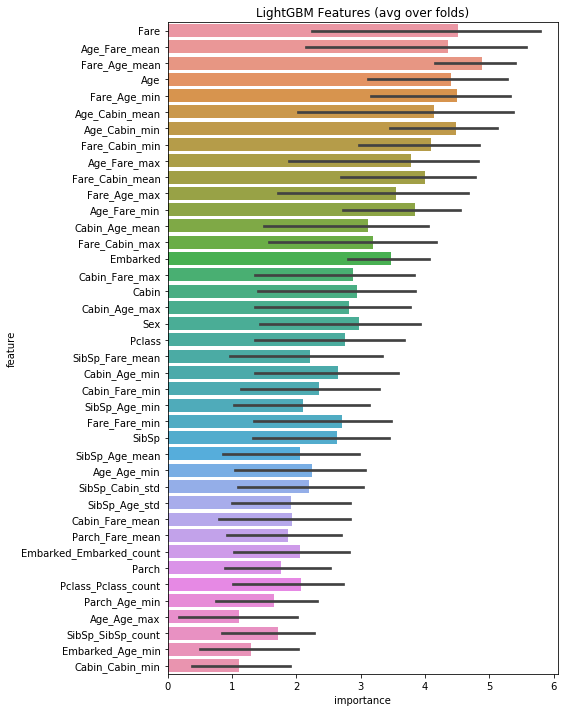

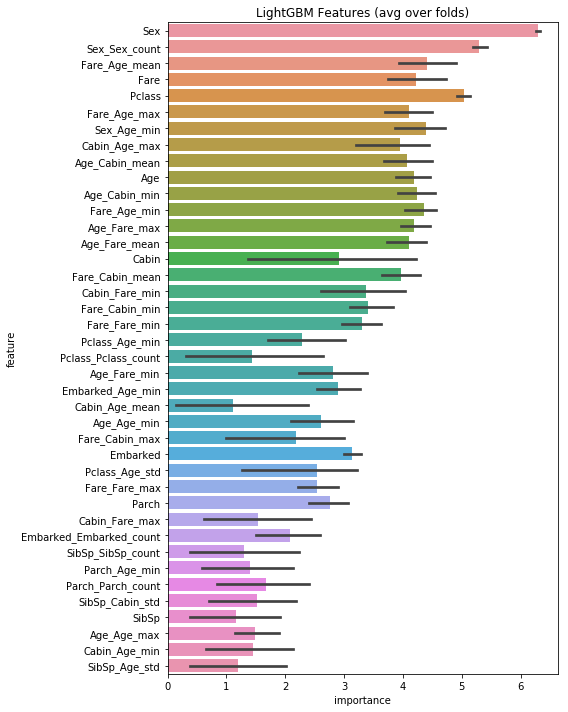

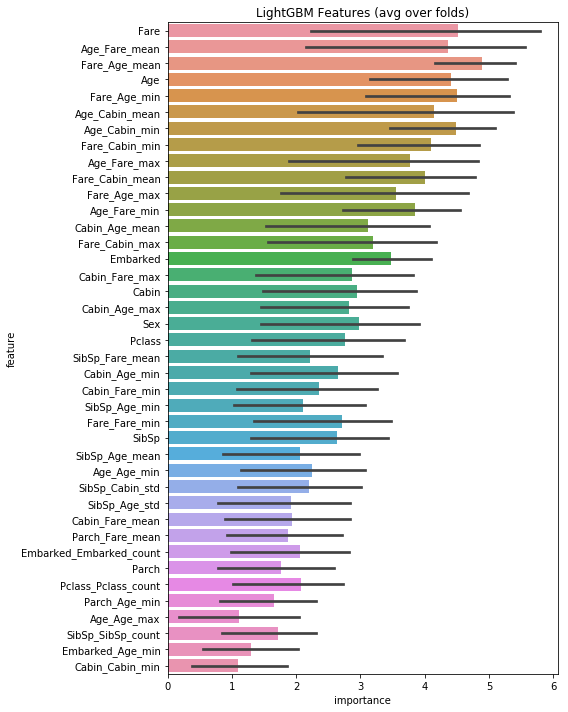

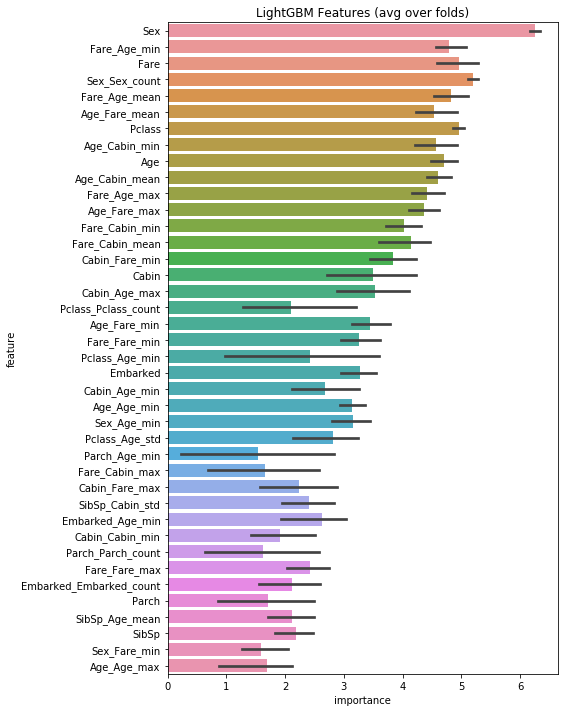

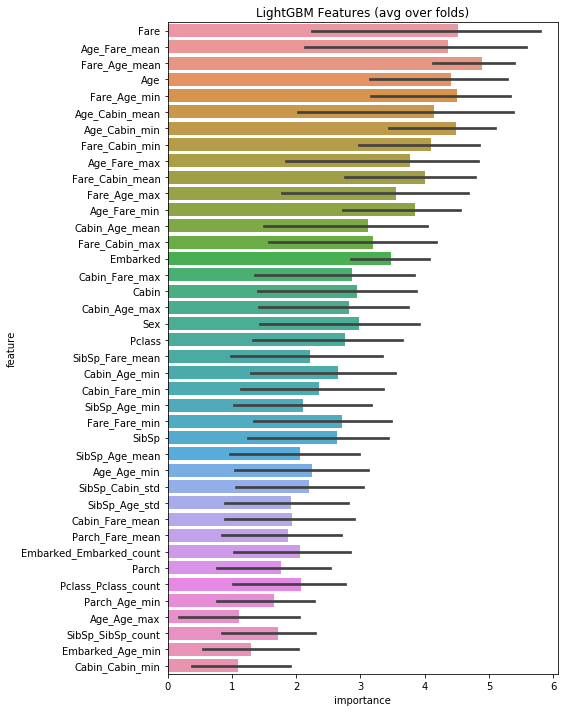

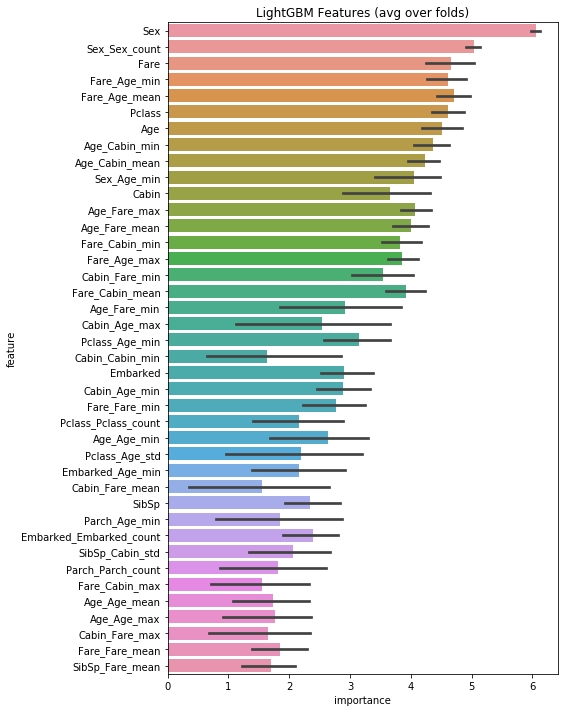

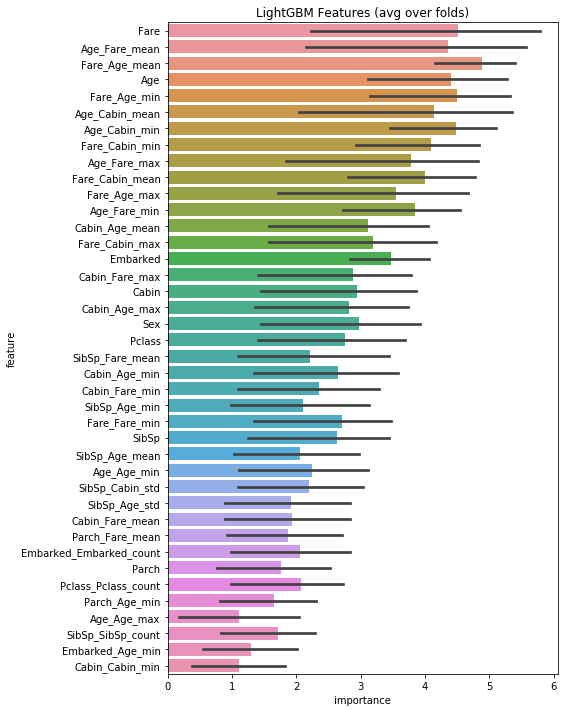

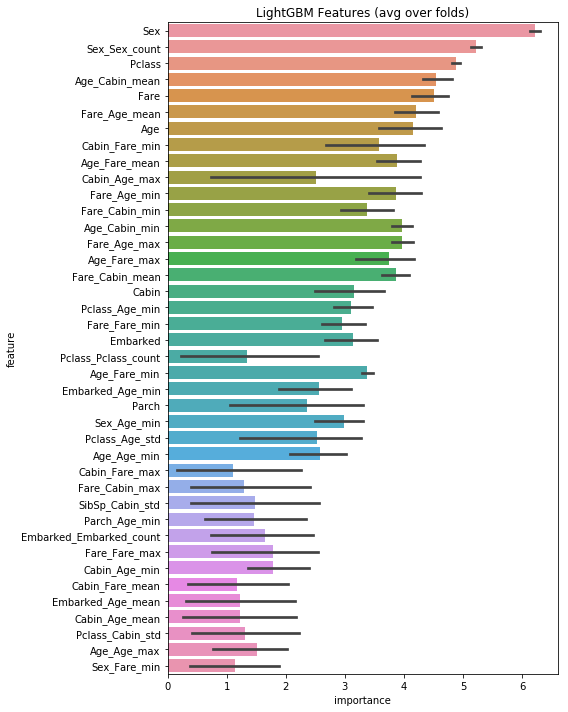

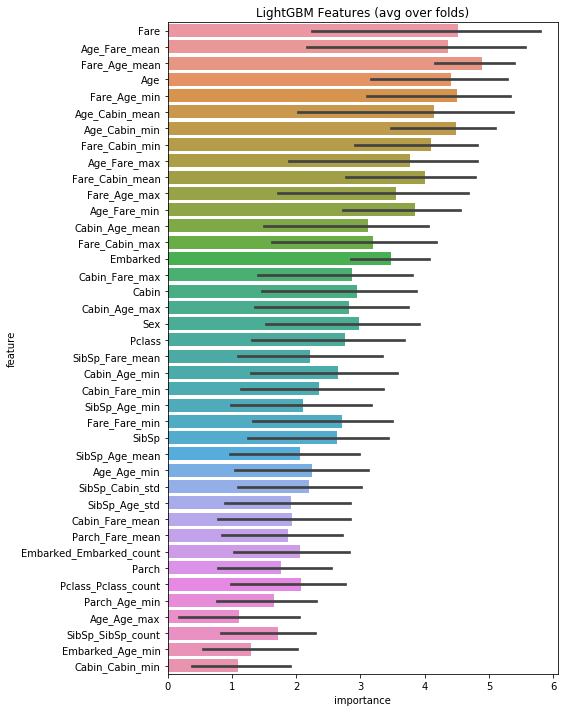

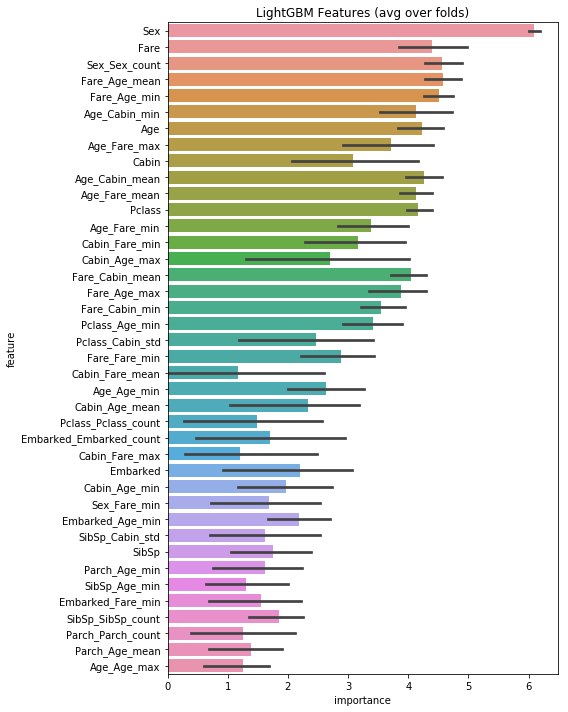

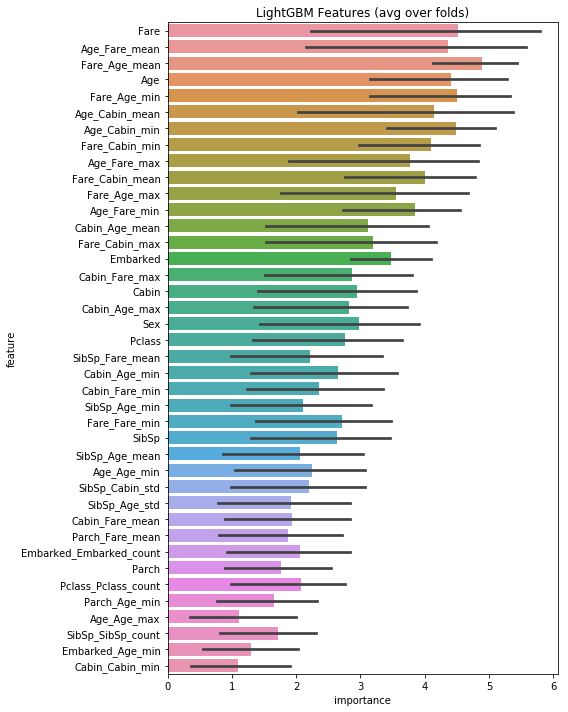

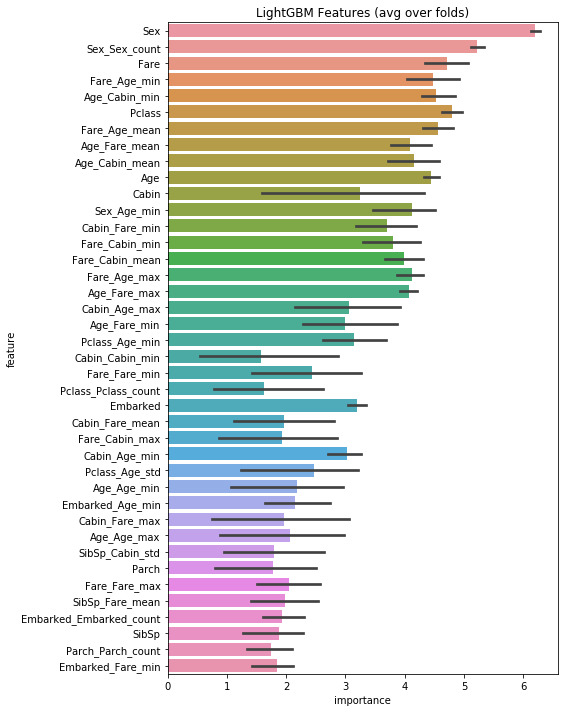

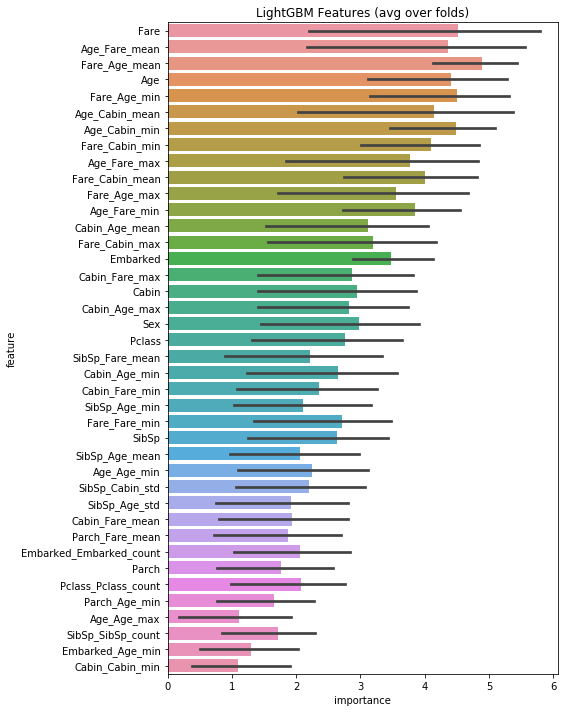

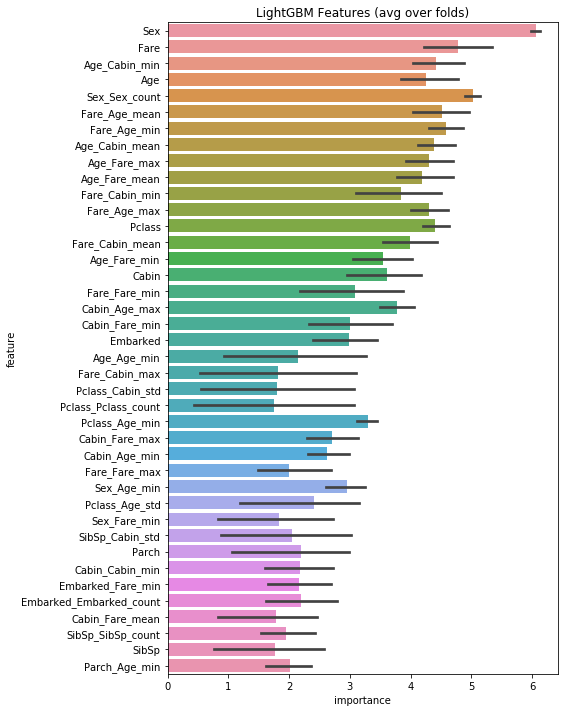

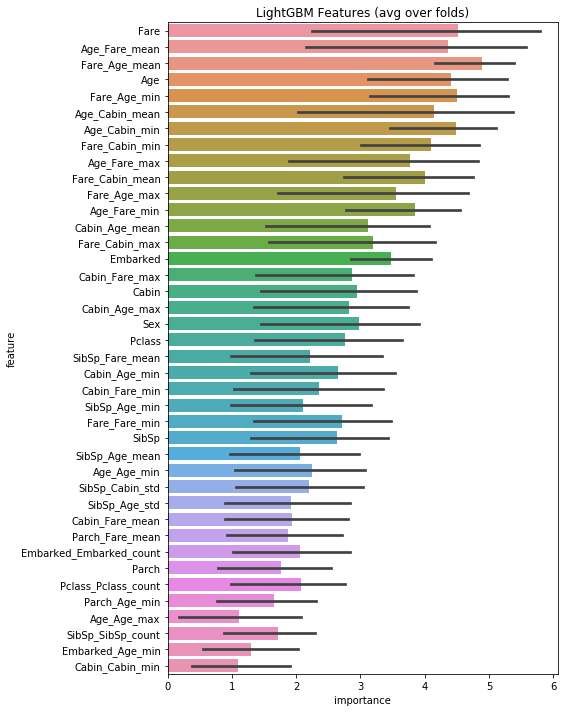

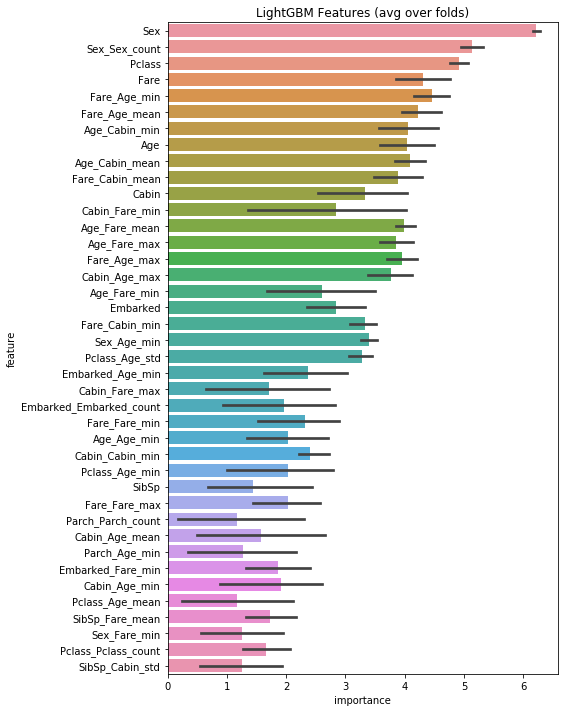

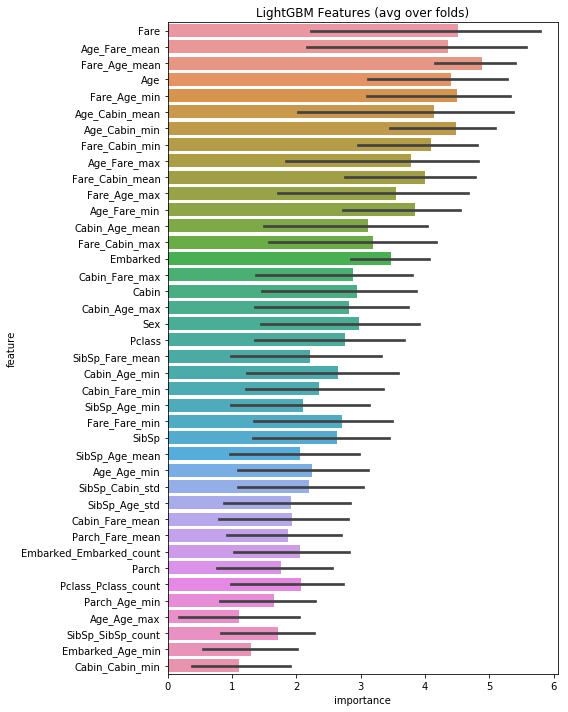

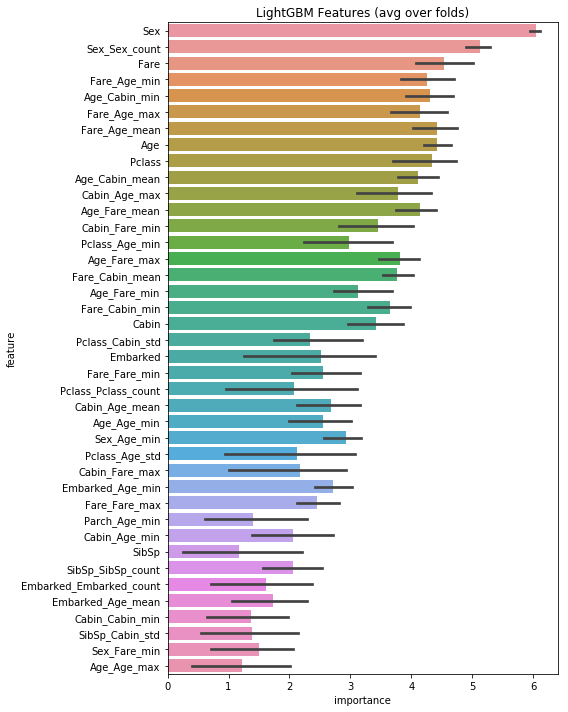

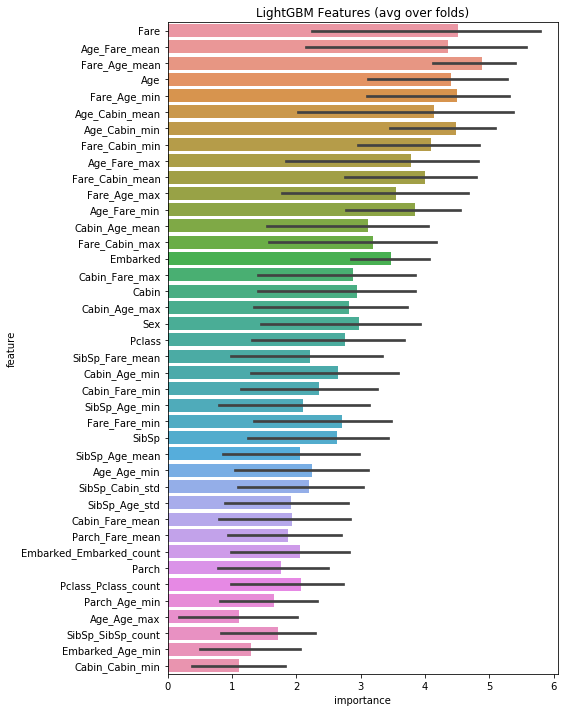

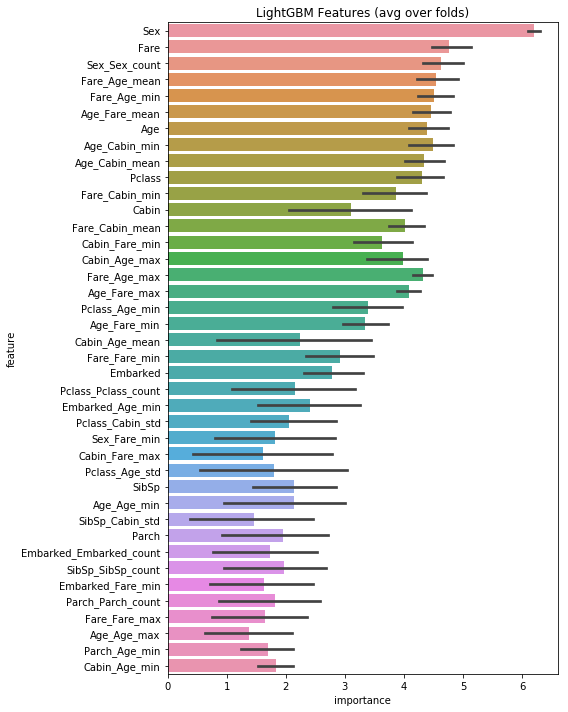

In [28]:
for i in range(0, 10):
    ml.run(scenario)

In [ ]:
# 0.7870813397129187 auc
# 0.7942583732057417 cross_entropy

In [ ]:
train = pd.read_csv("../input/train.csv")
train.head(10)

In [ ]:
ml.engine.train.head(10)